In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score
from torch.backends import cudnn
from torchvision import transforms
from torch import flatten

In [2]:
# define class

class Net(nn.Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(Net, self).__init__()
        # initialize 
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=1, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=1*119*119, out_features=256)
        self.relu3 = nn.ReLU()
        # second layer
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        # 3rd layer
        self.fc3 = nn.Linear(in_features=64, out_features=classes)
        # last layer
        #self.fc4 = nn.Linear(in_features=64, out_features=classes)
        
        # Image dimensions throughout above network will looks like below:
        # initial input torch.Size([1, 1, 1080, 1080])
        # conv1 : initial input torch.Size([1, 1, 1078, 1078])
        # conv1 relu1 : initial input torch.Size([1, 1, 1078, 1078])
        # conv1 maxpool1: initial input torch.Size([1, 1, 359, 359])
        # conv2 : input torch.Size([1, 1, 357, 357])
        # conv2 relu2 : input torch.Size([1, 1, 357, 357])
        # conv2 maxpool2: input torch.Size([1, 1, 119, 119])
        # flatten: input torch.Size([1, 14161])
        # fc1: input torch.Size([1, 64])
        # relu3: input torch.Size([1, 64])
        # output: [1,]
        
    def forward(self, x):
        #print(f'initial input {x.shape}')
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        #print(f'conv1 : initial input {x.shape}')
        x = self.relu1(x)
        #print(f'conv1 relu1 : initial input {x.shape}')
        x = self.maxpool1(x)
        #print(f'conv1 maxpool1: initial input {x.shape}')
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        #print(f'conv2 : input {x.shape}')
        x = self.relu2(x)
        #print(f'conv2 relu2 : input {x.shape}')
        x = self.maxpool2(x)
        #print(f'conv2 maxpool2: input {x.shape}')
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = flatten(x, 1)
        #print(f'flatten: input {x.shape}')
        # reshape to last dim=16
        #x = x.view(-1,16)
        #print(f'flatten reshape: input {x.shape}')
        #x = self.fc1(x)
        #print(f'fc1: input {x.shape}')
        #x = self.relu3(x)
        #print(f'relu3: input {x.shape}')
        # pass the output to our softmax classifier to get our output
        # predictions
        #x = self.relu3(self.fc3(self.relu3(self.fc2(self.relu3(self.fc1(x))))))
        #x = self.relu3(self.fc2(self.relu3(self.fc1(x))))
        #output = self.fc3(x)
        # return the output predictions
        output = self.fc3(self.relu3(self.fc2(self.relu3(self.fc1(x)))))
        return output

In [3]:
def init_weights(m):
    seed = 1234
    torch.cuda.manual_seed(seed)  
    if type(m) == nn.Linear:
        n = m.in_features
        weight_range = 1.0/np.sqrt(n)
        for name, param in m.named_parameters():
            if name=='weight':
                #nn.init.xavier_uniform_(m.weight)
                #nn.init.uniform_(m.weight)
                #m.weight.data.uniform_(-weight_range, weight_range)
                #m.weight.data.normal_(0.0, weight_range)
                m.weight.data.normal_(-1, 1)
            elif name=='bias':
                m.bias.data.fill_(0)
    elif type(m) == nn.Conv2d:
        for name, param in m.named_parameters():
            if name=='weight':
                #nn.init.xavier_uniform_(m.weight)
                #nn.init.uniform_(m.weight)
                #nn.init.normal_(m.weight)
                m.weight.data.normal_(-1, 1)
            elif name=='bias':
                m.bias.data.fill_(0)

In [4]:
def train_model(model, x, y, n_epochs, loss_fn, optimizer, model_output_name, path_dir):
    i = 1
    random.seed(i)
    np.random.seed(i)
    torch.manual_seed(i)
    cudnn.deterministic = True
    cudnn.benchmark = False
    cudnn.enabled = False
    
    #model.apply(init_weights)
    
    min_train_r2 = float(-3000.58950865093647e+20)
    min_loss = float(3000.58950865093647e+20)
    #n_epochs = 100
    i_count = 0

    for epoch in range(n_epochs):
        i_count += 1
        for each_image, each_labels in zip(x,y):
            # read image and convert to numpy array
            image = Image.open(each_image)
            np_image = transforms.ToTensor()(image).unsqueeze_(0)
            # forward, backward, and then weight update
            y_pred = model(np_image.float())
            loss = loss_fn(y_pred, each_labels.unsqueeze_(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f'Epoch:{epoch} | y : {each_labels} | pred_y : {y_pred.item()} | loss {loss.item()}')
        # eval  (TRAIN at this moment)
        train_loss = 0.0
        model.eval()
        d_1_pred_value_for_epoch_train = np.empty((0), int)
        d_1_true_value_for_epoch_train = np.empty((0), int)
        with torch.no_grad():
            for  each_image, each_labels in zip(x,y):
                # read image and convert to numpy array
                image = Image.open(each_image)
                np_image = transforms.ToTensor()(image).unsqueeze_(0)
                # forward, backward, and then weight update
                y_pred = model(np_image.float())
                loss = loss_fn(y_pred, each_labels.unsqueeze_(0))
                train_loss += loss.item()
                # save true and pred value to numpy array
                d_1_true_value_for_epoch_train = np.append(d_1_true_value_for_epoch_train, each_labels.cpu(), axis=0)
                d_1_pred_value_for_epoch_train = np.append(d_1_pred_value_for_epoch_train, y_pred.cpu().data.numpy().squeeze(1), axis=0)
        train_r2 = r2_score(d_1_true_value_for_epoch_train, d_1_pred_value_for_epoch_train)
        print(f'Epoch:{epoch} | train_r2 : {train_r2} | train_loss {train_loss}\n')

        # Early stopping
        if train_r2 > min_train_r2:
        #if train_loss < min_loss:
            # update variables
            epochs_no_improve = 0
            min_train_r2 = train_r2
            min_loss = train_loss
            best_model_train_R2 = train_r2
            os.chdir(path_dir)
            torch.save(model.state_dict(), model_output_name)
        else:
            epochs_no_improve += 1
            #print(f'EarlyStopping counter: {epochs_no_improve} out of {20}')

        if epochs_no_improve == 20:
            early_stop = True
            print(f"Early stopping at Epoch {epoch-20} | R2 {best_model_train_R2}")
            break;
        else:
            continue;
    return best_model_train_R2

In [5]:
path_dir = 'C:/Users/swapnilch/OneDrive - RISE/Swapnil_C_drive/Riskhunter/Cell_painting/Cytochalasin D/CNN_model'

model = Net(1,1)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)


In [6]:
# Get images

In [7]:
curr_path = r'C:\Users\swapnilch\OneDrive - RISE\Swapnil_C_drive\Riskhunter\Cell_painting\Cytochalasin D\raw images'

os.chdir(curr_path)

In [8]:
#get_all_img_nm = glob.glob(pathname, *.tiff, recursive=False)
get_all_img_nm = os.listdir(curr_path)
print(f'Total images: {len(get_all_img_nm)}')

Total images: 360


In [9]:
Cytochalasin_D_HCI_image_names = pd.DataFrame(get_all_img_nm)
Cytochalasin_D_HCI_image_names.columns = ['Image']
print(Cytochalasin_D_HCI_image_names.shape)
Cytochalasin_D_HCI_image_names.head()

(360, 1)


,Image
0,r04c09f01p01-ch1sk1fk1fl1.tiff
1,r04c09f01p01-ch2sk1fk1fl1.tiff
2,r04c09f01p01-ch3sk1fk1fl1.tiff
3,r04c09f01p01-ch4sk1fk1fl1.tiff
4,r04c09f01p01-ch5sk1fk1fl1.tiff


In [10]:
get_all_img_nm[:5]

['r04c09f01p01-ch1sk1fk1fl1.tiff',
 'r04c09f01p01-ch2sk1fk1fl1.tiff',
 'r04c09f01p01-ch3sk1fk1fl1.tiff',
 'r04c09f01p01-ch4sk1fk1fl1.tiff',
 'r04c09f01p01-ch5sk1fk1fl1.tiff']

In [11]:
# lets assign hypothetical dose for tutorial purpose. This array need to be updated after consulation with Marlene!!!
y = torch.tensor([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
print(f'Total y : {len(y)}')
y

Total y : 8


tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000])

In [12]:
channel_1_fl_nm = []
for file in get_all_img_nm:
    # find files with "ch1" string
    if 'ch1' in file:
        #channel_1_fl_nm = curr_path + file
        channel_1_fl_nm.append(file)
        
print(f'Total images: {len(channel_1_fl_nm)}')
channel_1_fl_nm

Total images: 40


['r04c09f01p01-ch1sk1fk1fl1.tiff',
 'r04c09f02p01-ch1sk1fk1fl1.tiff',
 'r04c09f03p01-ch1sk1fk1fl1.tiff',
 'r04c09f04p01-ch1sk1fk1fl1.tiff',
 'r04c09f05p01-ch1sk1fk1fl1.tiff',
 'r04c10f01p01-ch1sk1fk1fl1.tiff',
 'r04c10f02p01-ch1sk1fk1fl1.tiff',
 'r04c10f03p01-ch1sk1fk1fl1.tiff',
 'r04c10f04p01-ch1sk1fk1fl1.tiff',
 'r04c10f05p01-ch1sk1fk1fl1.tiff',
 'r04c11f01p01-ch1sk1fk1fl1.tiff',
 'r04c11f02p01-ch1sk1fk1fl1.tiff',
 'r04c11f03p01-ch1sk1fk1fl1.tiff',
 'r04c11f04p01-ch1sk1fk1fl1.tiff',
 'r04c11f05p01-ch1sk1fk1fl1.tiff',
 'r04c12f01p01-ch1sk1fk1fl1.tiff',
 'r04c12f02p01-ch1sk1fk1fl1.tiff',
 'r04c12f03p01-ch1sk1fk1fl1.tiff',
 'r04c12f04p01-ch1sk1fk1fl1.tiff',
 'r04c12f05p01-ch1sk1fk1fl1.tiff',
 'r04c13f01p01-ch1sk1fk1fl1.tiff',
 'r04c13f02p01-ch1sk1fk1fl1.tiff',
 'r04c13f03p01-ch1sk1fk1fl1.tiff',
 'r04c13f04p01-ch1sk1fk1fl1.tiff',
 'r04c13f05p01-ch1sk1fk1fl1.tiff',
 'r04c14f01p01-ch1sk1fk1fl1.tiff',
 'r04c14f02p01-ch1sk1fk1fl1.tiff',
 'r04c14f03p01-ch1sk1fk1fl1.tiff',
 'r04c14f04p01-ch1sk

In [13]:
# Model -1 with f01

In [14]:
channel_1_first_snap_fl_nm = []
for file in get_all_img_nm:
    # find files with "f01p01-ch1" string
    if 'f01p01-ch1' in file:
        #channel_1_fl_nm = curr_path + file
        channel_1_first_snap_fl_nm.append(file)
        
print(f'Total images: {len(channel_1_first_snap_fl_nm)}')
x_1 = ['C:/Users/swapnilch/OneDrive - RISE/Swapnil_C_drive/Riskhunter/Cell_painting/Cytochalasin D/raw images/' + each_img for each_img in channel_1_first_snap_fl_nm]
print(f'Total x_1 : {len(x_1)}')

Total images: 8
Total x_1 : 8


In [15]:
model_1_r2 = train_model(model, x_1, y, 200, loss_fn, optimizer, 'checkpoint_model_1.pt', path_dir)

C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:0 | y : tensor([0.1000]) | pred_y : -0.5581621527671814 | loss 0.4331774413585663
Epoch:0 | y : tensor([0.2000]) | pred_y : 11.055076599121094 | loss 117.83269500732422
Epoch:0 | y : tensor([0.3000]) | pred_y : -5.678045272827148 | loss 35.73702621459961
Epoch:0 | y : tensor([0.4000]) | pred_y : 34.77158737182617 | loss 1181.4058837890625
Epoch:0 | y : tensor([0.5000]) | pred_y : 2.0531418323516846 | loss 2.4122495651245117
Epoch:0 | y : tensor([0.6000]) | pred_y : -1.0424734354019165 | loss 2.697719097137451
Epoch:0 | y : tensor([0.7000]) | pred_y : -2.972460985183716 | loss 13.486969947814941
Epoch:0 | y : tensor([0.8000]) | pred_y : -1.7002747058868408 | loss 6.251373291015625
Epoch:0 | train_r2 : -1135948.878216384 | train_loss 477098.95609521866

Epoch:1 | y : tensor([0.1000]) | pred_y : 18.949575424194336 | loss 355.3064880371094


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1 | y : tensor([0.2000]) | pred_y : -688.54345703125 | loss 474367.5625
Epoch:1 | y : tensor([0.3000]) | pred_y : 155.8810577392578 | loss 24205.46484375
Epoch:1 | y : tensor([0.4000]) | pred_y : -320.3627624511719 | loss 102888.7421875
Epoch:1 | y : tensor([0.5000]) | pred_y : -81.73388671875 | loss 6762.412109375
Epoch:1 | y : tensor([0.6000]) | pred_y : 4.227889537811279 | loss 13.161582946777344
Epoch:1 | y : tensor([0.7000]) | pred_y : 50.539608001708984 | loss 2483.986328125
Epoch:1 | y : tensor([0.8000]) | pred_y : 3.9713363647460938 | loss 10.057374954223633
Epoch:1 | train_r2 : -437981.28409376106 | train_loss 183952.5593246147

Epoch:2 | y : tensor([0.1000]) | pred_y : -419.60186767578125 | loss 176149.65625


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:2 | y : tensor([0.2000]) | pred_y : -9.68532943725586 | loss 97.71973419189453
Epoch:2 | y : tensor([0.3000]) | pred_y : -26.825908660888672 | loss 735.8148803710938
Epoch:2 | y : tensor([0.4000]) | pred_y : 7.82863712310791 | loss 55.18464660644531
Epoch:2 | y : tensor([0.5000]) | pred_y : -0.17350752651691437 | loss 0.453612357378006
Epoch:2 | y : tensor([0.6000]) | pred_y : -1.077467918395996 | loss 2.813898801803589
Epoch:2 | y : tensor([0.7000]) | pred_y : -8.792252540588379 | loss 90.10285186767578
Epoch:2 | y : tensor([0.8000]) | pred_y : 0.3134167194366455 | loss 0.23676329851150513
Epoch:2 | train_r2 : -45027.63712091703 | train_loss 18912.028397057205

Epoch:3 | y : tensor([0.1000]) | pred_y : 97.08647155761719 | loss 9406.3759765625


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:3 | y : tensor([0.2000]) | pred_y : 90.02091217041016 | loss 8067.796875
Epoch:3 | y : tensor([0.3000]) | pred_y : 3.1241090297698975 | loss 7.975592136383057
Epoch:3 | y : tensor([0.4000]) | pred_y : 39.850975036621094 | loss 1556.3792724609375
Epoch:3 | y : tensor([0.5000]) | pred_y : 6.410861968994141 | loss 34.938289642333984
Epoch:3 | y : tensor([0.6000]) | pred_y : -0.24202249944210052 | loss 0.7090019583702087
Epoch:3 | y : tensor([0.7000]) | pred_y : -2.791029214859009 | loss 12.187285423278809
Epoch:3 | y : tensor([0.8000]) | pred_y : -0.2115592062473297 | loss 1.0232521295547485
Epoch:3 | train_r2 : -23324.481654263225 | train_loss 9796.70273065567

Epoch:4 | y : tensor([0.1000]) | pred_y : 90.180419921875 | loss 8114.482421875


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:4 | y : tensor([0.2000]) | pred_y : -52.64700698852539 | loss 2792.80615234375
Epoch:4 | y : tensor([0.3000]) | pred_y : 3.8186147212982178 | loss 12.38064956665039
Epoch:4 | y : tensor([0.4000]) | pred_y : -3.690307855606079 | loss 16.73061752319336
Epoch:4 | y : tensor([0.5000]) | pred_y : -3.5572350025177 | loss 16.461153030395508
Epoch:4 | y : tensor([0.6000]) | pred_y : 0.10380277782678604 | loss 0.2462117075920105
Epoch:4 | y : tensor([0.7000]) | pred_y : 3.235147476196289 | loss 6.426972389221191
Epoch:4 | y : tensor([0.8000]) | pred_y : 0.32659927010536194 | loss 0.2241082638502121
Epoch:4 | train_r2 : -4517.111319341978 | train_loss 1897.6068196594715

Epoch:5 | y : tensor([0.1000]) | pred_y : 19.318815231323242 | loss 369.36285400390625


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:5 | y : tensor([0.2000]) | pred_y : -35.977596282958984 | loss 1308.8184814453125
Epoch:5 | y : tensor([0.3000]) | pred_y : 1.745517611503601 | loss 2.0895209312438965
Epoch:5 | y : tensor([0.4000]) | pred_y : -14.065443992614746 | loss 209.24905395507812
Epoch:5 | y : tensor([0.5000]) | pred_y : -0.05305642634630203 | loss 0.3058713972568512
Epoch:5 | y : tensor([0.6000]) | pred_y : 0.45603761076927185 | loss 0.020725175738334656
Epoch:5 | y : tensor([0.7000]) | pred_y : 1.7412564754486084 | loss 1.0842149257659912
Epoch:5 | y : tensor([0.8000]) | pred_y : 0.7645654678344727 | loss 0.0012556068832054734
Epoch:5 | train_r2 : -3144.7643323784264 | train_loss 1321.2209380794975

Epoch:6 | y : tensor([0.1000]) | pred_y : -32.706016540527344 | loss 1076.234619140625


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:6 | y : tensor([0.2000]) | pred_y : 19.046072006225586 | loss 355.1744079589844
Epoch:6 | y : tensor([0.3000]) | pred_y : 1.9850256443023682 | loss 2.8393115997314453
Epoch:6 | y : tensor([0.4000]) | pred_y : -3.8424551486968994 | loss 17.998424530029297
Epoch:6 | y : tensor([0.5000]) | pred_y : 2.856489419937134 | loss 5.553042411804199
Epoch:6 | y : tensor([0.6000]) | pred_y : 0.6696646213531494 | loss 0.004853155929595232
Epoch:6 | y : tensor([0.7000]) | pred_y : -0.22919698059558868 | loss 0.8634069561958313
Epoch:6 | y : tensor([0.8000]) | pred_y : 1.0500198602676392 | loss 0.0625099241733551
Epoch:6 | train_r2 : -1286.169167463308 | train_loss 540.6109983799979

Epoch:7 | y : tensor([0.1000]) | pred_y : -2.9382758140563965 | loss 9.231119155883789


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:7 | y : tensor([0.2000]) | pred_y : 23.537433624267578 | loss 544.6357421875
Epoch:7 | y : tensor([0.3000]) | pred_y : 1.2863513231277466 | loss 0.9728888869285583
Epoch:7 | y : tensor([0.4000]) | pred_y : 3.6937947273254395 | loss 10.849082946777344
Epoch:7 | y : tensor([0.5000]) | pred_y : 1.5424848794937134 | loss 1.0867747068405151
Epoch:7 | y : tensor([0.6000]) | pred_y : 0.7107691168785095 | loss 0.012269792146980762
Epoch:7 | y : tensor([0.7000]) | pred_y : 0.33725476264953613 | loss 0.13158409297466278
Epoch:7 | y : tensor([0.8000]) | pred_y : 0.9875277876853943 | loss 0.0351666659116745
Epoch:7 | train_r2 : -269.74378341725856 | train_loss 113.71238102670759

Epoch:8 | y : tensor([0.1000]) | pred_y : 10.020706176757812 | loss 98.42040252685547


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:8 | y : tensor([0.2000]) | pred_y : -5.4292778968811035 | loss 31.68876838684082
Epoch:8 | y : tensor([0.3000]) | pred_y : -0.7900211215019226 | loss 1.1881461143493652
Epoch:8 | y : tensor([0.4000]) | pred_y : 2.442199468612671 | loss 4.170578479766846
Epoch:8 | y : tensor([0.5000]) | pred_y : -0.6972848176956177 | loss 1.4334909915924072
Epoch:8 | y : tensor([0.6000]) | pred_y : 0.6696019172668457 | loss 0.00484442338347435
Epoch:8 | y : tensor([0.7000]) | pred_y : 1.021122694015503 | loss 0.10311979055404663
Epoch:8 | y : tensor([0.8000]) | pred_y : 0.7527051568031311 | loss 0.0022368032950907946
Epoch:8 | train_r2 : -330.8842750876495 | train_loss 139.39139162097126

Epoch:9 | y : tensor([0.1000]) | pred_y : 3.0060055255889893 | loss 8.444869041442871


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:9 | y : tensor([0.2000]) | pred_y : -11.686306953430176 | loss 141.28428649902344
Epoch:9 | y : tensor([0.3000]) | pred_y : -1.1098170280456543 | loss 1.987583875656128
Epoch:9 | y : tensor([0.4000]) | pred_y : 0.708320140838623 | loss 0.0950613021850586
Epoch:9 | y : tensor([0.5000]) | pred_y : -0.2785305082798004 | loss 0.6061096787452698
Epoch:9 | y : tensor([0.6000]) | pred_y : 0.6378821730613708 | loss 0.0014350572600960732
Epoch:9 | y : tensor([0.7000]) | pred_y : 0.892184853553772 | loss 0.036935023963451385
Epoch:9 | y : tensor([0.8000]) | pred_y : 0.72198885679245 | loss 0.006085740402340889
Epoch:9 | train_r2 : -23.552173958591098 | train_loss 10.311912414967082

Epoch:10 | y : tensor([0.1000]) | pred_y : -2.625673532485962 | loss 7.429295539855957


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:10 | y : tensor([0.2000]) | pred_y : 3.136294364929199 | loss 8.621824264526367
Epoch:10 | y : tensor([0.3000]) | pred_y : 0.16471624374389648 | loss 0.018301697447896004
Epoch:10 | y : tensor([0.4000]) | pred_y : 0.6863898634910583 | loss 0.0820191502571106
Epoch:10 | y : tensor([0.5000]) | pred_y : 0.9275348782539368 | loss 0.18278607726097107
Epoch:10 | y : tensor([0.6000]) | pred_y : 0.6144086122512817 | loss 0.0002076074160868302
Epoch:10 | y : tensor([0.7000]) | pred_y : 0.5330398678779602 | loss 0.027875682339072227
Epoch:10 | y : tensor([0.8000]) | pred_y : 0.7947148680686951 | loss 2.7932745069847442e-05
Epoch:10 | train_r2 : -69.06188698890041 | train_loss 29.42599395783293

Epoch:11 | y : tensor([0.1000]) | pred_y : -1.742552638053894 | loss 3.3950002193450928


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:11 | y : tensor([0.2000]) | pred_y : 5.501435279846191 | loss 28.1052188873291
Epoch:11 | y : tensor([0.3000]) | pred_y : 0.7251088619232178 | loss 0.18071752786636353
Epoch:11 | y : tensor([0.4000]) | pred_y : 0.03240606188774109 | loss 0.1351253092288971
Epoch:11 | y : tensor([0.5000]) | pred_y : 0.9037169814109802 | loss 0.16298739612102509
Epoch:11 | y : tensor([0.6000]) | pred_y : 0.5904607772827148 | loss 9.099722228711471e-05
Epoch:11 | y : tensor([0.7000]) | pred_y : 0.640631914138794 | loss 0.0035245681647211313
Epoch:11 | y : tensor([0.8000]) | pred_y : 0.823658287525177 | loss 0.0005597139825113118
Epoch:11 | train_r2 : -5.173587336721572 | train_loss 2.5929067955439677

Epoch:12 | y : tensor([0.1000]) | pred_y : 0.6146736741065979 | loss 0.2648889720439911


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:12 | y : tensor([0.2000]) | pred_y : -1.796777367591858 | loss 3.9871201515197754
Epoch:12 | y : tensor([0.3000]) | pred_y : 0.4683888256549835 | loss 0.028354791924357414
Epoch:12 | y : tensor([0.4000]) | pred_y : -0.29064562916755676 | loss 0.4769913852214813
Epoch:12 | y : tensor([0.5000]) | pred_y : 0.3944678008556366 | loss 0.011137044988572598
Epoch:12 | y : tensor([0.6000]) | pred_y : 0.5821932554244995 | loss 0.0003170809941366315
Epoch:12 | y : tensor([0.7000]) | pred_y : 0.8115866184234619 | loss 0.012451576068997383
Epoch:12 | y : tensor([0.8000]) | pred_y : 0.8115828037261963 | loss 0.00013416106230579317
Epoch:12 | train_r2 : -10.132727825036106 | train_loss 4.675745833053952

Epoch:13 | y : tensor([0.1000]) | pred_y : 1.134598731994629 | loss 1.070394515991211


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:13 | y : tensor([0.2000]) | pred_y : -1.6937646865844727 | loss 3.5863449573516846
Epoch:13 | y : tensor([0.3000]) | pred_y : 0.3652012348175049 | loss 0.004251199308782816
Epoch:13 | y : tensor([0.4000]) | pred_y : 0.539605438709259 | loss 0.019489677622914314
Epoch:13 | y : tensor([0.5000]) | pred_y : 0.3675737977027893 | loss 0.017536699771881104
Epoch:13 | y : tensor([0.6000]) | pred_y : 0.5903393030166626 | loss 9.332952322438359e-05
Epoch:13 | y : tensor([0.7000]) | pred_y : 0.6670852899551392 | loss 0.001083377399481833
Epoch:13 | y : tensor([0.8000]) | pred_y : 0.7957669496536255 | loss 1.7918815501616336e-05
Epoch:13 | train_r2 : -2.2356639733297885 | train_loss 1.358978833164656

Epoch:14 | y : tensor([0.1000]) | pred_y : 0.06182282418012619 | loss 0.001457496895454824


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:14 | y : tensor([0.2000]) | pred_y : 1.5684027671813965 | loss 1.8725260496139526
Epoch:14 | y : tensor([0.3000]) | pred_y : 0.3234140872955322 | loss 0.0005482189008034766
Epoch:14 | y : tensor([0.4000]) | pred_y : 0.8412962555885315 | loss 0.1947423815727234
Epoch:14 | y : tensor([0.5000]) | pred_y : 0.50612872838974 | loss 3.756131263799034e-05
Epoch:14 | y : tensor([0.6000]) | pred_y : 0.5978543162345886 | loss 4.604061359714251e-06
Epoch:14 | y : tensor([0.7000]) | pred_y : 0.6582534313201904 | loss 0.0017427749698981643
Epoch:14 | y : tensor([0.8000]) | pred_y : 0.7904182076454163 | loss 9.18109726626426e-05
Epoch:14 | train_r2 : -0.32450697819067864 | train_loss 0.5562929717425504

Epoch:15 | y : tensor([0.1000]) | pred_y : -0.5323609113693237 | loss 0.3998803496360779


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:15 | y : tensor([0.2000]) | pred_y : 0.4967421293258667 | loss 0.08805590122938156
Epoch:15 | y : tensor([0.3000]) | pred_y : 0.18716548383235931 | loss 0.012731630355119705
Epoch:15 | y : tensor([0.4000]) | pred_y : 0.3297012150287628 | loss 0.004941919818520546
Epoch:15 | y : tensor([0.5000]) | pred_y : 0.5180270075798035 | loss 0.0003249729925300926
Epoch:15 | y : tensor([0.6000]) | pred_y : 0.6008111834526062 | loss 6.579799105566053e-07
Epoch:15 | y : tensor([0.7000]) | pred_y : 0.7499864101409912 | loss 0.0024986423086375
Epoch:15 | y : tensor([0.8000]) | pred_y : 0.8000276684761047 | loss 7.648850441910326e-10
Epoch:15 | train_r2 : 0.09114360228288121 | train_loss 0.3817197121989011

Epoch:16 | y : tensor([0.1000]) | pred_y : 0.1676768958568573 | loss 0.00458016199991107


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:16 | y : tensor([0.2000]) | pred_y : -0.46718931198120117 | loss 0.4451415538787842
Epoch:16 | y : tensor([0.3000]) | pred_y : 0.2364444136619568 | loss 0.004039314109832048
Epoch:16 | y : tensor([0.4000]) | pred_y : 0.22568264603614807 | loss 0.03038654290139675
Epoch:16 | y : tensor([0.5000]) | pred_y : 0.5231426358222961 | loss 0.0005355816101655364
Epoch:16 | y : tensor([0.6000]) | pred_y : 0.6026474833488464 | loss 7.009041837591212e-06
Epoch:16 | y : tensor([0.7000]) | pred_y : 0.6834259033203125 | loss 0.00027470028726384044
Epoch:16 | y : tensor([0.8000]) | pred_y : 0.8061672449111938 | loss 3.803476283792406e-05
Epoch:16 | train_r2 : 0.6259941872318251 | train_loss 0.1570824509835802

Epoch:17 | y : tensor([0.1000]) | pred_y : 0.46490925550460815 | loss 0.13315877318382263


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:17 | y : tensor([0.2000]) | pred_y : 0.41533607244491577 | loss 0.04636962339282036
Epoch:17 | y : tensor([0.3000]) | pred_y : 0.3530549108982086 | loss 0.0028148223645985126
Epoch:17 | y : tensor([0.4000]) | pred_y : 0.4409392476081848 | loss 0.0016760214930400252
Epoch:17 | y : tensor([0.5000]) | pred_y : 0.5053827166557312 | loss 2.8973638109164312e-05
Epoch:17 | y : tensor([0.6000]) | pred_y : 0.6020538210868835 | loss 4.2180831769655924e-06
Epoch:17 | y : tensor([0.7000]) | pred_y : 0.6902927160263062 | loss 9.423113078810275e-05
Epoch:17 | y : tensor([0.8000]) | pred_y : 0.7992253303527832 | loss 6.001315568937571e-07
Epoch:17 | train_r2 : 0.8974176761771883 | train_loss 0.043084574878548665

Epoch:18 | y : tensor([0.1000]) | pred_y : -0.048079997301101685 | loss 0.021927684545516968


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:18 | y : tensor([0.2000]) | pred_y : 0.3331901431083679 | loss 0.017739612609148026
Epoch:18 | y : tensor([0.3000]) | pred_y : 0.3263700008392334 | loss 0.0006953763077035546
Epoch:18 | y : tensor([0.4000]) | pred_y : 0.4328310489654541 | loss 0.0010778773576021194
Epoch:18 | y : tensor([0.5000]) | pred_y : 0.4750535488128662 | loss 0.0006223254022188485
Epoch:18 | y : tensor([0.6000]) | pred_y : 0.6000030040740967 | loss 8.881784197001252e-12
Epoch:18 | y : tensor([0.7000]) | pred_y : 0.7137582302093506 | loss 0.00018928923236671835
Epoch:18 | y : tensor([0.8000]) | pred_y : 0.7967015504837036 | loss 1.0879847650357988e-05
Epoch:18 | train_r2 : 0.9044541798650567 | train_loss 0.040129242740022164

Epoch:19 | y : tensor([0.1000]) | pred_y : -0.040020912885665894 | loss 0.019605854526162148


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:19 | y : tensor([0.2000]) | pred_y : 0.035644374787807465 | loss 0.027012774720788002
Epoch:19 | y : tensor([0.3000]) | pred_y : 0.2919548749923706 | loss 6.472422683145851e-05
Epoch:19 | y : tensor([0.4000]) | pred_y : 0.3955821096897125 | loss 1.951780723175034e-05
Epoch:19 | y : tensor([0.5000]) | pred_y : 0.5007799863815308 | loss 6.083787411625963e-07
Epoch:19 | y : tensor([0.6000]) | pred_y : 0.5992453098297119 | loss 5.69593225918652e-07
Epoch:19 | y : tensor([0.7000]) | pred_y : 0.6924150586128235 | loss 5.7531153288437054e-05
Epoch:19 | y : tensor([0.8000]) | pred_y : 0.8009861707687378 | loss 9.72509269558941e-07
Epoch:19 | train_r2 : 0.9483105022320466 | train_loss 0.021709587169823408

Epoch:20 | y : tensor([0.1000]) | pred_y : 0.2378794401884079 | loss 0.019010737538337708


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:20 | y : tensor([0.2000]) | pred_y : 0.26573121547698975 | loss 0.004320592153817415
Epoch:20 | y : tensor([0.3000]) | pred_y : 0.29884713888168335 | loss 1.3291162304085447e-06
Epoch:20 | y : tensor([0.4000]) | pred_y : 0.40384918451309204 | loss 1.4816175280429889e-05
Epoch:20 | y : tensor([0.5000]) | pred_y : 0.5134989619255066 | loss 0.00018222197832074016
Epoch:20 | y : tensor([0.6000]) | pred_y : 0.5992556810379028 | loss 5.540462097997079e-07
Epoch:20 | y : tensor([0.7000]) | pred_y : 0.7016501426696777 | loss 2.723010084082489e-06
Epoch:20 | y : tensor([0.8000]) | pred_y : 0.8008285760879517 | loss 6.865186037430249e-07
Epoch:20 | train_r2 : 0.9992532471742576 | train_loss 0.0003136361963242962

Epoch:21 | y : tensor([0.1000]) | pred_y : 0.09672322869300842 | loss 1.0737239790614694e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:21 | y : tensor([0.2000]) | pred_y : 0.20642119646072388 | loss 4.1231724026147276e-05
Epoch:21 | y : tensor([0.3000]) | pred_y : 0.29063600301742554 | loss 8.768466068431735e-05
Epoch:21 | y : tensor([0.4000]) | pred_y : 0.3840996026992798 | loss 0.0002528228214941919
Epoch:21 | y : tensor([0.5000]) | pred_y : 0.4948931336402893 | loss 2.608008435345255e-05
Epoch:21 | y : tensor([0.6000]) | pred_y : 0.5994653105735779 | loss 2.859182757219969e-07
Epoch:21 | y : tensor([0.7000]) | pred_y : 0.6998119354248047 | loss 3.5363800776622156e-08
Epoch:21 | y : tensor([0.8000]) | pred_y : 0.7992879748344421 | loss 5.069967983217794e-07
Epoch:21 | train_r2 : 0.9896273807264202 | train_loss 0.004356500128295693

Epoch:22 | y : tensor([0.1000]) | pred_y : 0.040606655180454254 | loss 0.0035275695845484734


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:22 | y : tensor([0.2000]) | pred_y : 0.17140766978263855 | loss 0.0008175215334631503
Epoch:22 | y : tensor([0.3000]) | pred_y : 0.29890042543411255 | loss 1.2090904419892468e-06
Epoch:22 | y : tensor([0.4000]) | pred_y : 0.4030987322330475 | loss 9.602104910300113e-06
Epoch:22 | y : tensor([0.5000]) | pred_y : 0.4972567558288574 | loss 7.525388355134055e-06
Epoch:22 | y : tensor([0.6000]) | pred_y : 0.5999034643173218 | loss 9.323741778644035e-09
Epoch:22 | y : tensor([0.7000]) | pred_y : 0.7019020318984985 | loss 3.6177707443130203e-06
Epoch:22 | y : tensor([0.8000]) | pred_y : 0.799856424331665 | loss 2.061739579062305e-08
Epoch:22 | train_r2 : 0.9948965472291423 | train_loss 0.0021434501880577272

Epoch:23 | y : tensor([0.1000]) | pred_y : 0.13673372566699982 | loss 0.0013493665028363466


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:23 | y : tensor([0.2000]) | pred_y : 0.22842830419540405 | loss 0.0008081683190539479
Epoch:23 | y : tensor([0.3000]) | pred_y : 0.3074427843093872 | loss 5.539485937333666e-05
Epoch:23 | y : tensor([0.4000]) | pred_y : 0.410718709230423 | loss 0.00011489060125313699
Epoch:23 | y : tensor([0.5000]) | pred_y : 0.5022198557853699 | loss 4.927759619022254e-06
Epoch:23 | y : tensor([0.6000]) | pred_y : 0.5999977588653564 | loss 5.130118552187923e-12
Epoch:23 | y : tensor([0.7000]) | pred_y : 0.695624828338623 | loss 1.91420222108718e-05
Epoch:23 | y : tensor([0.8000]) | pred_y : 0.7999688386917114 | loss 9.717702198486222e-10
Epoch:23 | train_r2 : 0.9993346445359894 | train_loss 0.00027944929805379104

Epoch:24 | y : tensor([0.1000]) | pred_y : 0.10011591017246246 | loss 1.3434823031843734e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:24 | y : tensor([0.2000]) | pred_y : 0.17939551174640656 | loss 0.0004245450545568019
Epoch:24 | y : tensor([0.3000]) | pred_y : 0.29885345697402954 | loss 1.3145881894160993e-06
Epoch:24 | y : tensor([0.4000]) | pred_y : 0.39272812008857727 | loss 5.288032480166294e-05
Epoch:24 | y : tensor([0.5000]) | pred_y : 0.49944475293159485 | loss 3.0829932029519114e-07
Epoch:24 | y : tensor([0.6000]) | pred_y : 0.5999143123626709 | loss 7.346457664425543e-09
Epoch:24 | y : tensor([0.7000]) | pred_y : 0.7060468196868896 | loss 3.656417175079696e-05
Epoch:24 | y : tensor([0.8000]) | pred_y : 0.7999580502510071 | loss 1.760781742632389e-09
Epoch:24 | train_r2 : 0.9994832673238656 | train_loss 0.0002170277209536664

Epoch:25 | y : tensor([0.1000]) | pred_y : 0.08677764981985092 | loss 0.0001748305803630501


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:25 | y : tensor([0.2000]) | pred_y : 0.20827838778495789 | loss 6.853165541542694e-05
Epoch:25 | y : tensor([0.3000]) | pred_y : 0.29852908849716187 | loss 2.1636158180626808e-06
Epoch:25 | y : tensor([0.4000]) | pred_y : 0.39895743131637573 | loss 1.0869619018194498e-06
Epoch:25 | y : tensor([0.5000]) | pred_y : 0.5001134276390076 | loss 1.2865829290831243e-08
Epoch:25 | y : tensor([0.6000]) | pred_y : 0.5998421907424927 | loss 2.4911287255235948e-08
Epoch:25 | y : tensor([0.7000]) | pred_y : 0.6919749975204468 | loss 6.44004758214578e-05
Epoch:25 | y : tensor([0.8000]) | pred_y : 0.7998983860015869 | loss 1.0327827482115026e-08
Epoch:25 | train_r2 : 0.9998024318875555 | train_loss 8.297860866335327e-05

Epoch:26 | y : tensor([0.1000]) | pred_y : 0.10797203332185745 | loss 6.355329242069274e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:26 | y : tensor([0.2000]) | pred_y : 0.20304642617702484 | loss 9.28069403016707e-06
Epoch:26 | y : tensor([0.3000]) | pred_y : 0.2999003827571869 | loss 9.925970267943285e-09
Epoch:26 | y : tensor([0.4000]) | pred_y : 0.4023352265357971 | loss 5.4532551985175814e-06
Epoch:26 | y : tensor([0.5000]) | pred_y : 0.4999091923236847 | loss 8.24603407778568e-09
Epoch:26 | y : tensor([0.6000]) | pred_y : 0.599802553653717 | loss 3.8994475204390255e-08
Epoch:26 | y : tensor([0.7000]) | pred_y : 0.7111831903457642 | loss 0.000125064019812271
Epoch:26 | y : tensor([0.8000]) | pred_y : 0.799863874912262 | loss 1.8533285128796706e-08
Epoch:26 | train_r2 : 0.9998611629158274 | train_loss 5.831157705404877e-05

Epoch:27 | y : tensor([0.1000]) | pred_y : 0.09957754611968994 | loss 1.784685395023189e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:27 | y : tensor([0.2000]) | pred_y : 0.19156202673912048 | loss 7.11994434823282e-05
Epoch:27 | y : tensor([0.3000]) | pred_y : 0.2996750473976135 | loss 1.0560194141362444e-07
Epoch:27 | y : tensor([0.4000]) | pred_y : 0.39960363507270813 | loss 1.5710988066075515e-07
Epoch:27 | y : tensor([0.5000]) | pred_y : 0.4996519088745117 | loss 1.2116743164369836e-07
Epoch:27 | y : tensor([0.6000]) | pred_y : 0.5997939109802246 | loss 4.248251173066819e-08
Epoch:27 | y : tensor([0.7000]) | pred_y : 0.6829335689544678 | loss 0.000291262665996328
Epoch:27 | y : tensor([0.8000]) | pred_y : 0.7999330163002014 | loss 4.488413196668262e-09
Epoch:27 | train_r2 : 0.9998732758565501 | train_loss 5.3224139506369283e-05

Epoch:28 | y : tensor([0.1000]) | pred_y : 0.09807632863521576 | loss 3.7005172544013476e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:28 | y : tensor([0.2000]) | pred_y : 0.20815014839172363 | loss 6.642487278440967e-05
Epoch:28 | y : tensor([0.3000]) | pred_y : 0.3008880615234375 | loss 7.886321213845804e-07
Epoch:28 | y : tensor([0.4000]) | pred_y : 0.40012237429618835 | loss 1.497400958783146e-08
Epoch:28 | y : tensor([0.5000]) | pred_y : 0.5004410147666931 | loss 1.9449402088866918e-07
Epoch:28 | y : tensor([0.6000]) | pred_y : 0.599855899810791 | loss 2.077173633097118e-08
Epoch:28 | y : tensor([0.7000]) | pred_y : 0.7274102568626404 | loss 0.0007513228338211775
Epoch:28 | y : tensor([0.8000]) | pred_y : 0.7999420762062073 | loss 3.3565470403118525e-09
Epoch:28 | train_r2 : 0.9999322774545272 | train_loss 2.844346952102228e-05

Epoch:29 | y : tensor([0.1000]) | pred_y : 0.10045651346445084 | loss 2.0840317915826745e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:29 | y : tensor([0.2000]) | pred_y : 0.19431206583976746 | loss 3.2352629204979166e-05
Epoch:29 | y : tensor([0.3000]) | pred_y : 0.2993094325065613 | loss 4.768999133375473e-07
Epoch:29 | y : tensor([0.4000]) | pred_y : 0.3988155126571655 | loss 1.4030243846718804e-06
Epoch:29 | y : tensor([0.5000]) | pred_y : 0.4993766248226166 | loss 3.8859661799506284e-07
Epoch:29 | y : tensor([0.6000]) | pred_y : 0.5998138189315796 | loss 3.467226861175732e-08
Epoch:29 | y : tensor([0.7000]) | pred_y : 0.653419017791748 | loss 0.0021697867196053267
Epoch:29 | y : tensor([0.8000]) | pred_y : 0.7998564839363098 | loss 2.0600282368832268e-08
Epoch:29 | train_r2 : 0.9999436711589201 | train_loss 2.3658113082802856e-05

Epoch:30 | y : tensor([0.1000]) | pred_y : 0.10131466388702393 | loss 1.7283372244492057e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:30 | y : tensor([0.2000]) | pred_y : 0.20370569825172424 | loss 1.3732177649217192e-05
Epoch:30 | y : tensor([0.3000]) | pred_y : 0.3007637858390808 | loss 5.833505838381825e-07
Epoch:30 | y : tensor([0.4000]) | pred_y : 0.40149348974227905 | loss 2.230493919341825e-06
Epoch:30 | y : tensor([0.5000]) | pred_y : 0.5008050799369812 | loss 6.481537297986506e-07
Epoch:30 | y : tensor([0.6000]) | pred_y : 0.5999236106872559 | loss 5.8389701962369145e-09
Epoch:30 | y : tensor([0.7000]) | pred_y : 0.7824770212173462 | loss 0.006802461110055447
Epoch:30 | y : tensor([0.8000]) | pred_y : 0.8000003099441528 | loss 8.881784197001252e-14
Epoch:30 | train_r2 : 0.9999277843612383 | train_loss 3.0330568115743972e-05

Epoch:31 | y : tensor([0.1000]) | pred_y : 0.0980776995420456 | loss 3.6952446862414945e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:31 | y : tensor([0.2000]) | pred_y : 0.1967797726392746 | loss 1.0369883057137486e-05
Epoch:31 | y : tensor([0.3000]) | pred_y : 0.2983362078666687 | loss 2.768244030448841e-06
Epoch:31 | y : tensor([0.4000]) | pred_y : 0.3982599675655365 | loss 3.027733555427403e-06
Epoch:31 | y : tensor([0.5000]) | pred_y : 0.4983961582183838 | loss 2.572308403614443e-06
Epoch:31 | y : tensor([0.6000]) | pred_y : 0.5997267365455627 | loss 7.468594276360818e-08
Epoch:31 | y : tensor([0.7000]) | pred_y : 0.5475832223892212 | loss 0.023230871185660362
Epoch:31 | y : tensor([0.8000]) | pred_y : 0.7997627854347229 | loss 5.6276405757671455e-08
Epoch:31 | train_r2 : 0.9999085485084717 | train_loss 3.840962563828043e-05

Epoch:32 | y : tensor([0.1000]) | pred_y : 0.10178545117378235 | loss 3.187830543538439e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:32 | y : tensor([0.2000]) | pred_y : 0.20442649722099304 | loss 1.9593851902754977e-05
Epoch:32 | y : tensor([0.3000]) | pred_y : 0.3029123544692993 | loss 8.481739314447623e-06
Epoch:32 | y : tensor([0.4000]) | pred_y : 0.40282297134399414 | loss 7.969133548613172e-06
Epoch:32 | y : tensor([0.5000]) | pred_y : 0.5029405355453491 | loss 8.646748938190285e-06
Epoch:32 | y : tensor([0.6000]) | pred_y : 0.6000880002975464 | loss 7.73985675550648e-09
Epoch:32 | y : tensor([0.7000]) | pred_y : 0.9921505451202393 | loss 0.08535195142030716
Epoch:32 | y : tensor([0.8000]) | pred_y : 0.8002084493637085 | loss 4.3446167552474435e-08
Epoch:32 | train_r2 : 0.9998682070997362 | train_loss 5.535301873038634e-05

Epoch:33 | y : tensor([0.1000]) | pred_y : 0.09802772849798203 | loss 3.88986063626362e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:33 | y : tensor([0.2000]) | pred_y : 0.19192680716514587 | loss 6.517649308079854e-05
Epoch:33 | y : tensor([0.3000]) | pred_y : 0.2942802906036377 | loss 3.271521200076677e-05
Epoch:33 | y : tensor([0.4000]) | pred_y : 0.39416757225990295 | loss 3.401728463359177e-05
Epoch:33 | y : tensor([0.5000]) | pred_y : 0.49406325817108154 | loss 3.5244902392150834e-05
Epoch:33 | y : tensor([0.6000]) | pred_y : 0.5993775725364685 | loss 3.8744562402825977e-07
Epoch:33 | y : tensor([0.7000]) | pred_y : 0.12023977935314178 | loss 0.33612188696861267
Epoch:33 | y : tensor([0.8000]) | pred_y : 0.7992944121360779 | loss 4.978710421710275e-07
Epoch:33 | train_r2 : 0.9994389842217665 | train_loss 0.0002356266302996346

Epoch:34 | y : tensor([0.1000]) | pred_y : 0.10358955711126328 | loss 1.2884909665444866e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:34 | y : tensor([0.2000]) | pred_y : 0.2163286805152893 | loss 0.00026662572054192424
Epoch:34 | y : tensor([0.3000]) | pred_y : 0.31192252039909363 | loss 0.00014214620750863105
Epoch:34 | y : tensor([0.4000]) | pred_y : 0.41196614503860474 | loss 0.00014318848843686283
Epoch:34 | y : tensor([0.5000]) | pred_y : 0.5120096802711487 | loss 0.0001442324137315154
Epoch:34 | y : tensor([0.6000]) | pred_y : 0.6008048057556152 | loss 6.476739145000465e-07
Epoch:34 | y : tensor([0.7000]) | pred_y : 1.8819831609725952 | loss 1.397084355354309
Epoch:34 | y : tensor([0.8000]) | pred_y : 0.8009511828422546 | loss 9.047261073646951e-07
Epoch:34 | train_r2 : 0.9967144769028061 | train_loss 0.0013799196883645948

Epoch:35 | y : tensor([0.1000]) | pred_y : 0.09144100546836853 | loss 7.325641490751877e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:35 | y : tensor([0.2000]) | pred_y : 0.1648940145969391 | loss 0.00123243045527488
Epoch:35 | y : tensor([0.3000]) | pred_y : 0.27491968870162964 | loss 0.0006290226010605693
Epoch:35 | y : tensor([0.4000]) | pred_y : 0.3751150965690613 | loss 0.0006192587316036224
Epoch:35 | y : tensor([0.5000]) | pred_y : 0.4746783375740051 | loss 0.000641186605207622
Epoch:35 | y : tensor([0.6000]) | pred_y : 0.5979601144790649 | loss 4.161230208410416e-06
Epoch:35 | y : tensor([0.7000]) | pred_y : -1.7278287410736084 | loss 5.894352436065674
Epoch:35 | y : tensor([0.8000]) | pred_y : 0.7968459725379944 | loss 9.947964827006217e-06
Epoch:35 | train_r2 : 0.9828288886836741 | train_loss 0.007211866747425688

Epoch:36 | y : tensor([0.1000]) | pred_y : 0.1188981682062149 | loss 0.0003571406996343285


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:36 | y : tensor([0.2000]) | pred_y : 0.2759284973144531 | loss 0.005765136331319809
Epoch:36 | y : tensor([0.3000]) | pred_y : 0.3545500934123993 | loss 0.002975711366161704
Epoch:36 | y : tensor([0.4000]) | pred_y : 0.4535246193408966 | loss 0.0028648842126131058
Epoch:36 | y : tensor([0.5000]) | pred_y : 0.55356764793396 | loss 0.0028694928623735905
Epoch:36 | y : tensor([0.6000]) | pred_y : 0.6031562089920044 | loss 9.96150447463151e-06
Epoch:36 | y : tensor([0.7000]) | pred_y : 5.318943023681641 | loss 21.334636688232422
Epoch:36 | y : tensor([0.8000]) | pred_y : 0.8046268820762634 | loss 2.1407928215921856e-05
Epoch:36 | train_r2 : -0.04625222238580329 | train_loss 0.43942593590874424

Epoch:37 | y : tensor([0.1000]) | pred_y : 0.05751865357160568 | loss 0.0018046649638563395


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:37 | y : tensor([0.2000]) | pred_y : 0.036108724772930145 | loss 0.026860352605581284
Epoch:37 | y : tensor([0.3000]) | pred_y : 0.2038171887397766 | loss 0.009251135401427746
Epoch:37 | y : tensor([0.4000]) | pred_y : 0.29705965518951416 | loss 0.010596715845167637
Epoch:37 | y : tensor([0.5000]) | pred_y : 0.39601486921310425 | loss 0.010812907479703426
Epoch:37 | y : tensor([0.6000]) | pred_y : 0.5950592756271362 | loss 2.4410992409684695e-05
Epoch:37 | y : tensor([0.7000]) | pred_y : -6.341780185699463 | loss 49.586666107177734
Epoch:37 | y : tensor([0.8000]) | pred_y : 0.7900868058204651 | loss 9.827165195019916e-05
Epoch:37 | train_r2 : -1.9971026116835602 | train_loss 1.2587831393609576

Epoch:38 | y : tensor([0.1000]) | pred_y : 0.15119342505931854 | loss 0.0026207666378468275


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:38 | y : tensor([0.2000]) | pred_y : 0.4969601035118103 | loss 0.08818531036376953
Epoch:38 | y : tensor([0.3000]) | pred_y : 0.44238805770874023 | loss 0.02027435600757599
Epoch:38 | y : tensor([0.4000]) | pred_y : 0.5697110891342163 | loss 0.028801850974559784
Epoch:38 | y : tensor([0.5000]) | pred_y : 0.6652610301971436 | loss 0.027311207726597786
Epoch:38 | y : tensor([0.6000]) | pred_y : 0.6045679450035095 | loss 2.086590393446386e-05
Epoch:38 | y : tensor([0.7000]) | pred_y : 10.727546691894531 | loss 100.55169677734375
Epoch:38 | y : tensor([0.8000]) | pred_y : 0.8119812607765198 | loss 0.00014355032180901617
Epoch:38 | train_r2 : -45.41223238771451 | train_loss 19.493139631404574

Epoch:39 | y : tensor([0.1000]) | pred_y : 0.001923583447933197 | loss 0.00961898360401392


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:39 | y : tensor([0.2000]) | pred_y : -0.3409257233142853 | loss 0.2926006615161896
Epoch:39 | y : tensor([0.3000]) | pred_y : 0.14128637313842773 | loss 0.025190019980072975
Epoch:39 | y : tensor([0.4000]) | pred_y : 0.15452292561531067 | loss 0.06025899574160576
Epoch:39 | y : tensor([0.5000]) | pred_y : 0.28143295645713806 | loss 0.047771550714969635
Epoch:39 | y : tensor([0.6000]) | pred_y : 0.5960647463798523 | loss 1.548640830151271e-05
Epoch:39 | y : tensor([0.7000]) | pred_y : -6.102537155151367 | loss 46.27450942993164
Epoch:39 | y : tensor([0.8000]) | pred_y : 0.7781863808631897 | loss 0.00047583450214006007
Epoch:39 | train_r2 : -32.88905973996978 | train_loss 14.233405791410632

Epoch:40 | y : tensor([0.1000]) | pred_y : 0.1378113329410553 | loss 0.0014296968001872301


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:40 | y : tensor([0.2000]) | pred_y : 0.9508550763130188 | loss 0.5637833476066589
Epoch:40 | y : tensor([0.3000]) | pred_y : 0.3268581032752991 | loss 0.0007213570643216372
Epoch:40 | y : tensor([0.4000]) | pred_y : 0.5874621868133545 | loss 0.035142067819833755
Epoch:40 | y : tensor([0.5000]) | pred_y : 0.6662429571151733 | loss 0.02763671986758709
Epoch:40 | y : tensor([0.6000]) | pred_y : 0.6003901362419128 | loss 1.5218768112390535e-07
Epoch:40 | y : tensor([0.7000]) | pred_y : 2.5278682708740234 | loss 3.341102123260498
Epoch:40 | y : tensor([0.8000]) | pred_y : 0.8179492950439453 | loss 0.00032217675470747054
Epoch:40 | train_r2 : -8.121069268064868 | train_loss 3.830848756337023

Epoch:41 | y : tensor([0.1000]) | pred_y : 0.07834823429584503 | loss 0.00046879902947694063


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:41 | y : tensor([0.2000]) | pred_y : -0.7794233560562134 | loss 0.9592700600624084
Epoch:41 | y : tensor([0.3000]) | pred_y : 0.39635756611824036 | loss 0.009284778498113155
Epoch:41 | y : tensor([0.4000]) | pred_y : 0.3650268316268921 | loss 0.0012231229338794947
Epoch:41 | y : tensor([0.5000]) | pred_y : 0.48329779505729675 | loss 0.00027896364917978644
Epoch:41 | y : tensor([0.6000]) | pred_y : 0.6016274094581604 | loss 2.648383997438941e-06
Epoch:41 | y : tensor([0.7000]) | pred_y : 2.388435125350952 | loss 2.8508129119873047
Epoch:41 | y : tensor([0.8000]) | pred_y : 0.7953971028327942 | loss 2.1186771846259944e-05
Epoch:41 | train_r2 : -2.6985605985500745 | train_loss 1.5533953108093783

Epoch:42 | y : tensor([0.1000]) | pred_y : 0.21201837062835693 | loss 0.012548115104436874


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:42 | y : tensor([0.2000]) | pred_y : 1.4872580766677856 | loss 1.6570332050323486
Epoch:42 | y : tensor([0.3000]) | pred_y : 0.266889750957489 | loss 0.0010962893720716238
Epoch:42 | y : tensor([0.4000]) | pred_y : 0.3233374357223511 | loss 0.005877149756997824
Epoch:42 | y : tensor([0.5000]) | pred_y : 0.3825645446777344 | loss 0.01379108615219593
Epoch:42 | y : tensor([0.6000]) | pred_y : 0.5972062349319458 | loss 7.805256245774217e-06
Epoch:42 | y : tensor([0.7000]) | pred_y : -1.04750657081604 | loss 3.053779363632202
Epoch:42 | y : tensor([0.8000]) | pred_y : 0.787359356880188 | loss 0.00015978615556377918
Epoch:42 | train_r2 : -8.389004526233517 | train_loss 3.9433821907823585

Epoch:43 | y : tensor([0.1000]) | pred_y : -0.2916809618473053 | loss 0.15341396629810333


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:43 | y : tensor([0.2000]) | pred_y : -1.642293095588684 | loss 3.3940439224243164
Epoch:43 | y : tensor([0.3000]) | pred_y : 0.1979413628578186 | loss 0.010415967553853989
Epoch:43 | y : tensor([0.4000]) | pred_y : 0.4514731168746948 | loss 0.002649481175467372
Epoch:43 | y : tensor([0.5000]) | pred_y : 0.6540084481239319 | loss 0.02371860295534134
Epoch:43 | y : tensor([0.6000]) | pred_y : 0.6025123596191406 | loss 6.3118309299170505e-06
Epoch:43 | y : tensor([0.7000]) | pred_y : 1.0118528604507446 | loss 0.09725221246480942
Epoch:43 | y : tensor([0.8000]) | pred_y : 0.8242740035057068 | loss 0.0005892266635783017
Epoch:43 | train_r2 : -16.73847507669286 | train_loss 7.450159204805459

Epoch:44 | y : tensor([0.1000]) | pred_y : 0.9919062256813049 | loss 0.7954967021942139


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:44 | y : tensor([0.2000]) | pred_y : 3.078073263168335 | loss 8.283305168151855
Epoch:44 | y : tensor([0.3000]) | pred_y : 0.47021061182022095 | loss 0.02897164784371853
Epoch:44 | y : tensor([0.4000]) | pred_y : 0.4540230929851532 | loss 0.0029184939339756966
Epoch:44 | y : tensor([0.5000]) | pred_y : 0.37638843059539795 | loss 0.015279820188879967
Epoch:44 | y : tensor([0.6000]) | pred_y : 0.5964987277984619 | loss 1.2259073628229089e-05
Epoch:44 | y : tensor([0.7000]) | pred_y : 1.177165150642395 | loss 0.22768659889698029
Epoch:44 | y : tensor([0.8000]) | pred_y : 0.7692564725875854 | loss 0.0009451652294956148
Epoch:44 | train_r2 : -47.269739516902156 | train_loss 20.27329153102619

Epoch:45 | y : tensor([0.1000]) | pred_y : -1.5879274606704712 | loss 2.8490991592407227


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:45 | y : tensor([0.2000]) | pred_y : -4.506084442138672 | loss 22.147228240966797
Epoch:45 | y : tensor([0.3000]) | pred_y : 0.09526408463716507 | loss 0.041916802525520325
Epoch:45 | y : tensor([0.4000]) | pred_y : 0.28093990683555603 | loss 0.014175307005643845
Epoch:45 | y : tensor([0.5000]) | pred_y : 0.6287816166877747 | loss 0.01658470556139946
Epoch:45 | y : tensor([0.6000]) | pred_y : 0.606271505355835 | loss 3.9331480365945026e-05
Epoch:45 | y : tensor([0.7000]) | pred_y : 0.45530015230178833 | loss 0.05987801030278206
Epoch:45 | y : tensor([0.8000]) | pred_y : 0.8405170440673828 | loss 0.0016416298458352685
Epoch:45 | train_r2 : -141.02970762799757 | train_loss 59.65248073281691

Epoch:46 | y : tensor([0.1000]) | pred_y : 3.111686944961548 | loss 9.070259094238281


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:46 | y : tensor([0.2000]) | pred_y : 8.197343826293945 | loss 63.95751190185547
Epoch:46 | y : tensor([0.3000]) | pred_y : 0.5978239178657532 | loss 0.08869908004999161
Epoch:46 | y : tensor([0.4000]) | pred_y : 0.5211479663848877 | loss 0.014676827937364578
Epoch:46 | y : tensor([0.5000]) | pred_y : 0.25423717498779297 | loss 0.060399364680051804
Epoch:46 | y : tensor([0.6000]) | pred_y : 0.5878585577011108 | loss 0.00014741519407834858
Epoch:46 | y : tensor([0.7000]) | pred_y : 0.34812402725219727 | loss 0.12381669133901596
Epoch:46 | y : tensor([0.8000]) | pred_y : 0.7336631417274475 | loss 0.0044005801901221275
Epoch:46 | train_r2 : -419.70070275241335 | train_loss 176.6942919434514

Epoch:47 | y : tensor([0.1000]) | pred_y : -5.215892791748047 | loss 28.25871467590332


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:47 | y : tensor([0.2000]) | pred_y : -13.504773139953613 | loss 187.82080078125
Epoch:47 | y : tensor([0.3000]) | pred_y : -0.2396455556154251 | loss 0.2912173271179199
Epoch:47 | y : tensor([0.4000]) | pred_y : 0.3560418486595154 | loss 0.0019323196029290557
Epoch:47 | y : tensor([0.5000]) | pred_y : 1.022037148475647 | loss 0.27252277731895447
Epoch:47 | y : tensor([0.6000]) | pred_y : 0.6213129162788391 | loss 0.0004542393726296723
Epoch:47 | y : tensor([0.7000]) | pred_y : 1.54062819480896 | loss 0.7066558003425598
Epoch:47 | y : tensor([0.8000]) | pred_y : 0.918319821357727 | loss 0.0139995776116848
Epoch:47 | train_r2 : -1328.5203411160635 | train_loss 558.3985099224374

Epoch:48 | y : tensor([0.1000]) | pred_y : 9.635753631591797 | loss 90.93058776855469


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:48 | y : tensor([0.2000]) | pred_y : 24.38888931274414 | loss 585.1023559570312
Epoch:48 | y : tensor([0.3000]) | pred_y : 1.2116587162017822 | loss 0.831121563911438
Epoch:48 | y : tensor([0.4000]) | pred_y : 0.5308209657669067 | loss 0.017114123329520226
Epoch:48 | y : tensor([0.5000]) | pred_y : -0.46031543612480164 | loss 0.9222058057785034
Epoch:48 | y : tensor([0.6000]) | pred_y : 0.5627241134643555 | loss 0.0013894934672862291
Epoch:48 | y : tensor([0.7000]) | pred_y : -0.6534559726715088 | loss 1.8318432569503784
Epoch:48 | y : tensor([0.8000]) | pred_y : 0.5994256734848022 | loss 0.04023006558418274
Epoch:48 | train_r2 : -3646.6044548470923 | train_loss 1531.9938833538909

Epoch:49 | y : tensor([0.1000]) | pred_y : -16.56844711303711 | loss 277.8371276855469


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:49 | y : tensor([0.2000]) | pred_y : -39.637290954589844 | loss 1587.009765625
Epoch:49 | y : tensor([0.3000]) | pred_y : -1.5197428464889526 | loss 3.311464309692383
Epoch:49 | y : tensor([0.4000]) | pred_y : 0.18671250343322754 | loss 0.04549155756831169
Epoch:49 | y : tensor([0.5000]) | pred_y : 2.112271547317505 | loss 2.599419593811035
Epoch:49 | y : tensor([0.6000]) | pred_y : 0.6561136245727539 | loss 0.003148736199364066
Epoch:49 | y : tensor([0.7000]) | pred_y : 2.6566646099090576 | loss 3.82853627204895
Epoch:49 | y : tensor([0.8000]) | pred_y : 1.0936365127563477 | loss 0.08622239530086517
Epoch:49 | train_r2 : -8929.343612687138 | train_loss 3750.744254983496

Early stopping at Epoch 29 | R2 0.9999436711589201


In [16]:
model_1_r2

0.9999436711589201

In [ ]:
# model 2

In [17]:
channel_1_first_snap_fl_nm = []
for file in get_all_img_nm:
    # find files with "f01p01-ch1" string
    if 'f02p01-ch1' in file:
        #channel_1_fl_nm = curr_path + file
        channel_1_first_snap_fl_nm.append(file)
        
print(f'Total images: {len(channel_1_first_snap_fl_nm)}')
x_2 = ['C:/Users/swapnilch/OneDrive - RISE/Swapnil_C_drive/Riskhunter/Cell_painting/Cytochalasin D/raw images/' + each_img for each_img in channel_1_first_snap_fl_nm]
print(f'Total x_2 : {len(x_2)}')

Total images: 8
Total x_2 : 8


In [18]:
model_2_r2 = train_model(model, x_2, y, 100, loss_fn, optimizer, 'checkpoint_model_2.pt', path_dir)

C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:0 | y : tensor([0.1000]) | pred_y : 19.535032272338867 | loss 377.720458984375
Epoch:0 | y : tensor([0.2000]) | pred_y : 6.105098724365234 | loss 34.87019348144531
Epoch:0 | y : tensor([0.3000]) | pred_y : -1.1428894996643066 | loss 2.081929922103882
Epoch:0 | y : tensor([0.4000]) | pred_y : 1.742526650428772 | loss 1.8023778200149536
Epoch:0 | y : tensor([0.5000]) | pred_y : -1.708083987236023 | loss 4.875635623931885
Epoch:0 | y : tensor([0.6000]) | pred_y : 0.02426290512084961 | loss 0.3314732313156128
Epoch:0 | y : tensor([0.7000]) | pred_y : -0.23093333840370178 | loss 0.8666369318962097
Epoch:0 | y : tensor([0.8000]) | pred_y : -0.02413100004196167 | loss 0.6791919469833374
Epoch:0 | train_r2 : -19236.318106547813 | train_loss 8079.673338197172

Epoch:1 | y : tensor([0.1000]) | pred_y : -71.84519958496094 | loss 5176.111328125


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1 | y : tensor([0.2000]) | pred_y : -37.572288513183594 | loss 1426.745849609375
Epoch:1 | y : tensor([0.3000]) | pred_y : 12.627351760864258 | loss 151.96359252929688
Epoch:1 | y : tensor([0.4000]) | pred_y : -5.4452972412109375 | loss 34.16749954223633
Epoch:1 | y : tensor([0.5000]) | pred_y : -0.3389669954776764 | loss 0.7038655877113342
Epoch:1 | y : tensor([0.6000]) | pred_y : 1.4922633171081543 | loss 0.7961337566375732
Epoch:1 | y : tensor([0.7000]) | pred_y : 2.4570798873901367 | loss 3.087329626083374
Epoch:1 | y : tensor([0.8000]) | pred_y : 0.3645995259284973 | loss 0.18957358598709106
Epoch:1 | train_r2 : -32741.611825161646 | train_loss 13751.896669901907

Epoch:2 | y : tensor([0.1000]) | pred_y : 80.90766906738281 | loss 6529.87939453125


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:2 | y : tensor([0.2000]) | pred_y : 37.09861373901367 | loss 1361.5076904296875
Epoch:2 | y : tensor([0.3000]) | pred_y : -20.73189353942871 | loss 442.34051513671875
Epoch:2 | y : tensor([0.4000]) | pred_y : 79.14099884033203 | loss 6200.14453125
Epoch:2 | y : tensor([0.5000]) | pred_y : 4.5228095054626465 | loss 16.18299674987793
Epoch:2 | y : tensor([0.6000]) | pred_y : -3.341590642929077 | loss 15.536137580871582
Epoch:2 | y : tensor([0.7000]) | pred_y : -2.3731610774993896 | loss 9.444319725036621
Epoch:2 | y : tensor([0.8000]) | pred_y : 0.52507084608078 | loss 0.07558604329824448
Epoch:2 | train_r2 : -108848.49157417155 | train_loss 45716.78808221221

Epoch:3 | y : tensor([0.1000]) | pred_y : -205.9564971923828 | loss 42459.28125


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:3 | y : tensor([0.2000]) | pred_y : -55.05612564086914 | loss 3053.239501953125
Epoch:3 | y : tensor([0.3000]) | pred_y : -0.14918102324008942 | loss 0.2017635852098465
Epoch:3 | y : tensor([0.4000]) | pred_y : -22.71274185180664 | loss 534.1987915039062
Epoch:3 | y : tensor([0.5000]) | pred_y : -5.4687089920043945 | loss 35.62548828125
Epoch:3 | y : tensor([0.6000]) | pred_y : 1.0628039836883545 | loss 0.21418750286102295
Epoch:3 | y : tensor([0.7000]) | pred_y : 0.05569828301668167 | loss 0.41512468457221985
Epoch:3 | y : tensor([0.8000]) | pred_y : 1.0879182815551758 | loss 0.08289693295955658
Epoch:3 | train_r2 : -12979.601692311333 | train_loss 5451.853135193232

Epoch:4 | y : tensor([0.1000]) | pred_y : 72.5458755493164 | loss 5248.4052734375


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:4 | y : tensor([0.2000]) | pred_y : 16.06595230102539 | loss 251.72845458984375
Epoch:4 | y : tensor([0.3000]) | pred_y : 5.982169151306152 | loss 32.287044525146484
Epoch:4 | y : tensor([0.4000]) | pred_y : 9.805861473083496 | loss 88.4702377319336
Epoch:4 | y : tensor([0.5000]) | pred_y : 1.9719716310501099 | loss 2.166700601577759
Epoch:4 | y : tensor([0.6000]) | pred_y : 1.4794838428497314 | loss 0.7734917998313904
Epoch:4 | y : tensor([0.7000]) | pred_y : 1.5299992561340332 | loss 0.6888988018035889
Epoch:4 | y : tensor([0.8000]) | pred_y : 0.6885488033294678 | loss 0.012421372346580029
Epoch:4 | train_r2 : -863.5439145163025 | train_loss 363.1084381090477

Epoch:5 | y : tensor([0.1000]) | pred_y : 17.600984573364258 | loss 306.2844543457031


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:5 | y : tensor([0.2000]) | pred_y : 2.6280245780944824 | loss 5.895303249359131
Epoch:5 | y : tensor([0.3000]) | pred_y : -6.705375671386719 | loss 49.07529067993164
Epoch:5 | y : tensor([0.4000]) | pred_y : 2.825010061264038 | loss 5.880673408508301
Epoch:5 | y : tensor([0.5000]) | pred_y : 0.05341276526451111 | loss 0.1994401514530182
Epoch:5 | y : tensor([0.6000]) | pred_y : 0.7693064212799072 | loss 0.02866465598344803
Epoch:5 | y : tensor([0.7000]) | pred_y : -0.20712974667549133 | loss 0.8228843808174133
Epoch:5 | y : tensor([0.8000]) | pred_y : 0.6867934465408325 | loss 0.012815725989639759
Epoch:5 | train_r2 : -3526.130516921358 | train_loss 1481.394729172811

Epoch:6 | y : tensor([0.1000]) | pred_y : -36.859615325927734 | loss 1366.0130615234375


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:6 | y : tensor([0.2000]) | pred_y : -7.4666290283203125 | loss 58.777198791503906
Epoch:6 | y : tensor([0.3000]) | pred_y : -3.045722246170044 | loss 11.193857192993164
Epoch:6 | y : tensor([0.4000]) | pred_y : -4.1913957595825195 | loss 21.080915451049805
Epoch:6 | y : tensor([0.5000]) | pred_y : 0.2172301560640335 | loss 0.07995879650115967
Epoch:6 | y : tensor([0.6000]) | pred_y : -0.04638567566871643 | loss 0.4178144335746765
Epoch:6 | y : tensor([0.7000]) | pred_y : 0.7629907727241516 | loss 0.003967838827520609
Epoch:6 | y : tensor([0.8000]) | pred_y : 0.8058277368545532 | loss 3.3962376619456336e-05
Epoch:6 | train_r2 : -126.40341474173727 | train_loss 53.50943493278464

Epoch:7 | y : tensor([0.1000]) | pred_y : -4.45932149887085 | loss 20.787410736083984


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:7 | y : tensor([0.2000]) | pred_y : 5.712124824523926 | loss 30.383522033691406
Epoch:7 | y : tensor([0.3000]) | pred_y : 3.8050308227539062 | loss 12.28524112701416
Epoch:7 | y : tensor([0.4000]) | pred_y : 4.188441753387451 | loss 14.352290153503418
Epoch:7 | y : tensor([0.5000]) | pred_y : 0.8229137063026428 | loss 0.10427325963973999
Epoch:7 | y : tensor([0.6000]) | pred_y : 1.1609562635421753 | loss 0.31467190384864807
Epoch:7 | y : tensor([0.7000]) | pred_y : 1.0563777685165405 | loss 0.12700511515140533
Epoch:7 | y : tensor([0.8000]) | pred_y : 0.8507379293441772 | loss 0.002574336249381304
Epoch:7 | train_r2 : -64.99769182009102 | train_loss 27.719028184423223

Epoch:8 | y : tensor([0.1000]) | pred_y : 0.32982927560806274 | loss 0.05282149836421013


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:8 | y : tensor([0.2000]) | pred_y : -5.731736660003662 | loss 35.18549728393555
Epoch:8 | y : tensor([0.3000]) | pred_y : -2.401062488555908 | loss 7.295738220214844
Epoch:8 | y : tensor([0.4000]) | pred_y : -2.551743268966675 | loss 8.712788581848145
Epoch:8 | y : tensor([0.5000]) | pred_y : 0.6097205877304077 | loss 0.012038607150316238
Epoch:8 | y : tensor([0.6000]) | pred_y : 0.851707398891449 | loss 0.06335660070180893
Epoch:8 | y : tensor([0.7000]) | pred_y : 0.6117329597473145 | loss 0.007791068404912949
Epoch:8 | y : tensor([0.8000]) | pred_y : 0.79721999168396 | loss 7.728512173343915e-06
Epoch:8 | train_r2 : -261.62269130088225 | train_loss 110.30153644951679

Epoch:9 | y : tensor([0.1000]) | pred_y : 1.603418231010437 | loss 2.2602663040161133


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:9 | y : tensor([0.2000]) | pred_y : 10.976116180419922 | loss 116.12468719482422
Epoch:9 | y : tensor([0.3000]) | pred_y : 1.3987356424331665 | loss 1.2072198390960693
Epoch:9 | y : tensor([0.4000]) | pred_y : 4.0783233642578125 | loss 13.530061721801758
Epoch:9 | y : tensor([0.5000]) | pred_y : 0.3776048421859741 | loss 0.014980575069785118
Epoch:9 | y : tensor([0.6000]) | pred_y : 0.5642585754394531 | loss 0.0012774511706084013
Epoch:9 | y : tensor([0.7000]) | pred_y : 0.5452558994293213 | loss 0.023945732042193413
Epoch:9 | y : tensor([0.8000]) | pred_y : 0.781635582447052 | loss 0.0003372522769495845
Epoch:9 | train_r2 : -556.7471885760837 | train_loss 234.25382978242123

Epoch:10 | y : tensor([0.1000]) | pred_y : -14.735673904418945 | loss 220.09722900390625


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:10 | y : tensor([0.2000]) | pred_y : -4.384393692016602 | loss 21.016664505004883
Epoch:10 | y : tensor([0.3000]) | pred_y : 1.4554616212844849 | loss 1.3350913524627686
Epoch:10 | y : tensor([0.4000]) | pred_y : 0.28691262006759644 | loss 0.012788756750524044
Epoch:10 | y : tensor([0.5000]) | pred_y : 0.7495245337486267 | loss 0.06226249411702156
Epoch:10 | y : tensor([0.6000]) | pred_y : 0.47522905468940735 | loss 0.015567794442176819
Epoch:10 | y : tensor([0.7000]) | pred_y : 0.7351514101028442 | loss 0.0012356224469840527
Epoch:10 | y : tensor([0.8000]) | pred_y : 0.7948142886161804 | loss 2.6891726520261727e-05
Epoch:10 | train_r2 : -1651.6475997152183 | train_loss 694.1119682075014

Epoch:11 | y : tensor([0.1000]) | pred_y : 26.34429168701172 | loss 688.7628173828125


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:11 | y : tensor([0.2000]) | pred_y : -0.9536067247390747 | loss 1.3308086395263672
Epoch:11 | y : tensor([0.3000]) | pred_y : 1.2574585676193237 | loss 0.9167268872261047
Epoch:11 | y : tensor([0.4000]) | pred_y : 0.7187755107879639 | loss 0.10161782056093216
Epoch:11 | y : tensor([0.5000]) | pred_y : 0.5734284520149231 | loss 0.005391737446188927
Epoch:11 | y : tensor([0.6000]) | pred_y : 0.523838222026825 | loss 0.005800620187073946
Epoch:11 | y : tensor([0.7000]) | pred_y : 0.7200402021408081 | loss 0.0004016101884189993
Epoch:11 | y : tensor([0.8000]) | pred_y : 0.7989751100540161 | loss 1.0504238616704242e-06
Epoch:11 | train_r2 : -386.039831239196 | train_loss 162.55672799151813

Epoch:12 | y : tensor([0.1000]) | pred_y : 12.763028144836426 | loss 160.35227966308594


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:12 | y : tensor([0.2000]) | pred_y : 0.6376235485076904 | loss 0.19151438772678375
Epoch:12 | y : tensor([0.3000]) | pred_y : -2.0347211360931396 | loss 5.45092248916626
Epoch:12 | y : tensor([0.4000]) | pred_y : 0.02746894210577011 | loss 0.1387793868780136
Epoch:12 | y : tensor([0.5000]) | pred_y : 0.05712759494781494 | loss 0.1961359679698944
Epoch:12 | y : tensor([0.6000]) | pred_y : 0.5897403359413147 | loss 0.00010526119876885787
Epoch:12 | y : tensor([0.7000]) | pred_y : 0.6536068916320801 | loss 0.002152319299057126
Epoch:12 | y : tensor([0.8000]) | pred_y : 0.7994471192359924 | loss 3.0569032105631777e-07
Epoch:12 | train_r2 : -22.848228491340315 | train_loss 10.016256288179704

Epoch:13 | y : tensor([0.1000]) | pred_y : 2.673177719116211 | loss 6.621243953704834


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:13 | y : tensor([0.2000]) | pred_y : 0.7053492665290833 | loss 0.2553778886795044
Epoch:13 | y : tensor([0.3000]) | pred_y : -1.3375605344772339 | loss 2.6816046237945557
Epoch:13 | y : tensor([0.4000]) | pred_y : 0.21561338007450104 | loss 0.03399842604994774
Epoch:13 | y : tensor([0.5000]) | pred_y : 0.1398722231388092 | loss 0.12969201803207397
Epoch:13 | y : tensor([0.6000]) | pred_y : 0.6250579953193665 | loss 0.0006279019289650023
Epoch:13 | y : tensor([0.7000]) | pred_y : 0.6803296208381653 | loss 0.00038692334783263505
Epoch:13 | y : tensor([0.8000]) | pred_y : 0.8002963066101074 | loss 8.779053928265057e-08
Epoch:13 | train_r2 : -15.21900802497473 | train_loss 6.811983149146357

Epoch:14 | y : tensor([0.1000]) | pred_y : -2.4761688709259033 | loss 6.636645793914795


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:14 | y : tensor([0.2000]) | pred_y : 0.1738024652004242 | loss 0.0006863109883852303
Epoch:14 | y : tensor([0.3000]) | pred_y : 1.1952844858169556 | loss 0.8015342950820923
Epoch:14 | y : tensor([0.4000]) | pred_y : 0.5777662992477417 | loss 0.03160085529088974
Epoch:14 | y : tensor([0.5000]) | pred_y : 0.4071999490261078 | loss 0.008611849509179592
Epoch:14 | y : tensor([0.6000]) | pred_y : 0.624032735824585 | loss 0.0005775712197646499
Epoch:14 | y : tensor([0.7000]) | pred_y : 0.7221805453300476 | loss 0.0004919771454297006
Epoch:14 | y : tensor([0.8000]) | pred_y : 0.8004993796348572 | loss 2.493680995030445e-07
Epoch:14 | train_r2 : -32.203166390455564 | train_loss 13.945329568440854

Epoch:15 | y : tensor([0.1000]) | pred_y : -3.537998676300049 | loss 13.235033988952637


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:15 | y : tensor([0.2000]) | pred_y : -0.010481059551239014 | loss 0.04430227726697922
Epoch:15 | y : tensor([0.3000]) | pred_y : 1.1730985641479492 | loss 0.7623010873794556
Epoch:15 | y : tensor([0.4000]) | pred_y : 0.48448076844215393 | loss 0.007136999163776636
Epoch:15 | y : tensor([0.5000]) | pred_y : 0.6068980097770691 | loss 0.01142718456685543
Epoch:15 | y : tensor([0.6000]) | pred_y : 0.6071532964706421 | loss 5.116931060911156e-05
Epoch:15 | y : tensor([0.7000]) | pred_y : 0.7147002816200256 | loss 0.000216098633245565
Epoch:15 | y : tensor([0.8000]) | pred_y : 0.799994170665741 | loss 3.412026217120001e-11
Epoch:15 | train_r2 : -13.30357827546537 | train_loss 6.007502609431924

Epoch:16 | y : tensor([0.1000]) | pred_y : -2.344776153564453 | loss 5.976930141448975


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:16 | y : tensor([0.2000]) | pred_y : 0.17807909846305847 | loss 0.000480526068713516
Epoch:16 | y : tensor([0.3000]) | pred_y : 0.04822841286659241 | loss 0.06338893622159958
Epoch:16 | y : tensor([0.4000]) | pred_y : 0.3346393406391144 | loss 0.004272016696631908
Epoch:16 | y : tensor([0.5000]) | pred_y : 0.648787796497345 | loss 0.022137807682156563
Epoch:16 | y : tensor([0.6000]) | pred_y : 0.5950742959976196 | loss 2.4262793886009604e-05
Epoch:16 | y : tensor([0.7000]) | pred_y : 0.6963762044906616 | loss 1.3131807463651057e-05
Epoch:16 | y : tensor([0.8000]) | pred_y : 0.7999481558799744 | loss 2.689048983484099e-09
Epoch:16 | train_r2 : -0.46176699881056815 | train_loss 0.6139421488699099

Epoch:17 | y : tensor([0.1000]) | pred_y : -0.6259661316871643 | loss 0.5270268321037292


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:17 | y : tensor([0.2000]) | pred_y : 0.31713277101516724 | loss 0.01372008491307497
Epoch:17 | y : tensor([0.3000]) | pred_y : 0.06443950533866882 | loss 0.05548875406384468
Epoch:17 | y : tensor([0.4000]) | pred_y : 0.3836382031440735 | loss 0.00026770858676172793
Epoch:17 | y : tensor([0.5000]) | pred_y : 0.5905939340591431 | loss 0.008207260631024837
Epoch:17 | y : tensor([0.6000]) | pred_y : 0.5934939980506897 | loss 4.232837090967223e-05
Epoch:17 | y : tensor([0.7000]) | pred_y : 0.6961804032325745 | loss 1.4589228158001788e-05
Epoch:17 | y : tensor([0.8000]) | pred_y : 0.8000367879867554 | loss 1.352479017668884e-09
Epoch:17 | train_r2 : 0.8552762757846143 | train_loss 0.06078396682937992

Epoch:18 | y : tensor([0.1000]) | pred_y : 0.3317456543445587 | loss 0.05370604991912842


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:18 | y : tensor([0.2000]) | pred_y : 0.25033503770828247 | loss 0.0025336157996207476
Epoch:18 | y : tensor([0.3000]) | pred_y : 0.39612364768981934 | loss 0.00923975370824337
Epoch:18 | y : tensor([0.4000]) | pred_y : 0.42225050926208496 | loss 0.0004950849106535316
Epoch:18 | y : tensor([0.5000]) | pred_y : 0.5085964202880859 | loss 7.38984381314367e-05
Epoch:18 | y : tensor([0.6000]) | pred_y : 0.5972315669059753 | loss 7.664353688596748e-06
Epoch:18 | y : tensor([0.7000]) | pred_y : 0.7010664939880371 | loss 1.1374348787285271e-06
Epoch:18 | y : tensor([0.8000]) | pred_y : 0.7998197078704834 | loss 3.2509550607073834e-08
Epoch:18 | train_r2 : 0.4400341401600657 | train_loss 0.2351856632686946

Epoch:19 | y : tensor([0.1000]) | pred_y : 0.5724254846572876 | loss 0.22318583726882935


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:19 | y : tensor([0.2000]) | pred_y : 0.15543708205223083 | loss 0.0019858540035784245
Epoch:19 | y : tensor([0.3000]) | pred_y : 0.38995909690856934 | loss 0.008092637173831463
Epoch:19 | y : tensor([0.4000]) | pred_y : 0.39319202303886414 | loss 4.634863216779195e-05
Epoch:19 | y : tensor([0.5000]) | pred_y : 0.4595942497253418 | loss 0.0016326246550306678
Epoch:19 | y : tensor([0.6000]) | pred_y : 0.6005164384841919 | loss 2.66684082816937e-07
Epoch:19 | y : tensor([0.7000]) | pred_y : 0.7002984285354614 | loss 8.906670245778514e-08
Epoch:19 | y : tensor([0.8000]) | pred_y : 0.7996352314949036 | loss 1.3306475921126548e-07
Epoch:19 | train_r2 : 0.8243729503865072 | train_loss 0.07376336882452961

Epoch:20 | y : tensor([0.1000]) | pred_y : 0.36435598134994507 | loss 0.06988409161567688


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:20 | y : tensor([0.2000]) | pred_y : 0.1622014343738556 | loss 0.0014287318335846066
Epoch:20 | y : tensor([0.3000]) | pred_y : 0.23849616944789886 | loss 0.003782722633332014
Epoch:20 | y : tensor([0.4000]) | pred_y : 0.3900131583213806 | loss 9.973712440114468e-05
Epoch:20 | y : tensor([0.5000]) | pred_y : 0.45888054370880127 | loss 0.0016908097313717008
Epoch:20 | y : tensor([0.6000]) | pred_y : 0.6014198064804077 | loss 2.0157826838840265e-06
Epoch:20 | y : tensor([0.7000]) | pred_y : 0.6987733840942383 | loss 1.5045573036331916e-06
Epoch:20 | y : tensor([0.8000]) | pred_y : 0.7997693419456482 | loss 5.320863749602722e-08
Epoch:20 | train_r2 : 0.9892968803100513 | train_loss 0.004495310310403511

Epoch:21 | y : tensor([0.1000]) | pred_y : 0.10475371778011322 | loss 2.2597818315261975e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:21 | y : tensor([0.2000]) | pred_y : 0.20985668897628784 | loss 9.715426131151617e-05
Epoch:21 | y : tensor([0.3000]) | pred_y : 0.23827090859413147 | loss 0.0038104820996522903
Epoch:21 | y : tensor([0.4000]) | pred_y : 0.40664082765579224 | loss 4.410051406011917e-05
Epoch:21 | y : tensor([0.5000]) | pred_y : 0.48575037717819214 | loss 0.000203051749849692
Epoch:21 | y : tensor([0.6000]) | pred_y : 0.6007474064826965 | loss 5.5858083669591e-07
Epoch:21 | y : tensor([0.7000]) | pred_y : 0.6998115181922913 | loss 3.5520898222785036e-08
Epoch:21 | y : tensor([0.8000]) | pred_y : 0.7999533414840698 | loss 2.1781296766221203e-09
Epoch:21 | train_r2 : 0.9726369006503729 | train_loss 0.011492501435213853

Epoch:22 | y : tensor([0.1000]) | pred_y : -0.005568318068981171 | loss 0.011144669726490974


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:22 | y : tensor([0.2000]) | pred_y : 0.2185785323381424 | loss 0.0003451617667451501
Epoch:22 | y : tensor([0.3000]) | pred_y : 0.32203495502471924 | loss 0.0004855387087445706
Epoch:22 | y : tensor([0.4000]) | pred_y : 0.402645081281662 | loss 6.996423508098815e-06
Epoch:22 | y : tensor([0.5000]) | pred_y : 0.5087671279907227 | loss 7.686253229621798e-05
Epoch:22 | y : tensor([0.6000]) | pred_y : 0.5998357534408569 | loss 2.698476464502164e-08
Epoch:22 | y : tensor([0.7000]) | pred_y : 0.7006303668022156 | loss 3.973773345933296e-07
Epoch:22 | y : tensor([0.8000]) | pred_y : 0.7999438643455505 | loss 3.1525502208751277e-09
Epoch:22 | train_r2 : 0.9804507175003263 | train_loss 0.008210698556339935

Epoch:23 | y : tensor([0.1000]) | pred_y : 0.016391582787036896 | loss 0.006990367546677589


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:23 | y : tensor([0.2000]) | pred_y : 0.20019418001174927 | loss 3.7704719346720594e-08
Epoch:23 | y : tensor([0.3000]) | pred_y : 0.33768919110298157 | loss 0.0014204742619767785
Epoch:23 | y : tensor([0.4000]) | pred_y : 0.3960462808609009 | loss 1.5631942005711608e-05
Epoch:23 | y : tensor([0.5000]) | pred_y : 0.5136019587516785 | loss 0.0001850132830440998
Epoch:23 | y : tensor([0.6000]) | pred_y : 0.5994306802749634 | loss 3.241520971641876e-07
Epoch:23 | y : tensor([0.7000]) | pred_y : 0.7000432014465332 | loss 1.8673951274195133e-09
Epoch:23 | y : tensor([0.8000]) | pred_y : 0.7998442649841309 | loss 2.4257108321990017e-08
Epoch:23 | train_r2 : 0.9985786422870236 | train_loss 0.0005969702535040255

Epoch:24 | y : tensor([0.1000]) | pred_y : 0.07914399355649948 | loss 0.00043497307342477143


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:24 | y : tensor([0.2000]) | pred_y : 0.19303256273269653 | loss 4.854522194364108e-05
Epoch:24 | y : tensor([0.3000]) | pred_y : 0.29963886737823486 | loss 1.3042537716501101e-07
Epoch:24 | y : tensor([0.4000]) | pred_y : 0.40057843923568726 | loss 3.34585052996772e-07
Epoch:24 | y : tensor([0.5000]) | pred_y : 0.506479024887085 | loss 4.1977764340117574e-05
Epoch:24 | y : tensor([0.6000]) | pred_y : 0.599548876285553 | loss 2.0353411400719779e-07
Epoch:24 | y : tensor([0.7000]) | pred_y : 0.6996158957481384 | loss 1.4752691868125112e-07
Epoch:24 | y : tensor([0.8000]) | pred_y : 0.7998238205909729 | loss 3.1043384751683334e-08
Epoch:24 | train_r2 : 0.9986476564087954 | train_loss 0.0005679843081090041

Epoch:25 | y : tensor([0.1000]) | pred_y : 0.11994816362857819 | loss 0.0003979291650466621


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:25 | y : tensor([0.2000]) | pred_y : 0.1988176703453064 | loss 1.397910409650649e-06
Epoch:25 | y : tensor([0.3000]) | pred_y : 0.284063458442688 | loss 0.0002539737324696034
Epoch:25 | y : tensor([0.4000]) | pred_y : 0.40217483043670654 | loss 4.72986130262143e-06
Epoch:25 | y : tensor([0.5000]) | pred_y : 0.4988797605037689 | loss 1.254936478289892e-06
Epoch:25 | y : tensor([0.6000]) | pred_y : 0.5998285412788391 | loss 2.940626941949631e-08
Epoch:25 | y : tensor([0.7000]) | pred_y : 0.6998571753501892 | loss 2.0395475530676777e-08
Epoch:25 | y : tensor([0.8000]) | pred_y : 0.799863338470459 | loss 1.8679632063367535e-08
Epoch:25 | train_r2 : 0.9984140047740131 | train_loss 0.0006661179904634551

Epoch:26 | y : tensor([0.1000]) | pred_y : 0.12512825429439545 | loss 0.0006314290803857148


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:26 | y : tensor([0.2000]) | pred_y : 0.2023707628250122 | loss 5.620502179226605e-06
Epoch:26 | y : tensor([0.3000]) | pred_y : 0.2968099117279053 | loss 1.017673912429018e-05
Epoch:26 | y : tensor([0.4000]) | pred_y : 0.3988441824913025 | loss 1.335927890977473e-06
Epoch:26 | y : tensor([0.5000]) | pred_y : 0.49613866209983826 | loss 1.490993054176215e-05
Epoch:26 | y : tensor([0.6000]) | pred_y : 0.5999700427055359 | loss 8.988685351596359e-10
Epoch:26 | y : tensor([0.7000]) | pred_y : 0.7000080943107605 | loss 6.571099220309407e-11
Epoch:26 | y : tensor([0.8000]) | pred_y : 0.7998793125152588 | loss 1.4568346529131304e-08
Epoch:26 | train_r2 : 0.9996770815301438 | train_loss 0.00013562575655967635

Epoch:27 | y : tensor([0.1000]) | pred_y : 0.11052113026380539 | loss 0.00011069414904341102


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:27 | y : tensor([0.2000]) | pred_y : 0.20067830383777618 | loss 4.600920533448516e-07
Epoch:27 | y : tensor([0.3000]) | pred_y : 0.30488598346710205 | loss 2.3872717065387405e-05
Epoch:27 | y : tensor([0.4000]) | pred_y : 0.39882636070251465 | loss 1.377443140881951e-06
Epoch:27 | y : tensor([0.5000]) | pred_y : 0.49730077385902405 | loss 7.285821538971504e-06
Epoch:27 | y : tensor([0.6000]) | pred_y : 0.5999382734298706 | loss 3.8131133806018624e-09
Epoch:27 | y : tensor([0.7000]) | pred_y : 0.6998910307884216 | loss 1.1871691185660893e-08
Epoch:27 | y : tensor([0.8000]) | pred_y : 0.7998656034469604 | loss 1.8065637874542517e-08
Epoch:27 | train_r2 : 0.9999590103052471 | train_loss 1.7215671520354192e-05

Epoch:28 | y : tensor([0.1000]) | pred_y : 0.09659487754106522 | loss 1.1594868738029618e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:28 | y : tensor([0.2000]) | pred_y : 0.19909262657165527 | loss 8.233319590544852e-07
Epoch:28 | y : tensor([0.3000]) | pred_y : 0.30118125677108765 | loss 1.3953393818155746e-06
Epoch:28 | y : tensor([0.4000]) | pred_y : 0.40068161487579346 | loss 4.6459072677862423e-07
Epoch:28 | y : tensor([0.5000]) | pred_y : 0.49951034784317017 | loss 2.3975923113539466e-07
Epoch:28 | y : tensor([0.6000]) | pred_y : 0.5998578071594238 | loss 2.0225584762556537e-08
Epoch:28 | y : tensor([0.7000]) | pred_y : 0.699864387512207 | loss 1.8387513733841843e-08
Epoch:28 | y : tensor([0.8000]) | pred_y : 0.7998611927032471 | loss 1.9270775197810508e-08
Epoch:28 | train_r2 : 0.9998716851421515 | train_loss 5.389224077134713e-05

Epoch:29 | y : tensor([0.1000]) | pred_y : 0.09281594306230545 | loss 5.161069566383958e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:29 | y : tensor([0.2000]) | pred_y : 0.19956710934638977 | loss 1.8739689267022186e-07
Epoch:29 | y : tensor([0.3000]) | pred_y : 0.29834461212158203 | loss 2.7403484637034126e-06
Epoch:29 | y : tensor([0.4000]) | pred_y : 0.40039893984794617 | loss 1.5914824302853958e-07
Epoch:29 | y : tensor([0.5000]) | pred_y : 0.5008274912834167 | loss 6.847418489996926e-07
Epoch:29 | y : tensor([0.6000]) | pred_y : 0.5998215079307556 | loss 3.1867930516682463e-08
Epoch:29 | y : tensor([0.7000]) | pred_y : 0.6999416351318359 | loss 3.405066451023231e-09
Epoch:29 | y : tensor([0.8000]) | pred_y : 0.7998703122138977 | loss 1.682201400399208e-08
Epoch:29 | train_r2 : 0.9999661819032655 | train_loss 1.4203600326112564e-05

Epoch:30 | y : tensor([0.1000]) | pred_y : 0.09636903554201126 | loss 1.318391332461033e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:30 | y : tensor([0.2000]) | pred_y : 0.20036599040031433 | loss 1.3394679854172864e-07
Epoch:30 | y : tensor([0.3000]) | pred_y : 0.2999112010002136 | loss 7.887379638304992e-09
Epoch:30 | y : tensor([0.4000]) | pred_y : 0.3996337950229645 | loss 1.341104507446289e-07
Epoch:30 | y : tensor([0.5000]) | pred_y : 0.5008302927017212 | loss 6.893859563206206e-07
Epoch:30 | y : tensor([0.6000]) | pred_y : 0.5998327136039734 | loss 2.7992715700975168e-08
Epoch:30 | y : tensor([0.7000]) | pred_y : 0.6999430060386658 | loss 3.2469529287482146e-09
Epoch:30 | y : tensor([0.8000]) | pred_y : 0.799873948097229 | loss 1.589208764585237e-08
Epoch:30 | train_r2 : 0.9999972633682137 | train_loss 1.1493853264710197e-06

Epoch:31 | y : tensor([0.1000]) | pred_y : 0.1005362793803215 | loss 2.8759396286659467e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:31 | y : tensor([0.2000]) | pred_y : 0.200295090675354 | loss 8.707674936658805e-08
Epoch:31 | y : tensor([0.3000]) | pred_y : 0.30085882544517517 | loss 7.375606969617365e-07
Epoch:31 | y : tensor([0.4000]) | pred_y : 0.399875670671463 | loss 1.5459264091077785e-08
Epoch:31 | y : tensor([0.5000]) | pred_y : 0.5001544952392578 | loss 2.386877895332873e-08
Epoch:31 | y : tensor([0.6000]) | pred_y : 0.5998546481132507 | loss 2.1134102468067795e-08
Epoch:31 | y : tensor([0.7000]) | pred_y : 0.6998953223228455 | loss 1.0954920526273781e-08
Epoch:31 | y : tensor([0.8000]) | pred_y : 0.7998701930046082 | loss 1.6852951034707075e-08
Epoch:31 | train_r2 : 0.9999913956202118 | train_loss 3.6138396408702533e-06

Epoch:32 | y : tensor([0.1000]) | pred_y : 0.10187865048646927 | loss 3.5293221571919275e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:32 | y : tensor([0.2000]) | pred_y : 0.19986170530319214 | loss 1.9126247252643225e-08
Epoch:32 | y : tensor([0.3000]) | pred_y : 0.2999171018600464 | loss 6.874078195551192e-09
Epoch:32 | y : tensor([0.4000]) | pred_y : 0.4000793397426605 | loss 6.293848997529494e-09
Epoch:32 | y : tensor([0.5000]) | pred_y : 0.4996214210987091 | loss 1.433219836144417e-07
Epoch:32 | y : tensor([0.6000]) | pred_y : 0.5998656749725342 | loss 1.8049618688564806e-08
Epoch:32 | y : tensor([0.7000]) | pred_y : 0.6998972296714783 | loss 1.0559290331002558e-08
Epoch:32 | y : tensor([0.8000]) | pred_y : 0.7998696565628052 | loss 1.6992519391578753e-08
Epoch:32 | train_r2 : 0.9999960810127101 | train_loss 1.6459746605690384e-06

Epoch:33 | y : tensor([0.1000]) | pred_y : 0.101107656955719 | loss 1.2269006219867151e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:33 | y : tensor([0.2000]) | pred_y : 0.1998136043548584 | loss 3.474444909556951e-08
Epoch:33 | y : tensor([0.3000]) | pred_y : 0.2994350790977478 | loss 3.191490804965724e-07
Epoch:33 | y : tensor([0.4000]) | pred_y : 0.3999568521976471 | loss 1.8622472452989314e-09
Epoch:33 | y : tensor([0.5000]) | pred_y : 0.4995592534542084 | loss 1.942575238444988e-07
Epoch:33 | y : tensor([0.6000]) | pred_y : 0.5998639464378357 | loss 1.8517059885425624e-08
Epoch:33 | y : tensor([0.7000]) | pred_y : 0.6999225616455078 | loss 5.994852614321644e-09
Epoch:33 | y : tensor([0.8000]) | pred_y : 0.7998725175857544 | loss 1.6254805501603187e-08
Epoch:33 | train_r2 : 0.999999649609945 | train_loss 1.4716382401580574e-07

Epoch:34 | y : tensor([0.1000]) | pred_y : 0.10003721714019775 | loss 1.3850045554875123e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:34 | y : tensor([0.2000]) | pred_y : 0.20000582933425903 | loss 3.394640124554371e-11
Epoch:34 | y : tensor([0.3000]) | pred_y : 0.2999286651611328 | loss 5.090360133408467e-09
Epoch:34 | y : tensor([0.4000]) | pred_y : 0.39992019534111023 | loss 6.369734961708673e-09
Epoch:34 | y : tensor([0.5000]) | pred_y : 0.49977055191993713 | loss 5.264642055635704e-08
Epoch:34 | y : tensor([0.6000]) | pred_y : 0.5998594760894775 | loss 1.975367069917411e-08
Epoch:34 | y : tensor([0.7000]) | pred_y : 0.6999215483665466 | loss 6.15278850091272e-09
Epoch:34 | y : tensor([0.8000]) | pred_y : 0.7998748421669006 | loss 1.566746732351021e-08
Epoch:34 | train_r2 : 0.9999993936095936 | train_loss 2.5468397257810693e-07

Epoch:35 | y : tensor([0.1000]) | pred_y : 0.0995752215385437 | loss 1.8043800764644402e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:35 | y : tensor([0.2000]) | pred_y : 0.20008361339569092 | loss 6.990701351128337e-09
Epoch:35 | y : tensor([0.3000]) | pred_y : 0.3002162575721741 | loss 4.676218168242485e-08
Epoch:35 | y : tensor([0.4000]) | pred_y : 0.39998653531074524 | loss 1.8145840385841439e-10
Epoch:35 | y : tensor([0.5000]) | pred_y : 0.4999494254589081 | loss 2.557784206658198e-09
Epoch:35 | y : tensor([0.6000]) | pred_y : 0.5998578667640686 | loss 2.020863476559498e-08
Epoch:35 | y : tensor([0.7000]) | pred_y : 0.6999120712280273 | loss 7.72937269744034e-09
Epoch:35 | y : tensor([0.8000]) | pred_y : 0.7998748421669006 | loss 1.566746732351021e-08
Epoch:35 | train_r2 : 0.9999996330819725 | train_loss 1.5410557385742152e-07

Epoch:36 | y : tensor([0.1000]) | pred_y : 0.0996549129486084 | loss 1.1908610275668252e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:36 | y : tensor([0.2000]) | pred_y : 0.20000118017196655 | loss 1.3857803793371204e-12
Epoch:36 | y : tensor([0.3000]) | pred_y : 0.3000231981277466 | loss 5.376001865897706e-10
Epoch:36 | y : tensor([0.4000]) | pred_y : 0.3999727666378021 | loss 7.419806991038058e-10
Epoch:36 | y : tensor([0.5000]) | pred_y : 0.49997618794441223 | loss 5.670139913149796e-10
Epoch:36 | y : tensor([0.6000]) | pred_y : 0.5998597145080566 | loss 1.9686709151756077e-08
Epoch:36 | y : tensor([0.7000]) | pred_y : 0.6999143362045288 | loss 7.336243612598992e-09
Epoch:36 | y : tensor([0.8000]) | pred_y : 0.7998753786087036 | loss 1.5533462516259533e-08
Epoch:36 | train_r2 : 0.9999998946214318 | train_loss 4.4258998910251535e-08

Epoch:37 | y : tensor([0.1000]) | pred_y : 0.09994441270828247 | loss 3.0901126102378385e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:37 | y : tensor([0.2000]) | pred_y : 0.1999683380126953 | loss 1.0026701691145945e-09
Epoch:37 | y : tensor([0.3000]) | pred_y : 0.29988449811935425 | loss 1.3343438354240789e-08
Epoch:37 | y : tensor([0.4000]) | pred_y : 0.3999570906162262 | loss 1.8417267710901797e-09
Epoch:37 | y : tensor([0.5000]) | pred_y : 0.4999183118343353 | loss 6.6729564096590366e-09
Epoch:37 | y : tensor([0.6000]) | pred_y : 0.5998624563217163 | loss 1.892482259790995e-08
Epoch:37 | y : tensor([0.7000]) | pred_y : 0.6999193429946899 | loss 6.503629634835306e-09
Epoch:37 | y : tensor([0.8000]) | pred_y : 0.7998765707015991 | loss 1.523773462963618e-08
Epoch:37 | train_r2 : 0.9999998661440865 | train_loss 5.621948440115432e-08

Epoch:38 | y : tensor([0.1000]) | pred_y : 0.10011184215545654 | loss 1.2508334812366684e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:38 | y : tensor([0.2000]) | pred_y : 0.19998127222061157 | loss 3.508413559671908e-10
Epoch:38 | y : tensor([0.3000]) | pred_y : 0.2999413013458252 | loss 3.446931629014216e-09
Epoch:38 | y : tensor([0.4000]) | pred_y : 0.399964302778244 | loss 1.2747172206672985e-09
Epoch:38 | y : tensor([0.5000]) | pred_y : 0.49986615777015686 | loss 1.7913741601205402e-08
Epoch:38 | y : tensor([0.6000]) | pred_y : 0.5998638868331909 | loss 1.8533285128796706e-08
Epoch:38 | y : tensor([0.7000]) | pred_y : 0.6999183297157288 | loss 6.66808830374066e-09
Epoch:38 | y : tensor([0.8000]) | pred_y : 0.799877405166626 | loss 1.503241620071094e-08
Epoch:38 | train_r2 : 0.9999998647296984 | train_loss 5.681352743813761e-08

Epoch:39 | y : tensor([0.1000]) | pred_y : 0.1001095175743103 | loss 1.1993773085805515e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:39 | y : tensor([0.2000]) | pred_y : 0.19999420642852783 | loss 3.360001166186066e-11
Epoch:39 | y : tensor([0.3000]) | pred_y : 0.29999619722366333 | loss 1.4551915228366852e-11
Epoch:39 | y : tensor([0.4000]) | pred_y : 0.39997532963752747 | loss 6.089209136916907e-10
Epoch:39 | y : tensor([0.5000]) | pred_y : 0.49985477328300476 | loss 2.1090798441036895e-08
Epoch:39 | y : tensor([0.6000]) | pred_y : 0.59986412525177 | loss 1.8468426787876524e-08
Epoch:39 | y : tensor([0.7000]) | pred_y : 0.6999161839485168 | loss 7.023132297945267e-09
Epoch:39 | y : tensor([0.8000]) | pred_y : 0.799876868724823 | loss 1.516424674719019e-08
Epoch:39 | train_r2 : 0.9999998856073957 | train_loss 4.804489406318169e-08

Epoch:40 | y : tensor([0.1000]) | pred_y : 0.10005950927734375 | loss 3.541176685217806e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:40 | y : tensor([0.2000]) | pred_y : 0.1999918818473816 | loss 6.595279877785742e-11
Epoch:40 | y : tensor([0.3000]) | pred_y : 0.2999805212020874 | loss 3.7988812096045876e-10
Epoch:40 | y : tensor([0.4000]) | pred_y : 0.3999520242214203 | loss 2.3022472817046946e-09
Epoch:40 | y : tensor([0.5000]) | pred_y : 0.49987128376960754 | loss 1.6567867078265408e-08
Epoch:40 | y : tensor([0.6000]) | pred_y : 0.5998645424842834 | loss 1.8355198250219473e-08
Epoch:40 | y : tensor([0.7000]) | pred_y : 0.6999186873435974 | loss 6.609809588553617e-09
Epoch:40 | y : tensor([0.8000]) | pred_y : 0.7998782396316528 | loss 1.4828490435547792e-08
Epoch:40 | train_r2 : 0.9999999021314963 | train_loss 4.1104771864031164e-08

Epoch:41 | y : tensor([0.1000]) | pred_y : 0.10001331567764282 | loss 1.7726758949621058e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:41 | y : tensor([0.2000]) | pred_y : 0.19998955726623535 | loss 1.0911294090476531e-10
Epoch:41 | y : tensor([0.3000]) | pred_y : 0.2999562621116638 | loss 1.9140458107358427e-09
Epoch:41 | y : tensor([0.4000]) | pred_y : 0.3999725878238678 | loss 7.51754214434186e-10
Epoch:41 | y : tensor([0.5000]) | pred_y : 0.49988827109336853 | loss 1.248334857706368e-08
Epoch:41 | y : tensor([0.6000]) | pred_y : 0.5998650193214417 | loss 1.82262205328243e-08
Epoch:41 | y : tensor([0.7000]) | pred_y : 0.6999199390411377 | loss 6.407848474054845e-09
Epoch:41 | y : tensor([0.8000]) | pred_y : 0.7998805642127991 | loss 1.4267754977481673e-08
Epoch:41 | train_r2 : 0.9999999087995823 | train_loss 3.830417566463851e-08

Epoch:42 | y : tensor([0.1000]) | pred_y : 0.09999954700469971 | loss 2.0655699373151037e-13


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:42 | y : tensor([0.2000]) | pred_y : 0.1999872326850891 | loss 1.6308043804258432e-10
Epoch:42 | y : tensor([0.3000]) | pred_y : 0.299959659576416 | loss 1.6283117076909548e-09
Epoch:42 | y : tensor([0.4000]) | pred_y : 0.3999740779399872 | loss 6.722622458710248e-10
Epoch:42 | y : tensor([0.5000]) | pred_y : 0.49989309906959534 | loss 1.142780892138262e-08
Epoch:42 | y : tensor([0.6000]) | pred_y : 0.5998666882514954 | loss 1.7778379657329424e-08
Epoch:42 | y : tensor([0.7000]) | pred_y : 0.6999191641807556 | loss 6.532502538902918e-09
Epoch:42 | y : tensor([0.8000]) | pred_y : 0.7998793721199036 | loss 1.4553961591445841e-08
Epoch:42 | train_r2 : 0.9999999089501391 | train_loss 3.8240941802047956e-08



C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:43 | y : tensor([0.1000]) | pred_y : 0.0999876856803894 | loss 1.5167916922464997e-10
Epoch:43 | y : tensor([0.2000]) | pred_y : 0.19998490810394287 | loss 2.2785529019131445e-10
Epoch:43 | y : tensor([0.3000]) | pred_y : 0.2999745011329651 | loss 6.50800302537391e-10
Epoch:43 | y : tensor([0.4000]) | pred_y : 0.3999488651752472 | loss 2.615379912640492e-09
Epoch:43 | y : tensor([0.5000]) | pred_y : 0.4998891055583954 | loss 1.2297577178799202e-08
Epoch:43 | y : tensor([0.6000]) | pred_y : 0.5998674631118774 | loss 1.7572347132954746e-08
Epoch:43 | y : tensor([0.7000]) | pred_y : 0.6999199390411377 | loss 6.407848474054845e-09
Epoch:43 | y : tensor([0.8000]) | pred_y : 0.7998812794685364 | loss 1.4097395251155831e-08
Epoch:43 | train_r2 : 0.9999999101612994 | train_loss 3.7732254487554684e-08

Epoch:44 | y : tensor([0.1000]) | pred_y : 0.09997963905334473 | loss 4.1462883126897054e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:44 | y : tensor([0.2000]) | pred_y : 0.19999784231185913 | loss 4.668487818548783e-12
Epoch:44 | y : tensor([0.3000]) | pred_y : 0.29997217655181885 | loss 7.748077734959224e-10
Epoch:44 | y : tensor([0.4000]) | pred_y : 0.39997896552085876 | loss 4.427000988016516e-10
Epoch:44 | y : tensor([0.5000]) | pred_y : 0.49988439679145813 | loss 1.3364101825175112e-08
Epoch:44 | y : tensor([0.6000]) | pred_y : 0.5998677611351013 | loss 1.7493423598580193e-08
Epoch:44 | y : tensor([0.7000]) | pred_y : 0.6999214291572571 | loss 6.171504196572641e-09
Epoch:44 | y : tensor([0.8000]) | pred_y : 0.7998823523521423 | loss 1.384377412705362e-08
Epoch:44 | train_r2 : 0.9999999106039147 | train_loss 3.754635607977619e-08

Epoch:45 | y : tensor([0.1000]) | pred_y : 0.0999944806098938 | loss 3.048011842921028e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:45 | y : tensor([0.2000]) | pred_y : 0.19998788833618164 | loss 1.4676460047269302e-10
Epoch:45 | y : tensor([0.3000]) | pred_y : 0.2999669909477234 | loss 1.0903846714427345e-09
Epoch:45 | y : tensor([0.4000]) | pred_y : 0.39996519684791565 | loss 1.2116743164369836e-09
Epoch:45 | y : tensor([0.5000]) | pred_y : 0.4998854100704193 | loss 1.3130851961307144e-08
Epoch:45 | y : tensor([0.6000]) | pred_y : 0.599868893623352 | loss 1.7195134205394424e-08
Epoch:45 | y : tensor([0.7000]) | pred_y : 0.6999214291572571 | loss 6.171504196572641e-09
Epoch:45 | y : tensor([0.8000]) | pred_y : 0.7998835444450378 | loss 1.3564672940447053e-08
Epoch:45 | train_r2 : 0.9999999106947013 | train_loss 3.750822569204004e-08

Epoch:46 | y : tensor([0.1000]) | pred_y : 0.09999597072601318 | loss 1.6247059253515772e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:46 | y : tensor([0.2000]) | pred_y : 0.19997793436050415 | loss 4.870239767029716e-10
Epoch:46 | y : tensor([0.3000]) | pred_y : 0.2999694347381592 | loss 9.34964106136249e-10
Epoch:46 | y : tensor([0.4000]) | pred_y : 0.3999628722667694 | loss 1.3789112074391596e-09
Epoch:46 | y : tensor([0.5000]) | pred_y : 0.4998854696750641 | loss 1.3117195329925835e-08
Epoch:46 | y : tensor([0.6000]) | pred_y : 0.5998703241348267 | loss 1.682201400399208e-08
Epoch:46 | y : tensor([0.7000]) | pred_y : 0.6999213695526123 | loss 6.180872702543638e-09
Epoch:46 | y : tensor([0.8000]) | pred_y : 0.7998836040496826 | loss 1.355079248810398e-08
Epoch:46 | train_r2 : 0.9999999142561593 | train_loss 3.601241332917837e-08

Epoch:47 | y : tensor([0.1000]) | pred_y : 0.0999860167503357 | loss 1.9557294672623016e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:47 | y : tensor([0.2000]) | pred_y : 0.19999468326568604 | loss 2.8299362853090315e-11
Epoch:47 | y : tensor([0.3000]) | pred_y : 0.29997187852859497 | loss 7.914877642178908e-10
Epoch:47 | y : tensor([0.4000]) | pred_y : 0.3999681770801544 | loss 1.0130776217920356e-09
Epoch:47 | y : tensor([0.5000]) | pred_y : 0.4998898208141327 | loss 1.2139452998383149e-08
Epoch:47 | y : tensor([0.6000]) | pred_y : 0.5998713374137878 | loss 1.6560196769432878e-08
Epoch:47 | y : tensor([0.7000]) | pred_y : 0.699923038482666 | loss 5.921240386896898e-09
Epoch:47 | y : tensor([0.8000]) | pred_y : 0.7998842597007751 | loss 1.3398576470535772e-08
Epoch:47 | train_r2 : 0.9999999166517689 | train_loss 3.500625728181106e-08

Epoch:48 | y : tensor([0.1000]) | pred_y : 0.09998369216918945 | loss 2.65993949088994e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:48 | y : tensor([0.2000]) | pred_y : 0.19998854398727417 | loss 1.3130851961307144e-10
Epoch:48 | y : tensor([0.3000]) | pred_y : 0.29997718334198 | loss 5.211440168295667e-10
Epoch:48 | y : tensor([0.4000]) | pred_y : 0.3999696671962738 | loss 9.204406126173126e-10
Epoch:48 | y : tensor([0.5000]) | pred_y : 0.4998922646045685 | loss 1.1606915428785669e-08
Epoch:48 | y : tensor([0.6000]) | pred_y : 0.5998725891113281 | loss 1.6239610545198957e-08
Epoch:48 | y : tensor([0.7000]) | pred_y : 0.6999231576919556 | loss 5.902908384314287e-09
Epoch:48 | y : tensor([0.8000]) | pred_y : 0.7998854517936707 | loss 1.312402275743807e-08
Epoch:48 | train_r2 : 0.9999999169904081 | train_loss 3.486402883057238e-08

Epoch:49 | y : tensor([0.1000]) | pred_y : 0.09998518228530884 | loss 2.1960883112015495e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:49 | y : tensor([0.2000]) | pred_y : 0.1999824047088623 | loss 3.096991552098416e-10
Epoch:49 | y : tensor([0.3000]) | pred_y : 0.2999700903892517 | loss 8.952980579124414e-10
Epoch:49 | y : tensor([0.4000]) | pred_y : 0.39996543526649475 | loss 1.1951328815484885e-09
Epoch:49 | y : tensor([0.5000]) | pred_y : 0.49989160895347595 | loss 1.1748618966578306e-08
Epoch:49 | y : tensor([0.6000]) | pred_y : 0.5998731255531311 | loss 1.610317568179198e-08
Epoch:49 | y : tensor([0.7000]) | pred_y : 0.6999237537384033 | loss 5.81167469704269e-09
Epoch:49 | y : tensor([0.8000]) | pred_y : 0.7998879551887512 | loss 1.255671122635249e-08
Epoch:49 | train_r2 : 0.9999999197558045 | train_loss 3.3702562352022625e-08

Epoch:50 | y : tensor([0.1000]) | pred_y : 0.09999239444732666 | loss 5.786710000066364e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:50 | y : tensor([0.2000]) | pred_y : 0.19999152421951294 | loss 7.188938333513306e-11
Epoch:50 | y : tensor([0.3000]) | pred_y : 0.2999753952026367 | loss 6.059828194793226e-10
Epoch:50 | y : tensor([0.4000]) | pred_y : 0.3999650180339813 | loss 1.2241549995906098e-09
Epoch:50 | y : tensor([0.5000]) | pred_y : 0.4998909533023834 | loss 1.1891182261081212e-08
Epoch:50 | y : tensor([0.6000]) | pred_y : 0.5998744964599609 | loss 1.575712360590842e-08
Epoch:50 | y : tensor([0.7000]) | pred_y : 0.6999252438545227 | loss 5.5866991033326485e-09
Epoch:50 | y : tensor([0.8000]) | pred_y : 0.799889862537384 | loss 1.2132886695326306e-08
Epoch:50 | train_r2 : 0.999999920881835 | train_loss 3.32296295479928e-08

Epoch:51 | y : tensor([0.1000]) | pred_y : 0.09998816251754761 | loss 1.4016127147797874e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:51 | y : tensor([0.2000]) | pred_y : 0.19998538494110107 | loss 2.1368706804025805e-10
Epoch:51 | y : tensor([0.3000]) | pred_y : 0.29997020959854126 | loss 8.881784197001252e-10
Epoch:51 | y : tensor([0.4000]) | pred_y : 0.39997032284736633 | loss 8.810872031972394e-10
Epoch:51 | y : tensor([0.5000]) | pred_y : 0.4998922049999237 | loss 1.1619762041448212e-08
Epoch:51 | y : tensor([0.6000]) | pred_y : 0.599875807762146 | loss 1.542963445899659e-08
Epoch:51 | y : tensor([0.7000]) | pred_y : 0.6999250650405884 | loss 5.613461695475053e-09
Epoch:51 | y : tensor([0.8000]) | pred_y : 0.7998889088630676 | loss 1.2343889466137625e-08
Epoch:51 | train_r2 : 0.999999921701926 | train_loss 3.288519129229783e-08

Epoch:52 | y : tensor([0.1000]) | pred_y : 0.09999346733093262 | loss 4.26952362353461e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:52 | y : tensor([0.2000]) | pred_y : 0.19998687505722046 | loss 1.7234236260321723e-10
Epoch:52 | y : tensor([0.3000]) | pred_y : 0.29997456073760986 | loss 6.477627323420165e-10
Epoch:52 | y : tensor([0.4000]) | pred_y : 0.3999660909175873 | loss 1.150230133362129e-09
Epoch:52 | y : tensor([0.5000]) | pred_y : 0.4998925030231476 | loss 1.1555600032409075e-08
Epoch:52 | y : tensor([0.6000]) | pred_y : 0.5998764634132385 | loss 1.5267179520606078e-08
Epoch:52 | y : tensor([0.7000]) | pred_y : 0.6999255418777466 | loss 5.54223689164246e-09
Epoch:52 | y : tensor([0.8000]) | pred_y : 0.7998886108398438 | loss 1.2410200866952437e-08
Epoch:52 | train_r2 : 0.9999999224555222 | train_loss 3.2568680918831916e-08

Epoch:53 | y : tensor([0.1000]) | pred_y : 0.09998542070388794 | loss 2.1259932703188156e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:53 | y : tensor([0.2000]) | pred_y : 0.19998455047607422 | loss 2.38779884753626e-10
Epoch:53 | y : tensor([0.3000]) | pred_y : 0.29997605085372925 | loss 5.741327413488762e-10
Epoch:53 | y : tensor([0.4000]) | pred_y : 0.39996567368507385 | loss 1.178705133497715e-09
Epoch:53 | y : tensor([0.5000]) | pred_y : 0.49989399313926697 | loss 1.123745452247249e-08
Epoch:53 | y : tensor([0.6000]) | pred_y : 0.5998769402503967 | loss 1.5149570486983066e-08
Epoch:53 | y : tensor([0.7000]) | pred_y : 0.6999260187149048 | loss 5.471466835160754e-09
Epoch:53 | y : tensor([0.8000]) | pred_y : 0.7998912930488586 | loss 1.1819793144240975e-08
Epoch:53 | train_r2 : 0.999999924162489 | train_loss 3.185175484476943e-08

Epoch:54 | y : tensor([0.1000]) | pred_y : 0.0999830961227417 | loss 2.857914460641098e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:54 | y : tensor([0.2000]) | pred_y : 0.19998222589492798 | loss 3.160247619149459e-10
Epoch:54 | y : tensor([0.3000]) | pred_y : 0.2999746799468994 | loss 6.417089082333405e-10
Epoch:54 | y : tensor([0.4000]) | pred_y : 0.39996716380119324 | loss 1.0786074255975109e-09
Epoch:54 | y : tensor([0.5000]) | pred_y : 0.49989429116249084 | loss 1.1174358327536993e-08
Epoch:54 | y : tensor([0.6000]) | pred_y : 0.5998772382736206 | loss 1.5076295767357806e-08
Epoch:54 | y : tensor([0.7000]) | pred_y : 0.6999266743659973 | loss 5.374900524657278e-09
Epoch:54 | y : tensor([0.8000]) | pred_y : 0.7998911142349243 | loss 1.1858706017164877e-08
Epoch:54 | train_r2 : 0.9999999252540581 | train_loss 3.139329579626704e-08

Epoch:55 | y : tensor([0.1000]) | pred_y : 0.09998840093612671 | loss 1.3457285286122556e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:55 | y : tensor([0.2000]) | pred_y : 0.19999516010284424 | loss 2.3453461395206432e-11
Epoch:55 | y : tensor([0.3000]) | pred_y : 0.2999733090400696 | loss 7.130438461899757e-10
Epoch:55 | y : tensor([0.4000]) | pred_y : 0.3999686539173126 | loss 9.829506097958074e-10
Epoch:55 | y : tensor([0.5000]) | pred_y : 0.4998943507671356 | loss 1.1161760404831966e-08
Epoch:55 | y : tensor([0.6000]) | pred_y : 0.5998784303665161 | loss 1.4784973245696165e-08
Epoch:55 | y : tensor([0.7000]) | pred_y : 0.6999268531799316 | loss 5.348713472130839e-09
Epoch:55 | y : tensor([0.8000]) | pred_y : 0.7998921275138855 | loss 1.1639045283118321e-08
Epoch:55 | train_r2 : 0.9999999262888516 | train_loss 3.095868256197676e-08

Epoch:56 | y : tensor([0.1000]) | pred_y : 0.09999561309814453 | loss 1.9257984096299197e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:56 | y : tensor([0.2000]) | pred_y : 0.19998902082443237 | loss 1.2060774601252433e-10
Epoch:56 | y : tensor([0.3000]) | pred_y : 0.29997479915618896 | loss 6.356835058340948e-10
Epoch:56 | y : tensor([0.4000]) | pred_y : 0.39996442198753357 | loss 1.2662191295476077e-09
Epoch:56 | y : tensor([0.5000]) | pred_y : 0.4998956024646759 | loss 1.0898845381746014e-08
Epoch:56 | y : tensor([0.6000]) | pred_y : 0.5998795628547668 | loss 1.4510849410953597e-08
Epoch:56 | y : tensor([0.7000]) | pred_y : 0.6999278664588928 | loss 5.201528097131813e-09
Epoch:56 | y : tensor([0.8000]) | pred_y : 0.799892783164978 | loss 1.149800610278362e-08
Epoch:56 | train_r2 : 0.9999999272814776 | train_loss 3.0541779605375297e-08

Epoch:57 | y : tensor([0.1000]) | pred_y : 0.09999328851699829 | loss 4.5064008080686335e-11

C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch:57 | y : tensor([0.2000]) | pred_y : 0.19996380805969238 | loss 1.3100722728864866e-09
Epoch:57 | y : tensor([0.3000]) | pred_y : 0.2999724745750427 | loss 7.583054184578941e-10
Epoch:57 | y : tensor([0.4000]) | pred_y : 0.3999697268009186 | loss 9.168275028059725e-10
Epoch:57 | y : tensor([0.5000]) | pred_y : 0.4998956620693207 | loss 1.0886403778442855e-08
Epoch:57 | y : tensor([0.6000]) | pred_y : 0.5998802781105042 | loss 1.4339040177446805e-08
Epoch:57 | y : tensor([0.7000]) | pred_y : 0.6999279856681824 | loss 5.184347173781134e-09
Epoch:57 | y : tensor([0.8000]) | pred_y : 0.7998937368392944 | loss 1.1294392976424206e-08
Epoch:57 | train_r2 : 0.9999999297675715 | train_loss 2.9497620179785855e-08

Epoch:58 | y : tensor([0.1000]) | pred_y : 0.09999096393585205 | loss 8.16773870759846e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:58 | y : tensor([0.2000]) | pred_y : 0.1999996304512024 | loss 1.3877787807814457e-13
Epoch:58 | y : tensor([0.3000]) | pred_y : 0.29998159408569336 | loss 3.3921665476555063e-10
Epoch:58 | y : tensor([0.4000]) | pred_y : 0.39997121691703796 | loss 8.288090214136901e-10
Epoch:58 | y : tensor([0.5000]) | pred_y : 0.49989667534828186 | loss 1.0675983652674859e-08
Epoch:58 | y : tensor([0.6000]) | pred_y : 0.5998806953430176 | loss 1.4239290635487123e-08
Epoch:58 | y : tensor([0.7000]) | pred_y : 0.6999285817146301 | loss 5.098868882669194e-09
Epoch:58 | y : tensor([0.8000]) | pred_y : 0.799893856048584 | loss 1.1269069233321716e-08
Epoch:58 | train_r2 : 0.9999999285359873 | train_loss 3.001488552145659e-08

Epoch:59 | y : tensor([0.1000]) | pred_y : 0.09997910261154175 | loss 4.3676312566631736e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:59 | y : tensor([0.2000]) | pred_y : 0.19999349117279053 | loss 4.2403636157928304e-11
Epoch:59 | y : tensor([0.3000]) | pred_y : 0.29996973276138306 | loss 9.168275028059725e-10
Epoch:59 | y : tensor([0.4000]) | pred_y : 0.3999669849872589 | loss 1.0903846714427345e-09
Epoch:59 | y : tensor([0.5000]) | pred_y : 0.49989792704582214 | loss 1.0418887974594782e-08
Epoch:59 | y : tensor([0.6000]) | pred_y : 0.599881649017334 | loss 1.401259908107022e-08
Epoch:59 | y : tensor([0.7000]) | pred_y : 0.6999286413192749 | loss 5.090360133408467e-09
Epoch:59 | y : tensor([0.8000]) | pred_y : 0.7998947501182556 | loss 1.1080047102041135e-08
Epoch:59 | train_r2 : 0.9999999300509808 | train_loss 2.9378588284334484e-08

Epoch:60 | y : tensor([0.1000]) | pred_y : 0.09999394416809082 | loss 3.6691150118173255e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:60 | y : tensor([0.2000]) | pred_y : 0.19997209310531616 | loss 7.789611178310452e-10
Epoch:60 | y : tensor([0.3000]) | pred_y : 0.29997503757476807 | loss 6.237179661638947e-10
Epoch:60 | y : tensor([0.4000]) | pred_y : 0.39996466040611267 | loss 1.2493082124365174e-09
Epoch:60 | y : tensor([0.5000]) | pred_y : 0.4998970329761505 | loss 1.0602208000420887e-08
Epoch:60 | y : tensor([0.6000]) | pred_y : 0.599882185459137 | loss 1.3885884442288443e-08
Epoch:60 | y : tensor([0.7000]) | pred_y : 0.6999293565750122 | loss 4.9888093656136334e-09
Epoch:60 | y : tensor([0.8000]) | pred_y : 0.7998958826065063 | loss 1.0842914122122238e-08
Epoch:60 | train_r2 : 0.9999999333507983 | train_loss 2.799266490827179e-08

Epoch:61 | y : tensor([0.1000]) | pred_y : 0.0999954342842102 | loss 2.0859369787018522e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:61 | y : tensor([0.2000]) | pred_y : 0.20000028610229492 | loss 8.01581023779363e-14
Epoch:61 | y : tensor([0.3000]) | pred_y : 0.2999803423881531 | loss 3.8689051962137455e-10
Epoch:61 | y : tensor([0.4000]) | pred_y : 0.39997950196266174 | loss 4.204139258945361e-10
Epoch:61 | y : tensor([0.5000]) | pred_y : 0.4998985230922699 | loss 1.0297562802463744e-08
Epoch:61 | y : tensor([0.6000]) | pred_y : 0.5998827219009399 | loss 1.3759745343122631e-08
Epoch:61 | y : tensor([0.7000]) | pred_y : 0.6999297738075256 | loss 4.930043928652594e-09
Epoch:61 | y : tensor([0.8000]) | pred_y : 0.7998961210250854 | loss 1.0793318239166183e-08
Epoch:61 | train_r2 : 0.9999999321530156 | train_loss 2.849573360608204e-08

Epoch:62 | y : tensor([0.1000]) | pred_y : 0.09999310970306396 | loss 4.749672877224498e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:62 | y : tensor([0.2000]) | pred_y : 0.19997888803482056 | loss 4.458409197383162e-10
Epoch:62 | y : tensor([0.3000]) | pred_y : 0.299976110458374 | loss 5.712799122647993e-10
Epoch:62 | y : tensor([0.4000]) | pred_y : 0.3999638259410858 | loss 1.3089938022403658e-09
Epoch:62 | y : tensor([0.5000]) | pred_y : 0.4998997747898102 | loss 1.0045092757593466e-08
Epoch:62 | y : tensor([0.6000]) | pred_y : 0.5998834371566772 | loss 1.3592455161415273e-08
Epoch:62 | y : tensor([0.7000]) | pred_y : 0.6999303698539734 | loss 4.8466972657479346e-09
Epoch:62 | y : tensor([0.8000]) | pred_y : 0.799897313117981 | loss 1.0547044126951732e-08
Epoch:62 | train_r2 : 0.9999999332917344 | train_loss 2.8017471731534016e-08

Epoch:63 | y : tensor([0.1000]) | pred_y : 0.10000032186508179 | loss 1.0264011862659572e-13


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:63 | y : tensor([0.2000]) | pred_y : 0.1999880075454712 | loss 1.4389045510654341e-10
Epoch:63 | y : tensor([0.3000]) | pred_y : 0.2999747395515442 | loss 6.386926543200389e-10
Epoch:63 | y : tensor([0.4000]) | pred_y : 0.3999653160572052 | loss 1.2033893881380209e-09
Epoch:63 | y : tensor([0.5000]) | pred_y : 0.49989888072013855 | loss 1.0225108759698287e-08
Epoch:63 | y : tensor([0.6000]) | pred_y : 0.5998843908309937 | loss 1.3370993201533565e-08
Epoch:63 | y : tensor([0.7000]) | pred_y : 0.6999304294586182 | loss 4.838401679307935e-09
Epoch:63 | y : tensor([0.8000]) | pred_y : 0.7998965978622437 | loss 1.0694467533767238e-08
Epoch:63 | train_r2 : 0.9999999350978882 | train_loss 2.725888714749658e-08

Epoch:64 | y : tensor([0.1000]) | pred_y : 0.09999801963567734 | loss 3.927747016518879e-12


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:64 | y : tensor([0.2000]) | pred_y : 0.19998952746391296 | loss 1.097364421553948e-10
Epoch:64 | y : tensor([0.3000]) | pred_y : 0.29997819662094116 | loss 4.759073135573999e-10
Epoch:64 | y : tensor([0.4000]) | pred_y : 0.39997637271881104 | loss 5.585301110500041e-10
Epoch:64 | y : tensor([0.5000]) | pred_y : 0.4999006688594818 | loss 9.866675476644104e-09
Epoch:64 | y : tensor([0.6000]) | pred_y : 0.5998854637145996 | loss 1.312402275743807e-08
Epoch:64 | y : tensor([0.7000]) | pred_y : 0.6999309062957764 | loss 4.772292783172816e-09
Epoch:64 | y : tensor([0.8000]) | pred_y : 0.7998986840248108 | loss 1.0267342531733448e-08
Epoch:64 | train_r2 : 0.9999999366473027 | train_loss 2.6608133030237013e-08

Epoch:65 | y : tensor([0.1000]) | pred_y : 0.09999766200780869 | loss 5.473177466797097e-12


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:65 | y : tensor([0.2000]) | pred_y : 0.19998344779014587 | loss 2.7407431879566957e-10
Epoch:65 | y : tensor([0.3000]) | pred_y : 0.2999778389930725 | loss 4.916387297271285e-10
Epoch:65 | y : tensor([0.4000]) | pred_y : 0.39996838569641113 | loss 9.998410988032447e-10
Epoch:65 | y : tensor([0.5000]) | pred_y : 0.49990054965019226 | loss 9.890372076881704e-09
Epoch:65 | y : tensor([0.6000]) | pred_y : 0.5998854637145996 | loss 1.312402275743807e-08
Epoch:65 | y : tensor([0.7000]) | pred_y : 0.6999317407608032 | loss 4.657696450749427e-09
Epoch:65 | y : tensor([0.8000]) | pred_y : 0.7998985052108765 | loss 1.0303612185680322e-08
Epoch:65 | train_r2 : 0.9999999361605809 | train_loss 2.6812556175315194e-08

Epoch:66 | y : tensor([0.1000]) | pred_y : 0.0999915823340416 | loss 7.088218900719312e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:66 | y : tensor([0.2000]) | pred_y : 0.19998499751091003 | loss 2.2516410957962307e-10
Epoch:66 | y : tensor([0.3000]) | pred_y : 0.29997462034225464 | loss 6.447322675739997e-10
Epoch:66 | y : tensor([0.4000]) | pred_y : 0.39996612071990967 | loss 1.1482095274573112e-09
Epoch:66 | y : tensor([0.5000]) | pred_y : 0.49990329146385193 | loss 9.352540963902811e-09
Epoch:66 | y : tensor([0.6000]) | pred_y : 0.599886417388916 | loss 1.2906426150038897e-08
Epoch:66 | y : tensor([0.7000]) | pred_y : 0.6999316215515137 | loss 4.673982090253048e-09
Epoch:66 | y : tensor([0.8000]) | pred_y : 0.7998993396759033 | loss 1.0134900918501444e-08
Epoch:66 | train_r2 : 0.9999999385476577 | train_loss 2.580998392787137e-08

Epoch:67 | y : tensor([0.1000]) | pred_y : 0.09998931735754013 | loss 1.1415068890130442e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:67 | y : tensor([0.2000]) | pred_y : 0.19999417662620544 | loss 3.394640124554371e-11
Epoch:67 | y : tensor([0.3000]) | pred_y : 0.2999799847602844 | loss 4.0108716348186135e-10
Epoch:67 | y : tensor([0.4000]) | pred_y : 0.3999791145324707 | loss 4.3645176361906124e-10
Epoch:67 | y : tensor([0.5000]) | pred_y : 0.4999034106731415 | loss 9.329498062982111e-09
Epoch:67 | y : tensor([0.6000]) | pred_y : 0.5998872518539429 | loss 1.2717521258309716e-08
Epoch:67 | y : tensor([0.7000]) | pred_y : 0.6999322175979614 | loss 4.592838109829245e-09
Epoch:67 | y : tensor([0.8000]) | pred_y : 0.7999014258384705 | loss 9.719215654513391e-09
Epoch:67 | train_r2 : 0.999999938745527 | train_loss 2.572687884949687e-08

Epoch:68 | y : tensor([0.1000]) | pred_y : 0.10000231117010117 | loss 5.334621633323877e-12


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:68 | y : tensor([0.2000]) | pred_y : 0.19997665286064148 | loss 5.452280849027602e-10
Epoch:68 | y : tensor([0.3000]) | pred_y : 0.2999729514122009 | loss 7.32271132619644e-10
Epoch:68 | y : tensor([0.4000]) | pred_y : 0.39996349811553955 | loss 1.3328227410625004e-09
Epoch:68 | y : tensor([0.5000]) | pred_y : 0.49990352988243103 | loss 9.306483583770842e-09
Epoch:68 | y : tensor([0.6000]) | pred_y : 0.5998881459236145 | loss 1.251666859047873e-08
Epoch:68 | y : tensor([0.7000]) | pred_y : 0.6999331712722778 | loss 4.46448567004154e-09
Epoch:68 | y : tensor([0.8000]) | pred_y : 0.7999002933502197 | loss 9.943793344291407e-09
Epoch:68 | train_r2 : 0.9999999393421037 | train_loss 2.5476316611872107e-08

Epoch:69 | y : tensor([0.1000]) | pred_y : 0.10000576823949814 | loss 3.3255398435017014e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:69 | y : tensor([0.2000]) | pred_y : 0.19998201727867126 | loss 3.2348546064042694e-10
Epoch:69 | y : tensor([0.3000]) | pred_y : 0.2999754548072815 | loss 6.030518306943122e-10
Epoch:69 | y : tensor([0.4000]) | pred_y : 0.39997267723083496 | loss 7.468594631632186e-10
Epoch:69 | y : tensor([0.5000]) | pred_y : 0.4999031722545624 | loss 9.375612286532942e-09
Epoch:69 | y : tensor([0.6000]) | pred_y : 0.5998886823654175 | loss 1.2396924375934759e-08
Epoch:69 | y : tensor([0.7000]) | pred_y : 0.6999329924583435 | loss 4.488413196668262e-09
Epoch:69 | y : tensor([0.8000]) | pred_y : 0.7999016642570496 | loss 9.672262990534364e-09
Epoch:69 | train_r2 : 0.9999999414897868 | train_loss 2.4574289714252018e-08

Epoch:70 | y : tensor([0.1000]) | pred_y : 0.09999587386846542 | loss 1.7037260491292727e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:70 | y : tensor([0.2000]) | pred_y : 0.20000645518302917 | loss 4.1630920932789195e-11
Epoch:70 | y : tensor([0.3000]) | pred_y : 0.2999798655509949 | loss 4.0587622152088443e-10
Epoch:70 | y : tensor([0.4000]) | pred_y : 0.3999742269515991 | loss 6.645572980801262e-10
Epoch:70 | y : tensor([0.5000]) | pred_y : 0.49990519881248474 | loss 8.987265154303259e-09
Epoch:70 | y : tensor([0.6000]) | pred_y : 0.5998890399932861 | loss 1.2317414643803204e-08
Epoch:70 | y : tensor([0.7000]) | pred_y : 0.6999325156211853 | loss 4.552532573143253e-09
Epoch:70 | y : tensor([0.8000]) | pred_y : 0.7999001741409302 | loss 9.967582315084655e-09
Epoch:70 | train_r2 : 0.9999999386381843 | train_loss 2.577196278608085e-08

Epoch:71 | y : tensor([0.1000]) | pred_y : 0.10000505298376083 | loss 2.5517588042589523e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:71 | y : tensor([0.2000]) | pred_y : 0.1999736726284027 | loss 6.932874274667711e-10
Epoch:71 | y : tensor([0.3000]) | pred_y : 0.2999785542488098 | loss 4.604316927725449e-10
Epoch:71 | y : tensor([0.4000]) | pred_y : 0.3999662399291992 | loss 1.140144867406434e-09
Epoch:71 | y : tensor([0.5000]) | pred_y : 0.4999048411846161 | loss 9.055200145269282e-09
Epoch:71 | y : tensor([0.6000]) | pred_y : 0.59988933801651 | loss 1.2251351932945909e-08
Epoch:71 | y : tensor([0.7000]) | pred_y : 0.6999341249465942 | loss 4.337952219657382e-09
Epoch:71 | y : tensor([0.8000]) | pred_y : 0.7999010682106018 | loss 9.78985781330266e-09
Epoch:71 | train_r2 : 0.9999999409370184 | train_loss 2.4806452447734273e-08

Epoch:72 | y : tensor([0.1000]) | pred_y : 0.10000469535589218 | loss 2.203237592368623e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:72 | y : tensor([0.2000]) | pred_y : 0.19998666644096375 | loss 1.778632796600732e-10
Epoch:72 | y : tensor([0.3000]) | pred_y : 0.29997342824935913 | loss 7.066915941322804e-10
Epoch:72 | y : tensor([0.4000]) | pred_y : 0.39997732639312744 | loss 5.143627745951562e-10
Epoch:72 | y : tensor([0.5000]) | pred_y : 0.49990615248680115 | loss 8.807355733608802e-09
Epoch:72 | y : tensor([0.6000]) | pred_y : 0.5998899936676025 | loss 1.2106639246667328e-08
Epoch:72 | y : tensor([0.7000]) | pred_y : 0.6999339461326599 | loss 4.361538685770938e-09
Epoch:72 | y : tensor([0.8000]) | pred_y : 0.7999032735824585 | loss 9.358306130025085e-09
Epoch:72 | train_r2 : 0.9999999428358001 | train_loss 2.4008964150112888e-08

Epoch:73 | y : tensor([0.1000]) | pred_y : 0.1000005230307579 | loss 2.7200464103316335e-13


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:73 | y : tensor([0.2000]) | pred_y : 0.19998058676719666 | loss 3.769893286431625e-10
Epoch:73 | y : tensor([0.3000]) | pred_y : 0.2999759316444397 | loss 5.798597157991026e-10
Epoch:73 | y : tensor([0.4000]) | pred_y : 0.3999674320220947 | loss 1.061061460916335e-09
Epoch:73 | y : tensor([0.5000]) | pred_y : 0.4999067485332489 | loss 8.695836051231254e-09
Epoch:73 | y : tensor([0.6000]) | pred_y : 0.5998912453651428 | loss 1.1832756996454918e-08
Epoch:73 | y : tensor([0.7000]) | pred_y : 0.699934720993042 | loss 4.259792518723771e-09
Epoch:73 | y : tensor([0.8000]) | pred_y : 0.7999033331871033 | loss 9.346777574137377e-09
Epoch:73 | train_r2 : 0.9999999437059104 | train_loss 2.3643517810256753e-08

Epoch:74 | y : tensor([0.1000]) | pred_y : 0.099992536008358 | loss 5.5733417880787783e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:74 | y : tensor([0.2000]) | pred_y : 0.19998976588249207 | loss 1.047981701418621e-10
Epoch:74 | y : tensor([0.3000]) | pred_y : 0.2999812960624695 | loss 3.502833578750142e-10
Epoch:74 | y : tensor([0.4000]) | pred_y : 0.3999747037887573 | loss 6.4019989309827e-10
Epoch:74 | y : tensor([0.5000]) | pred_y : 0.49990662932395935 | loss 8.718083144287903e-09
Epoch:74 | y : tensor([0.6000]) | pred_y : 0.5998916029930115 | loss 1.1755080464581624e-08
Epoch:74 | y : tensor([0.7000]) | pred_y : 0.6999343633651733 | loss 4.306603074155646e-09
Epoch:74 | y : tensor([0.8000]) | pred_y : 0.799903154373169 | loss 9.381384558082573e-09
Epoch:74 | train_r2 : 0.9999999439340538 | train_loss 2.3547697569625825e-08

Epoch:75 | y : tensor([0.1000]) | pred_y : 0.09999027103185654 | loss 9.468181794147768e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:75 | y : tensor([0.2000]) | pred_y : 0.1999875009059906 | loss 1.5630186034343296e-10
Epoch:75 | y : tensor([0.3000]) | pred_y : 0.299974262714386 | loss 6.630216375924647e-10
Epoch:75 | y : tensor([0.4000]) | pred_y : 0.3999667167663574 | loss 1.1081704442972296e-09
Epoch:75 | y : tensor([0.5000]) | pred_y : 0.4999067485332489 | loss 8.695836051231254e-09
Epoch:75 | y : tensor([0.6000]) | pred_y : 0.5998919010162354 | loss 1.1690545420606213e-08
Epoch:75 | y : tensor([0.7000]) | pred_y : 0.6999351382255554 | loss 4.20550350099802e-09
Epoch:75 | y : tensor([0.8000]) | pred_y : 0.7999039888381958 | loss 9.220432417578195e-09
Epoch:75 | train_r2 : 0.9999999433313951 | train_loss 2.3800814208385646e-08

Epoch:76 | y : tensor([0.1000]) | pred_y : 0.09998609870672226 | loss 1.9328738609658558e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:76 | y : tensor([0.2000]) | pred_y : 0.19996997714042664 | loss 9.015510560317352e-10
Epoch:76 | y : tensor([0.3000]) | pred_y : 0.29997581243515015 | loss 5.856151119587594e-10
Epoch:76 | y : tensor([0.4000]) | pred_y : 0.39997398853302 | loss 6.769065308276367e-10
Epoch:76 | y : tensor([0.5000]) | pred_y : 0.49990734457969666 | loss 8.585026911589466e-09
Epoch:76 | y : tensor([0.6000]) | pred_y : 0.5998926758766174 | loss 1.1523585641270984e-08
Epoch:76 | y : tensor([0.7000]) | pred_y : 0.6999354958534241 | loss 4.159247168900038e-09
Epoch:76 | y : tensor([0.8000]) | pred_y : 0.7999045252799988 | loss 9.11769859612832e-09
Epoch:76 | train_r2 : 0.9999999449642138 | train_loss 2.3115030334253106e-08

Epoch:77 | y : tensor([0.1000]) | pred_y : 0.09998001903295517 | loss 3.992985941891902e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:77 | y : tensor([0.2000]) | pred_y : 0.1999867856502533 | loss 1.7469781177226196e-10
Epoch:77 | y : tensor([0.3000]) | pred_y : 0.2999802231788635 | loss 3.915943125321064e-10
Epoch:77 | y : tensor([0.4000]) | pred_y : 0.39997363090515137 | loss 6.956435427696306e-10
Epoch:77 | y : tensor([0.5000]) | pred_y : 0.4999067485332489 | loss 8.695836051231254e-09
Epoch:77 | y : tensor([0.6000]) | pred_y : 0.5998933911323547 | loss 1.1370534735988258e-08
Epoch:77 | y : tensor([0.7000]) | pred_y : 0.6999359726905823 | loss 4.097969963368087e-09
Epoch:77 | y : tensor([0.8000]) | pred_y : 0.7999060750007629 | loss 8.824144970276393e-09
Epoch:77 | train_r2 : 0.9999999456397032 | train_loss 2.2831324830718813e-08

Epoch:78 | y : tensor([0.1000]) | pred_y : 0.09998919814825058 | loss 1.1671219546371958e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:78 | y : tensor([0.2000]) | pred_y : 0.20000359416007996 | loss 1.2896572698650743e-11
Epoch:78 | y : tensor([0.3000]) | pred_y : 0.2999703288078308 | loss 8.810872031972394e-10
Epoch:78 | y : tensor([0.4000]) | pred_y : 0.39996564388275146 | loss 1.1807523847551238e-09
Epoch:78 | y : tensor([0.5000]) | pred_y : 0.49990805983543396 | loss 8.452993860430524e-09
Epoch:78 | y : tensor([0.6000]) | pred_y : 0.5998936891555786 | loss 1.1307065506116487e-08
Epoch:78 | y : tensor([0.7000]) | pred_y : 0.6999358534812927 | loss 4.113246632186929e-09
Epoch:78 | y : tensor([0.8000]) | pred_y : 0.7999055981636047 | loss 8.91395757207647e-09
Epoch:78 | train_r2 : 0.9999999441301551 | train_loss 2.3465335008410193e-08

Epoch:79 | y : tensor([0.1000]) | pred_y : 0.09998693317174911 | loss 1.707809449413844e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:79 | y : tensor([0.2000]) | pred_y : 0.19996699690818787 | loss 1.0894007917983117e-09
Epoch:79 | y : tensor([0.3000]) | pred_y : 0.2999785542488098 | loss 4.604316927725449e-10
Epoch:79 | y : tensor([0.4000]) | pred_y : 0.3999748229980469 | loss 6.341815961263819e-10
Epoch:79 | y : tensor([0.5000]) | pred_y : 0.4999081790447235 | loss 8.43108782788704e-09
Epoch:79 | y : tensor([0.6000]) | pred_y : 0.5998948812484741 | loss 1.1054964943468804e-08
Epoch:79 | y : tensor([0.7000]) | pred_y : 0.6999369263648987 | loss 3.976779794356844e-09
Epoch:79 | y : tensor([0.8000]) | pred_y : 0.799906313419342 | loss 8.779409199632937e-09
Epoch:79 | train_r2 : 0.999999948748463 | train_loss 2.152564571034077e-08

Epoch:80 | y : tensor([0.1000]) | pred_y : 0.09999611228704453 | loss 1.5125900532098058e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:80 | y : tensor([0.2000]) | pred_y : 0.19998762011528015 | loss 1.5333534442163455e-10
Epoch:80 | y : tensor([0.3000]) | pred_y : 0.2999829649925232 | loss 2.9059776807116577e-10
Epoch:80 | y : tensor([0.4000]) | pred_y : 0.3999725580215454 | loss 7.533893509048539e-10
Epoch:80 | y : tensor([0.5000]) | pred_y : 0.49990972876548767 | loss 8.148895780379917e-09
Epoch:80 | y : tensor([0.6000]) | pred_y : 0.599895179271698 | loss 1.0992383892016733e-08
Epoch:80 | y : tensor([0.7000]) | pred_y : 0.6999372839927673 | loss 3.9318024391832296e-09
Epoch:80 | y : tensor([0.8000]) | pred_y : 0.7999065518379211 | loss 8.734787115827203e-09
Epoch:80 | train_r2 : 0.9999999488892772 | train_loss 2.1466503685729776e-08

Epoch:81 | y : tensor([0.1000]) | pred_y : 0.09999575465917587 | loss 1.8035573035035668e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:81 | y : tensor([0.2000]) | pred_y : 0.2000006139278412 | loss 3.7325698087897763e-13
Epoch:81 | y : tensor([0.3000]) | pred_y : 0.2999730706214905 | loss 7.258336154336575e-10
Epoch:81 | y : tensor([0.4000]) | pred_y : 0.39997029304504395 | loss 8.828573427877018e-10
Epoch:81 | y : tensor([0.5000]) | pred_y : 0.4999098479747772 | loss 8.127387651768458e-09
Epoch:81 | y : tensor([0.6000]) | pred_y : 0.5998957753181458 | loss 1.0867754696164411e-08
Epoch:81 | y : tensor([0.7000]) | pred_y : 0.69993656873703 | loss 4.022012944915332e-09
Epoch:81 | y : tensor([0.8000]) | pred_y : 0.7999079823493958 | loss 8.469442036584951e-09
Epoch:81 | train_r2 : 0.9999999477649618 | train_loss 2.1938716177061224e-08

Epoch:82 | y : tensor([0.1000]) | pred_y : 0.09999348968267441 | loss 4.2403636157928304e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:82 | y : tensor([0.2000]) | pred_y : 0.19996783137321472 | loss 1.0350122980895549e-09
Epoch:82 | y : tensor([0.3000]) | pred_y : 0.2999841570854187 | loss 2.5137580905720824e-10
Epoch:82 | y : tensor([0.4000]) | pred_y : 0.39996612071990967 | loss 1.1482095274573112e-09
Epoch:82 | y : tensor([0.5000]) | pred_y : 0.4999113976955414 | loss 7.850368355377668e-09
Epoch:82 | y : tensor([0.6000]) | pred_y : 0.5998964309692383 | loss 1.073148325758666e-08
Epoch:82 | y : tensor([0.7000]) | pred_y : 0.6999378800392151 | loss 3.857408614749147e-09
Epoch:82 | y : tensor([0.8000]) | pred_y : 0.7999076247215271 | loss 8.535394613318203e-09
Epoch:82 | train_r2 : 0.9999999504747011 | train_loss 2.0800625666339556e-08

Epoch:83 | y : tensor([0.1000]) | pred_y : 0.0999988541007042 | loss 1.3165024626005106e-12


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:83 | y : tensor([0.2000]) | pred_y : 0.199988454580307 | loss 1.3336554083309693e-10
Epoch:83 | y : tensor([0.3000]) | pred_y : 0.2999723553657532 | loss 7.648850441910326e-10
Epoch:83 | y : tensor([0.4000]) | pred_y : 0.39998674392700195 | loss 1.758815315611173e-10
Epoch:83 | y : tensor([0.5000]) | pred_y : 0.4999100863933563 | loss 8.084456659673833e-09
Epoch:83 | y : tensor([0.6000]) | pred_y : 0.5998965501785278 | loss 1.0706799002946354e-08
Epoch:83 | y : tensor([0.7000]) | pred_y : 0.6999384164810181 | loss 3.791061686797548e-09
Epoch:83 | y : tensor([0.8000]) | pred_y : 0.7999088168144226 | loss 8.316547450704093e-09
Epoch:83 | train_r2 : 0.9999999502682969 | train_loss 2.0887315432815967e-08

Epoch:84 | y : tensor([0.1000]) | pred_y : 0.09999658912420273 | loss 1.1644241126873567e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:84 | y : tensor([0.2000]) | pred_y : 0.19999763369560242 | loss 5.6135096571097165e-12
Epoch:84 | y : tensor([0.3000]) | pred_y : 0.29997962713241577 | loss 4.155396027272218e-10
Epoch:84 | y : tensor([0.4000]) | pred_y : 0.3999558687210083 | loss 1.9480959068118864e-09
Epoch:84 | y : tensor([0.5000]) | pred_y : 0.4999116361141205 | loss 7.808176327728233e-09
Epoch:84 | y : tensor([0.6000]) | pred_y : 0.599897563457489 | loss 1.0498130365022007e-08
Epoch:84 | y : tensor([0.7000]) | pred_y : 0.6999377012252808 | loss 3.879652155092117e-09
Epoch:84 | y : tensor([0.8000]) | pred_y : 0.7999086976051331 | loss 8.338304269273067e-09
Epoch:84 | train_r2 : 0.9999999505963054 | train_loss 2.074955185449312e-08

Epoch:85 | y : tensor([0.1000]) | pred_y : 0.09999241679906845 | loss 5.7527538288582036e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:85 | y : tensor([0.2000]) | pred_y : 0.1999724805355072 | loss 7.574849636426961e-10
Epoch:85 | y : tensor([0.3000]) | pred_y : 0.2999754548072815 | loss 6.030518306943122e-10
Epoch:85 | y : tensor([0.4000]) | pred_y : 0.39998412132263184 | loss 2.523217190741889e-10
Epoch:85 | y : tensor([0.5000]) | pred_y : 0.49991175532341003 | loss 7.787122946467662e-09
Epoch:85 | y : tensor([0.6000]) | pred_y : 0.5998980402946472 | loss 1.0400643901675721e-08
Epoch:85 | y : tensor([0.7000]) | pred_y : 0.6999388933181763 | loss 3.732569808789776e-09
Epoch:85 | y : tensor([0.8000]) | pred_y : 0.7999101281166077 | loss 8.079098279267782e-09
Epoch:85 | train_r2 : 0.9999999527914765 | train_loss 1.9827580022280245e-08

Epoch:86 | y : tensor([0.1000]) | pred_y : 0.10001113265752792 | loss 1.239028879496118e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:86 | y : tensor([0.2000]) | pred_y : 0.1999816596508026 | loss 3.3647773456380037e-10
Epoch:86 | y : tensor([0.3000]) | pred_y : 0.29997891187667847 | loss 4.452118673725636e-10
Epoch:86 | y : tensor([0.4000]) | pred_y : 0.3999704122543335 | loss 8.757874425668888e-10
Epoch:86 | y : tensor([0.5000]) | pred_y : 0.4999118745326996 | loss 7.76609798691652e-09
Epoch:86 | y : tensor([0.6000]) | pred_y : 0.5998985767364502 | loss 1.0291515195604006e-08
Epoch:86 | y : tensor([0.7000]) | pred_y : 0.6999385952949524 | loss 3.7690739418394514e-09
Epoch:86 | y : tensor([0.8000]) | pred_y : 0.7999086976051331 | loss 8.338304269273067e-09
Epoch:86 | train_r2 : 0.9999999519051251 | train_loss 2.0199847572399676e-08

Epoch:87 | y : tensor([0.1000]) | pred_y : 0.10000505298376083 | loss 2.5517588042589523e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:87 | y : tensor([0.2000]) | pred_y : 0.19999846816062927 | loss 2.355671213649657e-12
Epoch:87 | y : tensor([0.3000]) | pred_y : 0.29997187852859497 | loss 7.914877642178908e-10
Epoch:87 | y : tensor([0.4000]) | pred_y : 0.39996814727783203 | loss 1.0149756590749348e-09
Epoch:87 | y : tensor([0.5000]) | pred_y : 0.49991223216056824 | loss 7.703193638519679e-09
Epoch:87 | y : tensor([0.6000]) | pred_y : 0.5998982191085815 | loss 1.0364203717472265e-08
Epoch:87 | y : tensor([0.7000]) | pred_y : 0.699939489364624 | loss 3.660094449742246e-09
Epoch:87 | y : tensor([0.8000]) | pred_y : 0.799910306930542 | loss 8.046985300325105e-09
Epoch:87 | train_r2 : 0.9999999527430242 | train_loss 1.9847929966232414e-08

Epoch:88 | y : tensor([0.1000]) | pred_y : 0.10001423209905624 | loss 2.0251023080675168e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:88 | y : tensor([0.2000]) | pred_y : 0.19998475909233093 | loss 2.323761183475881e-10
Epoch:88 | y : tensor([0.3000]) | pred_y : 0.299980103969574 | loss 3.963265271522687e-10
Epoch:88 | y : tensor([0.4000]) | pred_y : 0.39998114109039307 | loss 3.558833228112235e-10
Epoch:88 | y : tensor([0.5000]) | pred_y : 0.4999123513698578 | loss 7.682282365806259e-09
Epoch:88 | y : tensor([0.6000]) | pred_y : 0.5998992919921875 | loss 1.014690553802211e-08
Epoch:88 | y : tensor([0.7000]) | pred_y : 0.699938952922821 | loss 3.725290298461914e-09
Epoch:88 | y : tensor([0.8000]) | pred_y : 0.7999097108840942 | loss 8.15427725342488e-09
Epoch:88 | train_r2 : 0.9999999529247201 | train_loss 1.977161767641178e-08

Epoch:89 | y : tensor([0.1000]) | pred_y : 0.10000815242528915 | loss 6.643774419501369e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:89 | y : tensor([0.2000]) | pred_y : 0.19997486472129822 | loss 6.319320622338864e-10
Epoch:89 | y : tensor([0.3000]) | pred_y : 0.2999778389930725 | loss 4.916387297271285e-10
Epoch:89 | y : tensor([0.4000]) | pred_y : 0.3999655246734619 | loss 1.188959153353153e-09
Epoch:89 | y : tensor([0.5000]) | pred_y : 0.49991270899772644 | loss 7.619719077922582e-09
Epoch:89 | y : tensor([0.6000]) | pred_y : 0.5998997688293457 | loss 1.0051067533822788e-08
Epoch:89 | y : tensor([0.7000]) | pred_y : 0.699939489364624 | loss 3.660094449742246e-09
Epoch:89 | y : tensor([0.8000]) | pred_y : 0.7999113202095032 | loss 7.866219675634056e-09
Epoch:89 | train_r2 : 0.9999999550103661 | train_loss 1.8895646380912012e-08

Epoch:90 | y : tensor([0.1000]) | pred_y : 0.10000398010015488 | loss 1.5829337840500557e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:90 | y : tensor([0.2000]) | pred_y : 0.19999930262565613 | loss 4.904965322793942e-13
Epoch:90 | y : tensor([0.3000]) | pred_y : 0.2999812960624695 | loss 3.502833578750142e-10
Epoch:90 | y : tensor([0.4000]) | pred_y : 0.39998042583465576 | loss 3.8338132668513936e-10
Epoch:90 | y : tensor([0.5000]) | pred_y : 0.4999142587184906 | loss 7.351567354874078e-09
Epoch:90 | y : tensor([0.6000]) | pred_y : 0.5998998284339905 | loss 1.0039119757720982e-08
Epoch:90 | y : tensor([0.7000]) | pred_y : 0.6999406218528748 | loss 3.5243488127889577e-09
Epoch:90 | y : tensor([0.8000]) | pred_y : 0.7999112010002136 | loss 7.887379638304992e-09
Epoch:90 | train_r2 : 0.9999999535904648 | train_loss 1.9492004899035464e-08

Epoch:91 | y : tensor([0.1000]) | pred_y : 0.10000362247228622 | loss 1.3111511876218174e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:91 | y : tensor([0.2000]) | pred_y : 0.19997796416282654 | loss 4.857094726418154e-10
Epoch:91 | y : tensor([0.3000]) | pred_y : 0.29996949434280396 | loss 9.313225746154785e-10
Epoch:91 | y : tensor([0.4000]) | pred_y : 0.39996862411499023 | loss 9.848202253692762e-10
Epoch:91 | y : tensor([0.5000]) | pred_y : 0.49991342425346375 | loss 7.49535988830985e-09
Epoch:91 | y : tensor([0.6000]) | pred_y : 0.599901020526886 | loss 9.801656375429957e-09
Epoch:91 | y : tensor([0.7000]) | pred_y : 0.6999396085739136 | loss 3.6456846430610312e-09
Epoch:91 | y : tensor([0.8000]) | pred_y : 0.7999112010002136 | loss 7.887379638304992e-09
Epoch:91 | train_r2 : 0.9999999548170985 | train_loss 1.8976818783045246e-08

Epoch:92 | y : tensor([0.1000]) | pred_y : 0.10001852363348007 | loss 3.430697947948147e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:92 | y : tensor([0.2000]) | pred_y : 0.1999947726726532 | loss 2.7356117371368782e-11
Epoch:92 | y : tensor([0.3000]) | pred_y : 0.29997962713241577 | loss 4.155396027272218e-10
Epoch:92 | y : tensor([0.4000]) | pred_y : 0.39997780323028564 | loss 4.92961227394062e-10
Epoch:92 | y : tensor([0.5000]) | pred_y : 0.4999156892299652 | loss 7.10830594385925e-09
Epoch:92 | y : tensor([0.6000]) | pred_y : 0.5999010801315308 | loss 9.78985781330266e-09
Epoch:92 | y : tensor([0.7000]) | pred_y : 0.6999400854110718 | loss 3.588329633430476e-09
Epoch:92 | y : tensor([0.8000]) | pred_y : 0.7999117374420166 | loss 7.792383627247546e-09
Epoch:92 | train_r2 : 0.9999999548624379 | train_loss 1.8957776237726875e-08

Epoch:93 | y : tensor([0.1000]) | pred_y : 0.10001816600561142 | loss 3.2994962317900445e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:93 | y : tensor([0.2000]) | pred_y : 0.1999734342098236 | loss 7.058995610265129e-10
Epoch:93 | y : tensor([0.3000]) | pred_y : 0.29998403787612915 | loss 2.551701072661672e-10
Epoch:93 | y : tensor([0.4000]) | pred_y : 0.39996790885925293 | loss 1.0302239061843466e-09
Epoch:93 | y : tensor([0.5000]) | pred_y : 0.49991676211357117 | loss 6.928545737139302e-09
Epoch:93 | y : tensor([0.6000]) | pred_y : 0.5999017953872681 | loss 9.648829291108996e-09
Epoch:93 | y : tensor([0.7000]) | pred_y : 0.6999406814575195 | loss 3.517275359854466e-09
Epoch:93 | y : tensor([0.8000]) | pred_y : 0.7999088764190674 | loss 8.305679699560642e-09
Epoch:93 | train_r2 : 0.9999999554024588 | train_loss 1.8730967443758573e-08

Epoch:94 | y : tensor([0.1000]) | pred_y : 0.10001017898321152 | loss 1.0358136570687293e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:94 | y : tensor([0.2000]) | pred_y : 0.19999024271965027 | loss 9.526268662796156e-11
Epoch:94 | y : tensor([0.3000]) | pred_y : 0.2999722361564636 | loss 7.714930916336016e-10
Epoch:94 | y : tensor([0.4000]) | pred_y : 0.3999885320663452 | loss 1.3165024626005106e-10
Epoch:94 | y : tensor([0.5000]) | pred_y : 0.4999156892299652 | loss 7.10830594385925e-09
Epoch:94 | y : tensor([0.6000]) | pred_y : 0.5999024510383606 | loss 9.52045198232554e-09
Epoch:94 | y : tensor([0.7000]) | pred_y : 0.6999407410621643 | loss 3.5102090123473317e-09
Epoch:94 | y : tensor([0.8000]) | pred_y : 0.7999122142791748 | loss 7.708425897590132e-09
Epoch:94 | train_r2 : 0.9999999563507627 | train_loss 1.8332679818655606e-08

Epoch:95 | y : tensor([0.1000]) | pred_y : 0.10000791400671005 | loss 6.260791884926675e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:95 | y : tensor([0.2000]) | pred_y : 0.19999179244041443 | loss 6.741296409984443e-11
Epoch:95 | y : tensor([0.3000]) | pred_y : 0.29998141527175903 | loss 3.4583536034915596e-10
Epoch:95 | y : tensor([0.4000]) | pred_y : 0.39995384216308594 | loss 2.1310961884069e-09
Epoch:95 | y : tensor([0.5000]) | pred_y : 0.49991580843925476 | loss 7.088218900719312e-09
Epoch:95 | y : tensor([0.6000]) | pred_y : 0.5999035239219666 | loss 9.3122345390384e-09
Epoch:95 | y : tensor([0.7000]) | pred_y : 0.6999413371086121 | loss 3.439936335780658e-09
Epoch:95 | y : tensor([0.8000]) | pred_y : 0.7999126315116882 | loss 7.63533591907617e-09
Epoch:95 | train_r2 : 0.9999999574853641 | train_loss 1.7856147227490737e-08

Epoch:96 | y : tensor([0.1000]) | pred_y : 0.10000374168157578 | loss 1.3989032154881897e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:96 | y : tensor([0.2000]) | pred_y : 0.1999780833721161 | loss 4.804692199655847e-10
Epoch:96 | y : tensor([0.3000]) | pred_y : 0.29997915029525757 | loss 4.3520742565306136e-10
Epoch:96 | y : tensor([0.4000]) | pred_y : 0.399997353553772 | loss 7.035261262444692e-12
Epoch:96 | y : tensor([0.5000]) | pred_y : 0.4999159276485443 | loss 7.068160279288804e-09
Epoch:96 | y : tensor([0.6000]) | pred_y : 0.5999025106430054 | loss 9.508823950454826e-09
Epoch:96 | y : tensor([0.7000]) | pred_y : 0.6999415159225464 | loss 3.418993088644129e-09
Epoch:96 | y : tensor([0.8000]) | pred_y : 0.7999122738838196 | loss 7.697963155806065e-09
Epoch:96 | train_r2 : 0.9999999561114028 | train_loss 1.8433210957624624e-08

Epoch:97 | y : tensor([0.1000]) | pred_y : 0.10000529140233994 | loss 2.798317133567707e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:97 | y : tensor([0.2000]) | pred_y : 0.19999107718467712 | loss 7.966982629170616e-11
Epoch:97 | y : tensor([0.3000]) | pred_y : 0.2999768853187561 | loss 5.348397280613426e-10
Epoch:97 | y : tensor([0.4000]) | pred_y : 0.39995312690734863 | loss 2.197645621038191e-09
Epoch:97 | y : tensor([0.5000]) | pred_y : 0.4999177157878876 | loss 6.770691562962838e-09
Epoch:97 | y : tensor([0.6000]) | pred_y : 0.5999031662940979 | loss 9.381384558082573e-09
Epoch:97 | y : tensor([0.7000]) | pred_y : 0.6999415159225464 | loss 3.418993088644129e-09
Epoch:97 | y : tensor([0.8000]) | pred_y : 0.7999126315116882 | loss 7.63533591907617e-09
Epoch:97 | train_r2 : 0.9999999579822534 | train_loss 1.7647453720570638e-08

Epoch:98 | y : tensor([0.1000]) | pred_y : 0.10001065582036972 | loss 1.1351475315279913e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:98 | y : tensor([0.2000]) | pred_y : 0.19999262690544128 | loss 5.4406479321755796e-11
Epoch:98 | y : tensor([0.3000]) | pred_y : 0.29997938871383667 | loss 4.2531667077128077e-10
Epoch:98 | y : tensor([0.4000]) | pred_y : 0.39999282360076904 | loss 5.1586290794602974e-11
Epoch:98 | y : tensor([0.5000]) | pred_y : 0.49991855025291443 | loss 6.634061300303529e-09
Epoch:98 | y : tensor([0.6000]) | pred_y : 0.5999035835266113 | loss 9.300734404860123e-09
Epoch:98 | y : tensor([0.7000]) | pred_y : 0.699941873550415 | loss 3.377298440909726e-09
Epoch:98 | y : tensor([0.8000]) | pred_y : 0.7999138236045837 | loss 7.428425874422828e-09
Epoch:98 | train_r2 : 0.9999999562852743 | train_loss 1.836018492795688e-08

Epoch:99 | y : tensor([0.1000]) | pred_y : 0.09999503940343857 | loss 2.4622304195531797e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:99 | y : tensor([0.2000]) | pred_y : 0.1999712884426117 | loss 8.245246707616616e-10
Epoch:99 | y : tensor([0.3000]) | pred_y : 0.29997044801712036 | loss 8.74024408403784e-10
Epoch:99 | y : tensor([0.4000]) | pred_y : 0.39995622634887695 | loss 1.916654390754502e-09
Epoch:99 | y : tensor([0.5000]) | pred_y : 0.49991723895072937 | loss 6.849391276375627e-09
Epoch:99 | y : tensor([0.6000]) | pred_y : 0.5999047160148621 | loss 9.0835818866708e-09
Epoch:99 | y : tensor([0.7000]) | pred_y : 0.699942946434021 | loss 3.25374927001576e-09
Epoch:99 | y : tensor([0.8000]) | pred_y : 0.7999138236045837 | loss 7.428425874422828e-09
Epoch:99 | train_r2 : 0.9999999607147807 | train_loss 1.6499792199198282e-08



In [20]:
model_2_r2

0.9999999607147807

In [ ]:
# model 3

In [19]:
channel_1_first_snap_fl_nm = []
for file in get_all_img_nm:
    # find files with "f01p01-ch1" string
    if 'f03p01-ch1' in file:
        #channel_1_fl_nm = curr_path + file
        channel_1_first_snap_fl_nm.append(file)
        
print(f'Total images: {len(channel_1_first_snap_fl_nm)}')
x_3 = ['C:/Users/swapnilch/OneDrive - RISE/Swapnil_C_drive/Riskhunter/Cell_painting/Cytochalasin D/raw images/' + each_img for each_img in channel_1_first_snap_fl_nm]
print(f'Total x_3 : {len(x_3)}')
channel_1_first_snap_fl_nm

Total images: 8
Total x_3 : 8


['r04c09f03p01-ch1sk1fk1fl1.tiff',
 'r04c10f03p01-ch1sk1fk1fl1.tiff',
 'r04c11f03p01-ch1sk1fk1fl1.tiff',
 'r04c12f03p01-ch1sk1fk1fl1.tiff',
 'r04c13f03p01-ch1sk1fk1fl1.tiff',
 'r04c14f03p01-ch1sk1fk1fl1.tiff',
 'r04c15f03p01-ch1sk1fk1fl1.tiff',
 'r04c16f03p01-ch1sk1fk1fl1.tiff']

In [21]:
model_3_r2 = train_model(model, x_3, y, 100, loss_fn, optimizer, 'checkpoint_model_3.pt', path_dir)

C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:0 | y : tensor([0.1000]) | pred_y : 4.105201244354248 | loss 16.041637420654297
Epoch:0 | y : tensor([0.2000]) | pred_y : 0.8094329833984375 | loss 0.3714085817337036
Epoch:0 | y : tensor([0.3000]) | pred_y : -0.7541609406471252 | loss 1.1112552881240845
Epoch:0 | y : tensor([0.4000]) | pred_y : 0.861705482006073 | loss 0.21317194402217865
Epoch:0 | y : tensor([0.5000]) | pred_y : -0.00037433207035064697 | loss 0.2503744661808014
Epoch:0 | y : tensor([0.6000]) | pred_y : 1.199806571006775 | loss 0.359767884016037
Epoch:0 | y : tensor([0.7000]) | pred_y : -0.10277708619832993 | loss 0.6444510221481323
Epoch:0 | y : tensor([0.8000]) | pred_y : 0.011181049048900604 | loss 0.6222353577613831
Epoch:0 | train_r2 : -4289.267710905954 | train_loss 1801.9125210307539

Epoch:1 | y : tensor([0.1000]) | pred_y : -15.63570499420166 | loss 247.6124267578125


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1 | y : tensor([0.2000]) | pred_y : -7.462346076965332 | loss 58.711544036865234
Epoch:1 | y : tensor([0.3000]) | pred_y : 62.752925872802734 | loss 3900.3681640625
Epoch:1 | y : tensor([0.4000]) | pred_y : -1.533137559890747 | loss 3.73702073097229
Epoch:1 | y : tensor([0.5000]) | pred_y : 0.30208060145378113 | loss 0.039172086864709854
Epoch:1 | y : tensor([0.6000]) | pred_y : -36.4666633605957 | loss 1373.9373779296875
Epoch:1 | y : tensor([0.7000]) | pred_y : 1.5265811681747437 | loss 0.6832364201545715
Epoch:1 | y : tensor([0.8000]) | pred_y : 1.090665340423584 | loss 0.08448633551597595
Epoch:1 | train_r2 : -130458.66603110461 | train_loss 54793.05915758759

Epoch:2 | y : tensor([0.1000]) | pred_y : -76.34558868408203 | loss 5843.927734375


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:2 | y : tensor([0.2000]) | pred_y : -22.37102508544922 | loss 509.4512023925781
Epoch:2 | y : tensor([0.3000]) | pred_y : -122.55376434326172 | loss 15093.0478515625
Epoch:2 | y : tensor([0.4000]) | pred_y : 21.4228515625 | loss 441.9602966308594
Epoch:2 | y : tensor([0.5000]) | pred_y : 14.938100814819336 | loss 208.45875549316406
Epoch:2 | y : tensor([0.6000]) | pred_y : 62.09300994873047 | loss 3781.390380859375
Epoch:2 | y : tensor([0.7000]) | pred_y : -0.1747705191373825 | loss 0.7652234435081482
Epoch:2 | y : tensor([0.8000]) | pred_y : 0.11661472916603088 | loss 0.46701541543006897
Epoch:2 | train_r2 : -807626.0929413224 | train_loss 339203.3760178038

Epoch:3 | y : tensor([0.1000]) | pred_y : 410.8417053222656 | loss 168708.75


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:3 | y : tensor([0.2000]) | pred_y : 245.3115234375 | loss 60079.66015625
Epoch:3 | y : tensor([0.3000]) | pred_y : 190.6968231201172 | loss 36250.94921875
Epoch:3 | y : tensor([0.4000]) | pred_y : -11.803400039672852 | loss 148.92295837402344
Epoch:3 | y : tensor([0.5000]) | pred_y : -2.85736346244812 | loss 11.271889686584473
Epoch:3 | y : tensor([0.6000]) | pred_y : -7.986749649047852 | loss 73.7322769165039
Epoch:3 | y : tensor([0.7000]) | pred_y : 1.4971998929977417 | loss 0.6355276703834534
Epoch:3 | y : tensor([0.8000]) | pred_y : 0.24241571128368378 | loss 0.3109002411365509
Epoch:3 | train_r2 : -15323.01867495022 | train_loss 6436.087874342687

Epoch:4 | y : tensor([0.1000]) | pred_y : -50.71238327026367 | loss 2581.898193359375


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:4 | y : tensor([0.2000]) | pred_y : -51.98206329345703 | loss 2722.9677734375
Epoch:4 | y : tensor([0.3000]) | pred_y : -46.07079315185547 | loss 2150.25048828125
Epoch:4 | y : tensor([0.4000]) | pred_y : -17.603206634521484 | loss 324.1154479980469
Epoch:4 | y : tensor([0.5000]) | pred_y : -2.877768039703369 | loss 11.409317016601562
Epoch:4 | y : tensor([0.6000]) | pred_y : -10.771242141723633 | loss 129.30516052246094
Epoch:4 | y : tensor([0.7000]) | pred_y : -0.11569637805223465 | loss 0.6653605699539185
Epoch:4 | y : tensor([0.8000]) | pred_y : 0.10519938170909882 | loss 0.482747882604599
Epoch:4 | train_r2 : -6348.355623577847 | train_loss 2666.7293719649315

Epoch:5 | y : tensor([0.1000]) | pred_y : -34.72537612915039 | loss 1212.8067626953125


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:5 | y : tensor([0.2000]) | pred_y : -31.828439712524414 | loss 1025.8209228515625
Epoch:5 | y : tensor([0.3000]) | pred_y : 24.465007781982422 | loss 583.9476318359375
Epoch:5 | y : tensor([0.4000]) | pred_y : -4.440122127532959 | loss 23.426782608032227
Epoch:5 | y : tensor([0.5000]) | pred_y : -0.9501057863235474 | loss 2.102806806564331
Epoch:5 | y : tensor([0.6000]) | pred_y : 1.1673901081085205 | loss 0.32193151116371155
Epoch:5 | y : tensor([0.7000]) | pred_y : 0.041545070707798004 | loss 0.43356284499168396
Epoch:5 | y : tensor([0.8000]) | pred_y : 0.1061842069029808 | loss 0.4813804030418396
Epoch:5 | train_r2 : -5302.764505068866 | train_loss 2227.5810901001096

Epoch:6 | y : tensor([0.1000]) | pred_y : -16.756946563720703 | loss 284.1566467285156


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:6 | y : tensor([0.2000]) | pred_y : -13.92308235168457 | loss 199.46145629882812
Epoch:6 | y : tensor([0.3000]) | pred_y : -53.41044616699219 | loss 2884.81201171875
Epoch:6 | y : tensor([0.4000]) | pred_y : 5.803743362426758 | loss 29.200441360473633
Epoch:6 | y : tensor([0.5000]) | pred_y : 0.017849117517471313 | loss 0.23246946930885315
Epoch:6 | y : tensor([0.6000]) | pred_y : 0.5492263436317444 | loss 0.002577966544777155
Epoch:6 | y : tensor([0.7000]) | pred_y : 0.17042414844036102 | loss 0.2804505527019501
Epoch:6 | y : tensor([0.8000]) | pred_y : 0.11045442521572113 | loss 0.4754731059074402
Epoch:6 | train_r2 : -1972.9780994978967 | train_loss 829.0708518698812

Epoch:7 | y : tensor([0.1000]) | pred_y : -3.0861103534698486 | loss 10.151298522949219


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:7 | y : tensor([0.2000]) | pred_y : -6.4023213386535645 | loss 43.59064483642578
Epoch:7 | y : tensor([0.3000]) | pred_y : 38.33464813232422 | loss 1446.634521484375
Epoch:7 | y : tensor([0.4000]) | pred_y : 4.422649383544922 | loss 16.18170738220215
Epoch:7 | y : tensor([0.5000]) | pred_y : 0.7884407043457031 | loss 0.08319804072380066
Epoch:7 | y : tensor([0.6000]) | pred_y : 1.2047011852264404 | loss 0.3656634986400604
Epoch:7 | y : tensor([0.7000]) | pred_y : 0.21329250931739807 | loss 0.23688417673110962
Epoch:7 | y : tensor([0.8000]) | pred_y : 0.11188710480928421 | loss 0.4734993875026703
Epoch:7 | train_r2 : -274.73884955426706 | train_loss 115.81031589210033

Epoch:8 | y : tensor([0.1000]) | pred_y : 0.8952061533927917 | loss 0.6323527693748474


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:8 | y : tensor([0.2000]) | pred_y : -3.211446523666382 | loss 11.637968063354492
Epoch:8 | y : tensor([0.3000]) | pred_y : 4.539519309997559 | loss 17.973522186279297
Epoch:8 | y : tensor([0.4000]) | pred_y : 0.19797256588935852 | loss 0.0408150851726532
Epoch:8 | y : tensor([0.5000]) | pred_y : -0.6091329455375671 | loss 1.2301759719848633
Epoch:8 | y : tensor([0.6000]) | pred_y : -3.1352760791778564 | loss 13.952288627624512
Epoch:8 | y : tensor([0.7000]) | pred_y : 0.2276117205619812 | loss 0.22315067052841187
Epoch:8 | y : tensor([0.8000]) | pred_y : 0.11215882748365402 | loss 0.47312548756599426
Epoch:8 | train_r2 : -503.91584382934764 | train_loss 212.06465695030056

Epoch:9 | y : tensor([0.1000]) | pred_y : 1.2903550863265991 | loss 1.416945219039917


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:9 | y : tensor([0.2000]) | pred_y : -1.630670189857483 | loss 3.351353406906128
Epoch:9 | y : tensor([0.3000]) | pred_y : -18.171937942504883 | loss 341.21246337890625
Epoch:9 | y : tensor([0.4000]) | pred_y : -0.6236162781715393 | loss 1.0477904081344604
Epoch:9 | y : tensor([0.5000]) | pred_y : 0.9719371795654297 | loss 0.22272470593452454
Epoch:9 | y : tensor([0.6000]) | pred_y : 3.8989477157592773 | loss 10.883056640625
Epoch:9 | y : tensor([0.7000]) | pred_y : 0.23162242770195007 | loss 0.2193775326013565
Epoch:9 | y : tensor([0.8000]) | pred_y : 0.11328763514757156 | loss 0.4715738892555237
Epoch:9 | train_r2 : -24.58429218789121 | train_loss 10.745402321219444

Epoch:10 | y : tensor([0.1000]) | pred_y : 1.1564072370529175 | loss 1.115996241569519


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:10 | y : tensor([0.2000]) | pred_y : -0.7136111855506897 | loss 0.8346853852272034
Epoch:10 | y : tensor([0.3000]) | pred_y : 3.9051923751831055 | loss 12.99741268157959
Epoch:10 | y : tensor([0.4000]) | pred_y : 3.6175339221954346 | loss 10.352523803710938
Epoch:10 | y : tensor([0.5000]) | pred_y : 0.918617308139801 | loss 0.17524045705795288
Epoch:10 | y : tensor([0.6000]) | pred_y : 0.9975930452346802 | loss 0.15808020532131195
Epoch:10 | y : tensor([0.7000]) | pred_y : 0.23542821407318115 | loss 0.21582692861557007
Epoch:10 | y : tensor([0.8000]) | pred_y : 0.11391504108905792 | loss 0.4707126021385193
Epoch:10 | train_r2 : -81.26558060378356 | train_loss 34.5515429135412

Epoch:11 | y : tensor([0.1000]) | pred_y : -0.045776233077049255 | loss 0.021250713616609573


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:11 | y : tensor([0.2000]) | pred_y : -0.3796479105949402 | loss 0.33599168062210083
Epoch:11 | y : tensor([0.3000]) | pred_y : 6.512761116027832 | loss 38.5984001159668
Epoch:11 | y : tensor([0.4000]) | pred_y : -0.008244968950748444 | loss 0.16666395962238312
Epoch:11 | y : tensor([0.5000]) | pred_y : 0.36541587114334106 | loss 0.01811288855969906
Epoch:11 | y : tensor([0.6000]) | pred_y : -0.30797848105430603 | loss 0.8244250416755676
Epoch:11 | y : tensor([0.7000]) | pred_y : 0.24207067489624023 | loss 0.20969925820827484
Epoch:11 | y : tensor([0.8000]) | pred_y : 0.11413703858852386 | loss 0.47040799260139465
Epoch:11 | train_r2 : -31.62148376397021 | train_loss 13.70102393021807

Epoch:12 | y : tensor([0.1000]) | pred_y : -0.5897979140281677 | loss 0.47582119703292847


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:12 | y : tensor([0.2000]) | pred_y : -0.22910061478614807 | loss 0.1841273456811905
Epoch:12 | y : tensor([0.3000]) | pred_y : 3.000452756881714 | loss 7.292445182800293
Epoch:12 | y : tensor([0.4000]) | pred_y : -0.6894371509552002 | loss 1.186873197555542
Epoch:12 | y : tensor([0.5000]) | pred_y : 0.460501492023468 | loss 0.0015601321356371045
Epoch:12 | y : tensor([0.6000]) | pred_y : 0.0786641463637352 | loss 0.27179113030433655
Epoch:12 | y : tensor([0.7000]) | pred_y : 0.24917447566986084 | loss 0.20324364304542542
Epoch:12 | y : tensor([0.8000]) | pred_y : 0.11441133171319962 | loss 0.4700317978858948
Epoch:12 | train_r2 : -3.3054480604987875 | train_loss 1.8082881227310281

Epoch:13 | y : tensor([0.1000]) | pred_y : -0.2379610240459442 | loss 0.11421764642000198

C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch:13 | y : tensor([0.2000]) | pred_y : -0.13348016142845154 | loss 0.11120902746915817
Epoch:13 | y : tensor([0.3000]) | pred_y : -0.5146107077598572 | loss 0.6635906100273132
Epoch:13 | y : tensor([0.4000]) | pred_y : -0.4384937584400177 | loss 0.7030717730522156
Epoch:13 | y : tensor([0.5000]) | pred_y : 0.556120753288269 | loss 0.0031495389994233847
Epoch:13 | y : tensor([0.6000]) | pred_y : 0.769250214099884 | loss 0.028645627200603485
Epoch:13 | y : tensor([0.7000]) | pred_y : 0.2626798152923584 | loss 0.19124893844127655
Epoch:13 | y : tensor([0.8000]) | pred_y : 0.11485949158668518 | loss 0.4694174826145172
Epoch:13 | train_r2 : -6.743513677596445 | train_loss 3.2522759003331885

Epoch:14 | y : tensor([0.1000]) | pred_y : 0.23787294328212738 | loss 0.019008945673704147


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:14 | y : tensor([0.2000]) | pred_y : -0.052224770188331604 | loss 0.06361733376979828
Epoch:14 | y : tensor([0.3000]) | pred_y : -1.369107961654663 | loss 2.785921335220337
Epoch:14 | y : tensor([0.4000]) | pred_y : 0.20609542727470398 | loss 0.03759898617863655
Epoch:14 | y : tensor([0.5000]) | pred_y : 0.43878525495529175 | loss 0.0037472450640052557
Epoch:14 | y : tensor([0.6000]) | pred_y : 0.901288628578186 | loss 0.09077482670545578
Epoch:14 | y : tensor([0.7000]) | pred_y : 0.27486133575439453 | loss 0.18074287474155426
Epoch:14 | y : tensor([0.8000]) | pred_y : 0.11543406546115875 | loss 0.4686305522918701
Epoch:14 | train_r2 : -2.792530993017707 | train_loss 1.5928630512571544

Epoch:15 | y : tensor([0.1000]) | pred_y : 0.3699125647544861 | loss 0.07285279780626297


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:15 | y : tensor([0.2000]) | pred_y : 0.013251923024654388 | loss 0.034874849021434784
Epoch:15 | y : tensor([0.3000]) | pred_y : -0.41206640005111694 | loss 0.5070385932922363
Epoch:15 | y : tensor([0.4000]) | pred_y : 0.7263283729553223 | loss 0.10649020224809647
Epoch:15 | y : tensor([0.5000]) | pred_y : 0.5562952160835266 | loss 0.0031691512558609247
Epoch:15 | y : tensor([0.6000]) | pred_y : 0.6606521606445312 | loss 0.003678681794553995
Epoch:15 | y : tensor([0.7000]) | pred_y : 0.2879330813884735 | loss 0.16979913413524628
Epoch:15 | y : tensor([0.8000]) | pred_y : 0.11615942418575287 | loss 0.46763792634010315
Epoch:15 | train_r2 : -0.7936938631737958 | train_loss 0.7533514429479737

Epoch:16 | y : tensor([0.1000]) | pred_y : 0.21051287651062012 | loss 0.012213095091283321


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:16 | y : tensor([0.2000]) | pred_y : 0.057287439703941345 | loss 0.02036687545478344
Epoch:16 | y : tensor([0.3000]) | pred_y : 0.5371074080467224 | loss 0.0562199167907238
Epoch:16 | y : tensor([0.4000]) | pred_y : 0.6668238043785095 | loss 0.07119493931531906
Epoch:16 | y : tensor([0.5000]) | pred_y : 0.4613661766052246 | loss 0.0014925723662599921
Epoch:16 | y : tensor([0.6000]) | pred_y : 0.49619609117507935 | loss 0.010775256901979446
Epoch:16 | y : tensor([0.7000]) | pred_y : 0.30089905858039856 | loss 0.15928155183792114
Epoch:16 | y : tensor([0.8000]) | pred_y : 0.11692958325147629 | loss 0.4665851891040802
Epoch:16 | train_r2 : -0.9634279919461755 | train_loss 0.8246397860898469

Epoch:17 | y : tensor([0.1000]) | pred_y : 0.038823068141937256 | loss 0.0037426170893013477


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:17 | y : tensor([0.2000]) | pred_y : 0.085030198097229 | loss 0.013218056410551071
Epoch:17 | y : tensor([0.3000]) | pred_y : 0.7515712380409241 | loss 0.20391657948493958
Epoch:17 | y : tensor([0.4000]) | pred_y : 0.4086494743824005 | loss 7.48133024899289e-05
Epoch:17 | y : tensor([0.5000]) | pred_y : 0.5207055807113647 | loss 0.00042872107587754726
Epoch:17 | y : tensor([0.6000]) | pred_y : 0.528632640838623 | loss 0.005093303509056568
Epoch:17 | y : tensor([0.7000]) | pred_y : 0.31321287155151367 | loss 0.14960427582263947
Epoch:17 | y : tensor([0.8000]) | pred_y : 0.117752306163311 | loss 0.4654619097709656
Epoch:17 | train_r2 : -0.651346783735991 | train_loss 0.693565706429581

Epoch:18 | y : tensor([0.1000]) | pred_y : 0.010533444583415985 | loss 0.008004264906048775


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:18 | y : tensor([0.2000]) | pred_y : 0.10523246973752975 | loss 0.008980885148048401
Epoch:18 | y : tensor([0.3000]) | pred_y : 0.4963850677013397 | loss 0.038567088544368744
Epoch:18 | y : tensor([0.4000]) | pred_y : 0.28556835651397705 | loss 0.013094602152705193
Epoch:18 | y : tensor([0.5000]) | pred_y : 0.49310195446014404 | loss 4.758303111884743e-05
Epoch:18 | y : tensor([0.6000]) | pred_y : 0.6140176653862 | loss 0.00019649427849799395
Epoch:18 | y : tensor([0.7000]) | pred_y : 0.3252599835395813 | loss 0.14043007791042328
Epoch:18 | y : tensor([0.8000]) | pred_y : 0.11861221492290497 | loss 0.4642893075942993
Epoch:18 | train_r2 : -0.46675386421290477 | train_loss 0.6160366022068047

Epoch:19 | y : tensor([0.1000]) | pred_y : 0.07665767520666122 | loss 0.0005448642186820507


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:19 | y : tensor([0.2000]) | pred_y : 0.1227126270532608 | loss 0.00597333861514926
Epoch:19 | y : tensor([0.3000]) | pred_y : 0.23868635296821594 | loss 0.0037593648303300142
Epoch:19 | y : tensor([0.4000]) | pred_y : 0.3136839270591736 | loss 0.007450465578585863
Epoch:19 | y : tensor([0.5000]) | pred_y : 0.49922269582748413 | loss 6.042017730578664e-07
Epoch:19 | y : tensor([0.6000]) | pred_y : 0.6365541219711304 | loss 0.001336202141828835
Epoch:19 | y : tensor([0.7000]) | pred_y : 0.34202682971954346 | loss 0.1281447857618332
Epoch:19 | y : tensor([0.8000]) | pred_y : 0.11952335387468338 | loss 0.4630484879016876
Epoch:19 | train_r2 : -0.4426425697481813 | train_loss 0.6059098726400407

Epoch:20 | y : tensor([0.1000]) | pred_y : 0.12970402836799622 | loss 0.000882329186424613


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:20 | y : tensor([0.2000]) | pred_y : 0.13800369203090668 | loss 0.003843542654067278
Epoch:20 | y : tensor([0.3000]) | pred_y : 0.17893995344638824 | loss 0.014655537903308868
Epoch:20 | y : tensor([0.4000]) | pred_y : 0.38781651854515076 | loss 0.00014843736425973475
Epoch:20 | y : tensor([0.5000]) | pred_y : 0.5041335821151733 | loss 1.708650052023586e-05
Epoch:20 | y : tensor([0.6000]) | pred_y : 0.609335720539093 | loss 8.715523290447891e-05
Epoch:20 | y : tensor([0.7000]) | pred_y : 0.35838401317596436 | loss 0.11670147627592087
Epoch:20 | y : tensor([0.8000]) | pred_y : 0.12039703130722046 | loss 0.46186020970344543
Epoch:20 | train_r2 : -0.38661780248321453 | train_loss 0.5823794707392267

Epoch:21 | y : tensor([0.1000]) | pred_y : 0.1297266185283661 | loss 0.0008836717461235821


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:21 | y : tensor([0.2000]) | pred_y : 0.1504349559545517 | loss 0.002456693910062313
Epoch:21 | y : tensor([0.3000]) | pred_y : 0.2490556538105011 | loss 0.0025953275617212057
Epoch:21 | y : tensor([0.4000]) | pred_y : 0.4330793023109436 | loss 0.0010942398803308606
Epoch:21 | y : tensor([0.5000]) | pred_y : 0.4956062138080597 | loss 1.9305356545373797e-05
Epoch:21 | y : tensor([0.6000]) | pred_y : 0.588368833065033 | loss 0.00013528460112866014
Epoch:21 | y : tensor([0.7000]) | pred_y : 0.37531644105911255 | loss 0.10541940480470657
Epoch:21 | y : tensor([0.8000]) | pred_y : 0.12134139984846115 | loss 0.46057748794555664
Epoch:21 | train_r2 : -0.3449531426982144 | train_loss 0.5648803111568128

Epoch:22 | y : tensor([0.1000]) | pred_y : 0.10469809919595718 | loss 2.2072121282690205e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:22 | y : tensor([0.2000]) | pred_y : 0.16006815433502197 | loss 0.0015945525374263525
Epoch:22 | y : tensor([0.3000]) | pred_y : 0.3185741603374481 | loss 0.0003449989890214056
Epoch:22 | y : tensor([0.4000]) | pred_y : 0.42943817377090454 | loss 0.0008666057256050408
Epoch:22 | y : tensor([0.5000]) | pred_y : 0.5034264326095581 | loss 1.174044064100599e-05
Epoch:22 | y : tensor([0.6000]) | pred_y : 0.5914170742034912 | loss 7.36670262995176e-05
Epoch:22 | y : tensor([0.7000]) | pred_y : 0.3925134539604187 | loss 0.09454797208309174
Epoch:22 | y : tensor([0.8000]) | pred_y : 0.1220046877861023 | loss 0.45967766642570496
Epoch:22 | train_r2 : -0.31635959354521637 | train_loss 0.552871004091017

Epoch:23 | y : tensor([0.1000]) | pred_y : 0.09001559019088745 | loss 9.968847007257864e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:23 | y : tensor([0.2000]) | pred_y : 0.1676209419965744 | loss 0.0010484035592526197
Epoch:23 | y : tensor([0.3000]) | pred_y : 0.3331013023853302 | loss 0.0010956954210996628
Epoch:23 | y : tensor([0.4000]) | pred_y : 0.4053065776824951 | loss 2.8159704015706666e-05
Epoch:23 | y : tensor([0.5000]) | pred_y : 0.4977641701698303 | loss 4.9989348553936e-06
Epoch:23 | y : tensor([0.6000]) | pred_y : 0.6015419960021973 | loss 2.3776781290507643e-06
Epoch:23 | y : tensor([0.7000]) | pred_y : 0.40985727310180664 | loss 0.08418279141187668
Epoch:23 | y : tensor([0.8000]) | pred_y : 0.12271936237812042 | loss 0.45870909094810486
Epoch:23 | train_r2 : -0.286975628839671 | train_loss 0.5405297617983251

Epoch:24 | y : tensor([0.1000]) | pred_y : 0.09295077621936798 | loss 4.969157816958614e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:24 | y : tensor([0.2000]) | pred_y : 0.17378100752830505 | loss 0.0006874357350170612
Epoch:24 | y : tensor([0.3000]) | pred_y : 0.3130964934825897 | loss 0.00017151782230939716
Epoch:24 | y : tensor([0.4000]) | pred_y : 0.39013370871543884 | loss 9.734382183523849e-05
Epoch:24 | y : tensor([0.5000]) | pred_y : 0.501213014125824 | loss 1.4714032658957876e-06
Epoch:24 | y : tensor([0.6000]) | pred_y : 0.6042085886001587 | loss 1.771201641531661e-05
Epoch:24 | y : tensor([0.7000]) | pred_y : 0.4271898865699768 | loss 0.0744253545999527
Epoch:24 | y : tensor([0.8000]) | pred_y : 0.12341133505105972 | loss 0.4577721953392029
Epoch:24 | train_r2 : -0.2607606342036872 | train_loss 0.5295194796423317

Epoch:25 | y : tensor([0.1000]) | pred_y : 0.1010981947183609 | loss 1.2060284007020527e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:25 | y : tensor([0.2000]) | pred_y : 0.1788862943649292 | loss 0.0004457886971067637
Epoch:25 | y : tensor([0.3000]) | pred_y : 0.29446837306022644 | loss 3.0599028832511976e-05
Epoch:25 | y : tensor([0.4000]) | pred_y : 0.3905954957008362 | loss 8.844481635605916e-05
Epoch:25 | y : tensor([0.5000]) | pred_y : 0.49948763847351074 | loss 2.6251433382640244e-07
Epoch:25 | y : tensor([0.6000]) | pred_y : 0.6009406447410583 | loss 8.84767700881639e-07
Epoch:25 | y : tensor([0.7000]) | pred_y : 0.4443747401237488 | loss 0.06534426659345627
Epoch:25 | y : tensor([0.8000]) | pred_y : 0.12409986555576324 | loss 0.45684102177619934
Epoch:25 | train_r2 : -0.23712115976807757 | train_loss 0.5195908738021764

Epoch:26 | y : tensor([0.1000]) | pred_y : 0.10417366027832031 | loss 1.7419428331777453e-05


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:26 | y : tensor([0.2000]) | pred_y : 0.18307441473007202 | loss 0.0002864755515474826
Epoch:26 | y : tensor([0.3000]) | pred_y : 0.2912742793560028 | loss 7.61384071665816e-05
Epoch:26 | y : tensor([0.4000]) | pred_y : 0.3980170786380768 | loss 3.932000709028216e-06
Epoch:26 | y : tensor([0.5000]) | pred_y : 0.5001087784767151 | loss 1.1832756996454918e-08
Epoch:26 | y : tensor([0.6000]) | pred_y : 0.5985791683197021 | loss 2.0188304006296676e-06
Epoch:26 | y : tensor([0.7000]) | pred_y : 0.46124207973480225 | loss 0.05700533837080002
Epoch:26 | y : tensor([0.8000]) | pred_y : 0.1248428225517273 | loss 0.455837219953537
Epoch:26 | train_r2 : -0.21240529987881418 | train_loss 0.509210272675034

Epoch:27 | y : tensor([0.1000]) | pred_y : 0.10216937214136124 | loss 4.706168965640245e-06


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:27 | y : tensor([0.2000]) | pred_y : 0.1864641010761261 | loss 0.00018322064715903252
Epoch:27 | y : tensor([0.3000]) | pred_y : 0.2970995306968689 | loss 8.412791430600919e-06
Epoch:27 | y : tensor([0.4000]) | pred_y : 0.4030410349369049 | loss 9.24785763345426e-06
Epoch:27 | y : tensor([0.5000]) | pred_y : 0.5000753998756409 | loss 5.685141246658532e-09
Epoch:27 | y : tensor([0.6000]) | pred_y : 0.599086344242096 | loss 8.34810407468467e-07
Epoch:27 | y : tensor([0.7000]) | pred_y : 0.48322346806526184 | loss 0.04699205979704857
Epoch:27 | y : tensor([0.8000]) | pred_y : 0.125707745552063 | loss 0.4546700716018677
Epoch:27 | train_r2 : -0.18546077056850319 | train_loss 0.49789351862688935

Epoch:28 | y : tensor([0.1000]) | pred_y : 0.09968746453523636 | loss 9.767934727733518e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:28 | y : tensor([0.2000]) | pred_y : 0.18919247388839722 | loss 0.00011680268653435633
Epoch:28 | y : tensor([0.3000]) | pred_y : 0.3019702136516571 | loss 3.881694738083752e-06
Epoch:28 | y : tensor([0.4000]) | pred_y : 0.4030521810054779 | loss 9.31577233131975e-06
Epoch:28 | y : tensor([0.5000]) | pred_y : 0.49983271956443787 | loss 2.7982743233678775e-08
Epoch:28 | y : tensor([0.6000]) | pred_y : 0.6002947688102722 | loss 8.687459285283694e-08
Epoch:28 | y : tensor([0.7000]) | pred_y : 0.5069289207458496 | loss 0.037276435643434525
Epoch:28 | y : tensor([0.8000]) | pred_y : 0.1267315149307251 | loss 0.4532904624938965
Epoch:28 | train_r2 : -0.16062237466570473 | train_loss 0.4874614101382555

Epoch:29 | y : tensor([0.1000]) | pred_y : 0.09919019043445587 | loss 6.557939400408941e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:29 | y : tensor([0.2000]) | pred_y : 0.19139552116394043 | loss 7.403711060760543e-05
Epoch:29 | y : tensor([0.3000]) | pred_y : 0.30247214436531067 | loss 6.111438779043965e-06
Epoch:29 | y : tensor([0.4000]) | pred_y : 0.4007263481616974 | loss 5.275729790810146e-07
Epoch:29 | y : tensor([0.5000]) | pred_y : 0.5001481175422668 | loss 2.1938806327170823e-08
Epoch:29 | y : tensor([0.6000]) | pred_y : 0.6004654765129089 | loss 2.1664618543582037e-07
Epoch:29 | y : tensor([0.7000]) | pred_y : 0.5307096838951111 | loss 0.028659207746386528
Epoch:29 | y : tensor([0.8000]) | pred_y : 0.12777802348136902 | loss 0.4518824517726898
Epoch:29 | train_r2 : -0.13504807445431966 | train_loss 0.4767202242416788

Epoch:30 | y : tensor([0.1000]) | pred_y : 0.09994608908891678 | loss 2.9065470030786855e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:30 | y : tensor([0.2000]) | pred_y : 0.19317340850830078 | loss 4.6602392103523016e-05
Epoch:30 | y : tensor([0.3000]) | pred_y : 0.3006977140903473 | loss 4.867883376391546e-07
Epoch:30 | y : tensor([0.4000]) | pred_y : 0.3991294503211975 | loss 7.578670988550584e-07
Epoch:30 | y : tensor([0.5000]) | pred_y : 0.49984830617904663 | loss 2.3011015315432815e-08
Epoch:30 | y : tensor([0.6000]) | pred_y : 0.6000044345855713 | loss 1.9454660105111543e-11
Epoch:30 | y : tensor([0.7000]) | pred_y : 0.5632564425468445 | loss 0.0186987966299057
Epoch:30 | y : tensor([0.8000]) | pred_y : 0.1288200318813324 | loss 0.4504826068878174
Epoch:30 | train_r2 : -0.11006174068358399 | train_loss 0.4662259438063785

Epoch:31 | y : tensor([0.1000]) | pred_y : 0.1005094051361084 | loss 2.59492082932411e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:31 | y : tensor([0.2000]) | pred_y : 0.1946054995059967 | loss 2.9100667234160937e-05
Epoch:31 | y : tensor([0.3000]) | pred_y : 0.29942587018013 | loss 3.296387376394705e-07
Epoch:31 | y : tensor([0.4000]) | pred_y : 0.39910978078842163 | loss 7.92500884472247e-07
Epoch:31 | y : tensor([0.5000]) | pred_y : 0.5000951886177063 | loss 9.060872940835907e-09
Epoch:31 | y : tensor([0.6000]) | pred_y : 0.5997607111930847 | loss 5.7270543862841805e-08
Epoch:31 | y : tensor([0.7000]) | pred_y : 0.5958682894706726 | loss 0.010843411087989807
Epoch:31 | y : tensor([0.8000]) | pred_y : 0.12982310354709625 | loss 0.4491371214389801
Epoch:31 | train_r2 : -0.08902543183133149 | train_loss 0.4573906835054844

Epoch:32 | y : tensor([0.1000]) | pred_y : 0.10043840855360031 | loss 1.9220075841985818e-07

C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch:32 | y : tensor([0.2000]) | pred_y : 0.19575802981853485 | loss 1.7994336303672753e-05
Epoch:32 | y : tensor([0.3000]) | pred_y : 0.2994060814380646 | loss 3.5275343179819174e-07
Epoch:32 | y : tensor([0.4000]) | pred_y : 0.3998068869113922 | loss 3.729496711457614e-08
Epoch:32 | y : tensor([0.5000]) | pred_y : 0.4998987913131714 | loss 1.024319828957232e-08
Epoch:32 | y : tensor([0.6000]) | pred_y : 0.5998638272285461 | loss 1.8549517477595145e-08
Epoch:32 | y : tensor([0.7000]) | pred_y : 0.6328544616699219 | loss 0.004508521873503923
Epoch:32 | y : tensor([0.8000]) | pred_y : 0.1308513879776001 | loss 0.44775986671447754
Epoch:32 | train_r2 : -0.07336244095804445 | train_loss 0.45081223704359985

Epoch:33 | y : tensor([0.1000]) | pred_y : 0.10014116019010544 | loss 1.992577836062992e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:33 | y : tensor([0.2000]) | pred_y : 0.19667938351631165 | loss 1.1026513675460592e-05
Epoch:33 | y : tensor([0.3000]) | pred_y : 0.2999210059642792 | loss 6.24194118614696e-09
Epoch:33 | y : tensor([0.4000]) | pred_y : 0.4002693295478821 | loss 7.253519385130858e-08
Epoch:33 | y : tensor([0.5000]) | pred_y : 0.5000447034835815 | loss 1.9984014443252818e-09
Epoch:33 | y : tensor([0.6000]) | pred_y : 0.5999963879585266 | loss 1.3219647598816664e-11
Epoch:33 | y : tensor([0.7000]) | pred_y : 0.6630736589431763 | loss 0.0013635538052767515
Epoch:33 | y : tensor([0.8000]) | pred_y : 0.13187523186206818 | loss 0.4463907480239868
Epoch:33 | train_r2 : -0.0643017126084715 | train_loss 0.447006756067613

Epoch:34 | y : tensor([0.1000]) | pred_y : 0.10000283271074295 | loss 8.01581023779363e-12


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:34 | y : tensor([0.2000]) | pred_y : 0.19741672277450562 | loss 6.673336429230403e-06
Epoch:34 | y : tensor([0.3000]) | pred_y : 0.30021530389785767 | loss 4.63506353298726e-08
Epoch:34 | y : tensor([0.4000]) | pred_y : 0.4002496302127838 | loss 6.231226734598749e-08
Epoch:34 | y : tensor([0.5000]) | pred_y : 0.49993017315864563 | loss 4.875787773528373e-09
Epoch:34 | y : tensor([0.6000]) | pred_y : 0.5999948978424072 | loss 2.6275870368408505e-11
Epoch:34 | y : tensor([0.7000]) | pred_y : 0.6853586435317993 | loss 0.00021436896349769086
Epoch:34 | y : tensor([0.8000]) | pred_y : 0.13302987813949585 | loss 0.4448491632938385
Epoch:34 | train_r2 : -0.05876584126696294 | train_loss 0.4446816531383746

Epoch:35 | y : tensor([0.1000]) | pred_y : 0.10003499686717987 | loss 1.2246763603229738e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:35 | y : tensor([0.2000]) | pred_y : 0.19800330698490143 | loss 3.98679503632593e-06
Epoch:35 | y : tensor([0.3000]) | pred_y : 0.30016520619392395 | loss 2.7289146942166553e-08
Epoch:35 | y : tensor([0.4000]) | pred_y : 0.40001532435417175 | loss 2.346531857710943e-10
Epoch:35 | y : tensor([0.5000]) | pred_y : 0.5000174045562744 | loss 3.029185791092459e-10
Epoch:35 | y : tensor([0.6000]) | pred_y : 0.5999342203140259 | loss 4.330104275140911e-09
Epoch:35 | y : tensor([0.7000]) | pred_y : 0.6999112367630005 | loss 7.876796104255845e-09
Epoch:35 | y : tensor([0.8000]) | pred_y : 0.13416077196598053 | loss 0.4433419108390808
Epoch:35 | train_r2 : -0.05499858611721509 | train_loss 0.4430993971630812

Epoch:36 | y : tensor([0.1000]) | pred_y : 0.10008913278579712 | loss 7.944388258351864e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:36 | y : tensor([0.2000]) | pred_y : 0.1984662413597107 | loss 2.3524246444139862e-06
Epoch:36 | y : tensor([0.3000]) | pred_y : 0.30001315474510193 | loss 1.7273382724170006e-10
Epoch:36 | y : tensor([0.4000]) | pred_y : 0.3998674750328064 | loss 1.7564445897733094e-08
Epoch:36 | y : tensor([0.5000]) | pred_y : 0.4999472200870514 | loss 2.7857192108626805e-09
Epoch:36 | y : tensor([0.6000]) | pred_y : 0.5999056100845337 | loss 8.91395757207647e-09
Epoch:36 | y : tensor([0.7000]) | pred_y : 0.7081955075263977 | loss 6.716654024785385e-05
Epoch:36 | y : tensor([0.8000]) | pred_y : 0.13522617518901825 | loss 0.44192424416542053
Epoch:36 | train_r2 : -0.0518139736636023 | train_loss 0.4417618657588793

Epoch:37 | y : tensor([0.1000]) | pred_y : 0.1000930443406105 | loss 8.656972028120435e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:37 | y : tensor([0.2000]) | pred_y : 0.19883373379707336 | loss 1.3601837736132438e-06
Epoch:37 | y : tensor([0.3000]) | pred_y : 0.29993873834609985 | loss 3.7544509723375086e-09
Epoch:37 | y : tensor([0.4000]) | pred_y : 0.3998696804046631 | loss 1.6984749606763216e-08
Epoch:37 | y : tensor([0.5000]) | pred_y : 0.5000044703483582 | loss 1.9984014443252818e-11
Epoch:37 | y : tensor([0.6000]) | pred_y : 0.5999212861061096 | loss 6.199631030767705e-09
Epoch:37 | y : tensor([0.7000]) | pred_y : 0.711922287940979 | loss 0.00014214123075362295
Epoch:37 | y : tensor([0.8000]) | pred_y : 0.13629181683063507 | loss 0.44050857424736023
Epoch:37 | train_r2 : -0.04858215788932374 | train_loss 0.44040455567701464

Epoch:38 | y : tensor([0.1000]) | pred_y : 0.1000584065914154 | loss 3.411155802268695e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:38 | y : tensor([0.2000]) | pred_y : 0.19912509620189667 | loss 7.654618912056321e-07
Epoch:38 | y : tensor([0.3000]) | pred_y : 0.29994601011276245 | loss 2.916195285251888e-09
Epoch:38 | y : tensor([0.4000]) | pred_y : 0.39993816614151 | loss 3.824163208321352e-09
Epoch:38 | y : tensor([0.5000]) | pred_y : 0.499955952167511 | loss 1.9402115469802084e-09
Epoch:38 | y : tensor([0.6000]) | pred_y : 0.5999407172203064 | loss 3.517275359854466e-09
Epoch:38 | y : tensor([0.7000]) | pred_y : 0.7128751277923584 | loss 0.0001657692191656679
Epoch:38 | y : tensor([0.8000]) | pred_y : 0.13735811412334442 | loss 0.43909427523612976
Epoch:38 | train_r2 : -0.045546485108105106 | train_loss 0.4391295615022355

Epoch:39 | y : tensor([0.1000]) | pred_y : 0.10003884881734848 | loss 1.5091148330981241e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:39 | y : tensor([0.2000]) | pred_y : 0.19935813546180725 | loss 4.119939092106506e-07
Epoch:39 | y : tensor([0.3000]) | pred_y : 0.31976476311683655 | loss 0.0003906453785020858
Epoch:39 | y : tensor([0.4000]) | pred_y : 0.3998527228832245 | loss 2.169230484128093e-08
Epoch:39 | y : tensor([0.5000]) | pred_y : 0.4999886155128479 | loss 1.2960654771632107e-10
Epoch:39 | y : tensor([0.6000]) | pred_y : 0.5998889803886414 | loss 1.2330648502256736e-08
Epoch:39 | y : tensor([0.7000]) | pred_y : 0.7122399210929871 | loss 0.0001498159545008093
Epoch:39 | y : tensor([0.8000]) | pred_y : 0.13843701779842377 | loss 0.43766558170318604
Epoch:39 | train_r2 : -0.042214525399937086 | train_loss 0.43773010404840207

Epoch:40 | y : tensor([0.1000]) | pred_y : 0.099357008934021 | loss 4.1343943735228095e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:40 | y : tensor([0.2000]) | pred_y : 0.1993999183177948 | loss 3.601016089760378e-07
Epoch:40 | y : tensor([0.3000]) | pred_y : 0.28344404697418213 | loss 0.0002740999625530094
Epoch:40 | y : tensor([0.4000]) | pred_y : 0.39940935373306274 | loss 3.488700599518779e-07
Epoch:40 | y : tensor([0.5000]) | pred_y : 0.49996352195739746 | loss 1.3306475921126548e-09
Epoch:40 | y : tensor([0.6000]) | pred_y : 0.5999037027359009 | loss 9.277755452785641e-09
Epoch:40 | y : tensor([0.7000]) | pred_y : 0.7112244963645935 | loss 0.00012598957982845604
Epoch:40 | y : tensor([0.8000]) | pred_y : 0.13954223692417145 | loss 0.4362044930458069
Epoch:40 | train_r2 : -0.03848199954668341 | train_loss 0.43616244895554157

Epoch:41 | y : tensor([0.1000]) | pred_y : 0.10012148320674896 | loss 1.4757807420551217e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:41 | y : tensor([0.2000]) | pred_y : 0.19962403178215027 | loss 1.4135434867057484e-07
Epoch:41 | y : tensor([0.3000]) | pred_y : 0.29069554805755615 | loss 8.657304715598002e-05
Epoch:41 | y : tensor([0.4000]) | pred_y : 0.4002039134502411 | loss 4.157826438699885e-08
Epoch:41 | y : tensor([0.5000]) | pred_y : 0.5000175833702087 | loss 3.091749078976136e-10
Epoch:41 | y : tensor([0.6000]) | pred_y : 0.600019097328186 | loss 3.637978807091713e-10
Epoch:41 | y : tensor([0.7000]) | pred_y : 0.710459291934967 | loss 0.00010939703497570008
Epoch:41 | y : tensor([0.8000]) | pred_y : 0.1406819224357605 | loss 0.4347003400325775
Epoch:41 | train_r2 : -0.03458723442561107 | train_loss 0.43452664892304504

Epoch:42 | y : tensor([0.1000]) | pred_y : 0.10075655579566956 | loss 5.723744038732548e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:42 | y : tensor([0.2000]) | pred_y : 0.19985738396644592 | loss 2.0340182871336765e-08
Epoch:42 | y : tensor([0.3000]) | pred_y : 0.30192407965660095 | loss 3.7020365653006593e-06
Epoch:42 | y : tensor([0.4000]) | pred_y : 0.4006129801273346 | loss 3.7573732925011427e-07
Epoch:42 | y : tensor([0.5000]) | pred_y : 0.4999351501464844 | loss 4.20550350099802e-09
Epoch:42 | y : tensor([0.6000]) | pred_y : 0.5999947786331177 | loss 2.751221472863108e-11
Epoch:42 | y : tensor([0.7000]) | pred_y : 0.7100330591201782 | loss 0.0001006625170703046
Epoch:42 | y : tensor([0.8000]) | pred_y : 0.14187337458133698 | loss 0.43313068151474
Epoch:42 | train_r2 : -0.030854186143589146 | train_loss 0.43295871796112917

Epoch:43 | y : tensor([0.1000]) | pred_y : 0.10027668625116348 | loss 7.655445699583652e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:43 | y : tensor([0.2000]) | pred_y : 0.19996866583824158 | loss 9.820164681428878e-10
Epoch:43 | y : tensor([0.3000]) | pred_y : 0.3050309717655182 | loss 2.5310557248303667e-05
Epoch:43 | y : tensor([0.4000]) | pred_y : 0.400169312953949 | loss 2.8664857154581114e-08
Epoch:43 | y : tensor([0.5000]) | pred_y : 0.5000176429748535 | loss 3.112745616817847e-10
Epoch:43 | y : tensor([0.6000]) | pred_y : 0.5998958349227905 | loss 1.0855330856429646e-08
Epoch:43 | y : tensor([0.7000]) | pred_y : 0.7098950147628784 | loss 9.791155025595799e-05
Epoch:43 | y : tensor([0.8000]) | pred_y : 0.14311525225639343 | loss 0.43149763345718384
Epoch:43 | train_r2 : -0.026904005791264174 | train_loss 0.4312996940831262

Epoch:44 | y : tensor([0.1000]) | pred_y : 0.09964700043201447 | loss 1.2460974119221646e-07


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:44 | y : tensor([0.2000]) | pred_y : 0.20000019669532776 | loss 3.752553823233029e-14
Epoch:44 | y : tensor([0.3000]) | pred_y : 0.3019331693649292 | loss 3.737097813427681e-06
Epoch:44 | y : tensor([0.4000]) | pred_y : 0.3996348977088928 | loss 1.3330404158296005e-07
Epoch:44 | y : tensor([0.5000]) | pred_y : 0.49993425607681274 | loss 4.322263436051799e-09
Epoch:44 | y : tensor([0.6000]) | pred_y : 0.5998798608779907 | loss 1.4439137885347009e-08
Epoch:44 | y : tensor([0.7000]) | pred_y : 0.7101873755455017 | loss 0.00010378286242485046
Epoch:44 | y : tensor([0.8000]) | pred_y : 0.14440347254276276 | loss 0.42980682849884033
Epoch:44 | train_r2 : -0.022864684740597552 | train_loss 0.42960312943584467

Epoch:45 | y : tensor([0.1000]) | pred_y : 0.0996878370642662 | loss 9.744663032051903e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:45 | y : tensor([0.2000]) | pred_y : 0.20003049075603485 | loss 9.295044733903524e-10
Epoch:45 | y : tensor([0.3000]) | pred_y : 0.29889655113220215 | loss 1.2176257087048725e-06
Epoch:45 | y : tensor([0.4000]) | pred_y : 0.3996043801307678 | loss 1.5651980334041582e-07
Epoch:45 | y : tensor([0.5000]) | pred_y : 0.5000270009040833 | loss 7.29048821312972e-10
Epoch:45 | y : tensor([0.6000]) | pred_y : 0.5999380946159363 | loss 3.8352290232523956e-09
Epoch:45 | y : tensor([0.7000]) | pred_y : 0.710869550704956 | loss 0.00011814739264082164
Epoch:45 | y : tensor([0.8000]) | pred_y : 0.14571963250637054 | loss 0.42808279395103455
Epoch:45 | train_r2 : -0.018768211867355333 | train_loss 0.42788265202332454

Epoch:46 | y : tensor([0.1000]) | pred_y : 0.10008931905031204 | loss 7.977626559352302e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:46 | y : tensor([0.2000]) | pred_y : 0.20007871091365814 | loss 6.194938784176429e-09
Epoch:46 | y : tensor([0.3000]) | pred_y : 0.29857802391052246 | loss 2.0220500118739437e-06
Epoch:46 | y : tensor([0.4000]) | pred_y : 0.3999141454696655 | loss 7.372023880236611e-09
Epoch:46 | y : tensor([0.5000]) | pred_y : 0.499928742647171 | loss 5.077610332193672e-09
Epoch:46 | y : tensor([0.6000]) | pred_y : 0.6040253639221191 | loss 1.620336297492031e-05
Epoch:46 | y : tensor([0.7000]) | pred_y : 0.7111677527427673 | loss 0.00012471896479837596
Epoch:46 | y : tensor([0.8000]) | pred_y : 0.1470693051815033 | loss 0.42631855607032776
Epoch:46 | train_r2 : -0.014587781867406502 | train_loss 0.42612685996520927

Epoch:47 | y : tensor([0.1000]) | pred_y : 0.10024672001600266 | loss 6.087002901722371e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:47 | y : tensor([0.2000]) | pred_y : 0.20012584328651428 | loss 1.58357824631139e-08
Epoch:47 | y : tensor([0.3000]) | pred_y : 0.29967862367630005 | loss 1.0329040378564969e-07
Epoch:47 | y : tensor([0.4000]) | pred_y : 0.40011492371559143 | loss 1.3206090443418361e-08
Epoch:47 | y : tensor([0.5000]) | pred_y : 0.5000326037406921 | loss 1.063003907120219e-09
Epoch:47 | y : tensor([0.6000]) | pred_y : 0.5950554609298706 | loss 2.4448701879009604e-05
Epoch:47 | y : tensor([0.7000]) | pred_y : 0.7112669348716736 | loss 0.0001269440836040303
Epoch:47 | y : tensor([0.8000]) | pred_y : 0.14843684434890747 | loss 0.42453455924987793
Epoch:47 | train_r2 : -0.01032947983515431 | train_loss 0.42433839565476195

Epoch:48 | y : tensor([0.1000]) | pred_y : 0.10010379552841187 | loss 1.0773202774316815e-08


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:48 | y : tensor([0.2000]) | pred_y : 0.20016099512577057 | loss 2.5918470925034853e-08
Epoch:48 | y : tensor([0.3000]) | pred_y : 0.30043792724609375 | loss 1.917698284614744e-07
Epoch:48 | y : tensor([0.4000]) | pred_y : 0.4000779390335083 | loss 6.073563874053889e-09
Epoch:48 | y : tensor([0.5000]) | pred_y : 0.499920517206192 | loss 6.317514511522404e-09
Epoch:48 | y : tensor([0.6000]) | pred_y : 0.5986354351043701 | loss 1.862102408267674e-06
Epoch:48 | y : tensor([0.7000]) | pred_y : 0.7113434672355652 | loss 0.00012867452460341156
Epoch:48 | y : tensor([0.8000]) | pred_y : 0.14984285831451416 | loss 0.4227043390274048
Epoch:48 | train_r2 : -0.005954791585580876 | train_loss 0.4225009778171478

Epoch:49 | y : tensor([0.1000]) | pred_y : 0.09994860738515854 | loss 2.6413540243908074e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:49 | y : tensor([0.2000]) | pred_y : 0.2001868337392807 | loss 3.4905731638446014e-08
Epoch:49 | y : tensor([0.3000]) | pred_y : 0.300369530916214 | loss 1.365442869882827e-07
Epoch:49 | y : tensor([0.4000]) | pred_y : 0.3999482989311218 | loss 2.6736168834418095e-09
Epoch:49 | y : tensor([0.5000]) | pred_y : 0.500044584274292 | loss 1.9877575141435955e-09
Epoch:49 | y : tensor([0.6000]) | pred_y : 0.601709246635437 | loss 2.921442501246929e-06
Epoch:49 | y : tensor([0.7000]) | pred_y : 0.7114396691322327 | loss 0.00013086630497127771
Epoch:49 | y : tensor([0.8000]) | pred_y : 0.15125654637813568 | loss 0.42086806893348694
Epoch:49 | train_r2 : -0.0015698032904951642 | train_loss 0.42065932588602273

Epoch:50 | y : tensor([0.1000]) | pred_y : 0.09995079785585403 | loss 2.420997624597021e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:50 | y : tensor([0.2000]) | pred_y : 0.20020660758018494 | loss 4.268546049956967e-08
Epoch:50 | y : tensor([0.3000]) | pred_y : 0.2999940812587738 | loss 3.517275359854466e-11
Epoch:50 | y : tensor([0.4000]) | pred_y : 0.39987775683403015 | loss 1.4944848913955866e-08
Epoch:50 | y : tensor([0.5000]) | pred_y : 0.49990314245224 | loss 9.381384558082573e-09
Epoch:50 | y : tensor([0.6000]) | pred_y : 0.6009513139724731 | loss 9.049529126059497e-07
Epoch:50 | y : tensor([0.7000]) | pred_y : 0.7115710377693176 | loss 0.0001338891888735816
Epoch:50 | y : tensor([0.8000]) | pred_y : 0.15269799530506134 | loss 0.41899991035461426
Epoch:50 | train_r2 : 0.002890918140770915 | train_loss 0.4187857909753632

Epoch:51 | y : tensor([0.1000]) | pred_y : 0.10003027319908142 | loss 9.16376363679916e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:51 | y : tensor([0.2000]) | pred_y : 0.20022398233413696 | loss 5.016675075353305e-08
Epoch:51 | y : tensor([0.3000]) | pred_y : 0.29982274770736694 | loss 3.14226014097585e-08
Epoch:51 | y : tensor([0.4000]) | pred_y : 0.3999050557613373 | loss 9.015540314294412e-09
Epoch:51 | y : tensor([0.5000]) | pred_y : 0.5000684857368469 | loss 4.6902961514661e-09
Epoch:51 | y : tensor([0.6000]) | pred_y : 0.5994260311126709 | loss 3.2946763894869946e-07
Epoch:51 | y : tensor([0.7000]) | pred_y : 0.7117488980293274 | loss 0.00013803689216729254
Epoch:51 | y : tensor([0.8000]) | pred_y : 0.15418806672096252 | loss 0.4170730412006378
Epoch:51 | train_r2 : 0.007491384159026837 | train_loss 0.4168536128411535

Epoch:52 | y : tensor([0.1000]) | pred_y : 0.10006595402956009 | loss 4.349737459108383e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:52 | y : tensor([0.2000]) | pred_y : 0.20023959875106812 | loss 5.7406133180393226e-08
Epoch:52 | y : tensor([0.3000]) | pred_y : 0.29989945888519287 | loss 1.0110912995742183e-08
Epoch:52 | y : tensor([0.4000]) | pred_y : 0.39996138215065 | loss 1.4917986845830455e-09
Epoch:52 | y : tensor([0.5000]) | pred_y : 0.4998733401298523 | loss 1.6042722705833512e-08
Epoch:52 | y : tensor([0.6000]) | pred_y : 0.599374532699585 | loss 3.912391548510641e-07
Epoch:52 | y : tensor([0.7000]) | pred_y : 0.7119386792182922 | loss 0.00014253234257921576
Epoch:52 | y : tensor([0.8000]) | pred_y : 0.15571801364421844 | loss 0.41509926319122314
Epoch:52 | train_r2 : 0.012202397891636907 | train_loss 0.4148749913109022

Epoch:53 | y : tensor([0.1000]) | pred_y : 0.10004451125860214 | loss 1.9811194906793617e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:53 | y : tensor([0.2000]) | pred_y : 0.20025256276130676 | loss 6.378644457072369e-08
Epoch:53 | y : tensor([0.3000]) | pred_y : 0.300010621547699 | loss 1.1256418019911507e-10
Epoch:53 | y : tensor([0.4000]) | pred_y : 0.399978369474411 | loss 4.681375287418632e-10
Epoch:53 | y : tensor([0.5000]) | pred_y : 0.5001079440116882 | loss 1.1651909659349258e-08
Epoch:53 | y : tensor([0.6000]) | pred_y : 0.6000273823738098 | loss 7.484892705633683e-10
Epoch:53 | y : tensor([0.7000]) | pred_y : 0.7121155261993408 | loss 0.00014678626030217856
Epoch:53 | y : tensor([0.8000]) | pred_y : 0.1572868525981903 | loss 0.41308024525642395
Epoch:53 | train_r2 : 0.01701776754874562 | train_loss 0.4128525376958417

Epoch:54 | y : tensor([0.1000]) | pred_y : 0.1000135987997055 | loss 1.848868280696081e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:54 | y : tensor([0.2000]) | pred_y : 0.2002621293067932 | loss 6.871021440701952e-08
Epoch:54 | y : tensor([0.3000]) | pred_y : 0.3000340759754181 | loss 1.160359808238809e-09
Epoch:54 | y : tensor([0.4000]) | pred_y : 0.3999590277671814 | loss 1.6792123247455493e-09
Epoch:54 | y : tensor([0.5000]) | pred_y : 0.4998215436935425 | loss 3.184665331446013e-08
Epoch:54 | y : tensor([0.6000]) | pred_y : 0.6002058386802673 | loss 4.235974770949724e-08
Epoch:54 | y : tensor([0.7000]) | pred_y : 0.7122921943664551 | loss 0.00015109834203030914
Epoch:54 | y : tensor([0.8000]) | pred_y : 0.15888042747974396 | loss 0.41103434562683105
Epoch:54 | train_r2 : 0.02195175691637452 | train_loss 0.4107802765098132

Epoch:55 | y : tensor([0.1000]) | pred_y : 0.10001230984926224 | loss 1.5149570486983066e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:55 | y : tensor([0.2000]) | pred_y : 0.20027002692222595 | loss 7.291293258049336e-08
Epoch:55 | y : tensor([0.3000]) | pred_y : 0.3000022768974304 | loss 5.130118552187923e-12
Epoch:55 | y : tensor([0.4000]) | pred_y : 0.39994311332702637 | loss 3.236771739523192e-09
Epoch:55 | y : tensor([0.5000]) | pred_y : 0.5001762509346008 | loss 3.106439194766608e-08
Epoch:55 | y : tensor([0.6000]) | pred_y : 0.5999724864959717 | loss 7.583054184578941e-10
Epoch:55 | y : tensor([0.7000]) | pred_y : 0.7124369144439697 | loss 0.00015467713819816709
Epoch:55 | y : tensor([0.8000]) | pred_y : 0.16053956747055054 | loss 0.4089096486568451
Epoch:55 | train_r2 : 0.026969264189973696 | train_loss 0.408672923544364

Epoch:56 | y : tensor([0.1000]) | pred_y : 0.10002442449331284 | loss 5.96483085146815e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:56 | y : tensor([0.2000]) | pred_y : 0.20027542114257812 | loss 7.58551621515835e-08
Epoch:56 | y : tensor([0.3000]) | pred_y : 0.29997819662094116 | loss 4.759073135573999e-10
Epoch:56 | y : tensor([0.4000]) | pred_y : 0.3999415636062622 | loss 3.4155087647036453e-09
Epoch:56 | y : tensor([0.5000]) | pred_y : 0.49973005056381226 | loss 7.287269454536727e-08
Epoch:56 | y : tensor([0.6000]) | pred_y : 0.5998380184173584 | loss 2.6245757567266992e-08
Epoch:56 | y : tensor([0.7000]) | pred_y : 0.7125742435455322 | loss 0.00015811189950909466
Epoch:56 | y : tensor([0.8000]) | pred_y : 0.1622225046157837 | loss 0.40676015615463257
Epoch:56 | train_r2 : 0.03210720075095097 | train_loss 0.4065149828919976

Epoch:57 | y : tensor([0.1000]) | pred_y : 0.100034698843956 | loss 1.2039063079782863e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:57 | y : tensor([0.2000]) | pred_y : 0.200283020734787 | loss 8.009904917116728e-08
Epoch:57 | y : tensor([0.3000]) | pred_y : 0.2999694049358368 | loss 9.367875364318934e-10
Epoch:57 | y : tensor([0.4000]) | pred_y : 0.39995065331459045 | loss 2.4356836547667626e-09
Epoch:57 | y : tensor([0.5000]) | pred_y : 0.5003014802932739 | loss 9.08903672325323e-08
Epoch:57 | y : tensor([0.6000]) | pred_y : 0.5999063849449158 | loss 8.768243020540467e-09
Epoch:57 | y : tensor([0.7000]) | pred_y : 0.7127000689506531 | loss 0.00016129206051118672
Epoch:57 | y : tensor([0.8000]) | pred_y : 0.16395527124404907 | loss 0.4045529067516327
Epoch:57 | train_r2 : 0.037367255012314526 | train_loss 0.4043057492440809

Epoch:58 | y : tensor([0.1000]) | pred_y : 0.10003070533275604 | loss 9.427258973460084e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:58 | y : tensor([0.2000]) | pred_y : 0.20028892159461975 | loss 8.347396374119853e-08
Epoch:58 | y : tensor([0.3000]) | pred_y : 0.2999778091907501 | loss 4.92961227394062e-10
Epoch:58 | y : tensor([0.4000]) | pred_y : 0.399953693151474 | loss 2.1448762765885476e-09
Epoch:58 | y : tensor([0.5000]) | pred_y : 0.4995592534542084 | loss 1.942575238444988e-07
Epoch:58 | y : tensor([0.6000]) | pred_y : 0.5999795198440552 | loss 4.204139258945361e-10
Epoch:58 | y : tensor([0.7000]) | pred_y : 0.7128174901008606 | loss 0.00016428835806436837
Epoch:58 | y : tensor([0.8000]) | pred_y : 0.16572913527488708 | loss 0.40229958295822144
Epoch:58 | train_r2 : 0.042746608933125096 | train_loss 0.40204642782204414

Epoch:59 | y : tensor([0.1000]) | pred_y : 0.10002576559782028 | loss 6.637892457916905e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:59 | y : tensor([0.2000]) | pred_y : 0.2002945989370346 | loss 8.678677687612435e-08
Epoch:59 | y : tensor([0.3000]) | pred_y : 0.29998624324798584 | loss 1.8957635461447353e-10
Epoch:59 | y : tensor([0.4000]) | pred_y : 0.3999539315700531 | loss 2.1228494517799845e-09
Epoch:59 | y : tensor([0.5000]) | pred_y : 0.5005359649658203 | loss 2.8725844458676875e-07
Epoch:59 | y : tensor([0.6000]) | pred_y : 0.599967360496521 | loss 1.0668941285985056e-09
Epoch:59 | y : tensor([0.7000]) | pred_y : 0.7129188179969788 | loss 0.0001668961631366983
Epoch:59 | y : tensor([0.8000]) | pred_y : 0.16754597425460815 | loss 0.39999809861183167
Epoch:59 | train_r2 : 0.048237334183319214 | train_loss 0.3997403286153709

Epoch:60 | y : tensor([0.1000]) | pred_y : 0.1000228002667427 | loss 5.197842156690058e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:60 | y : tensor([0.2000]) | pred_y : 0.20030057430267334 | loss 9.034312142830458e-08
Epoch:60 | y : tensor([0.3000]) | pred_y : 0.2999890148639679 | loss 1.2093526180478875e-10
Epoch:60 | y : tensor([0.4000]) | pred_y : 0.39994823932647705 | loss 2.679784394388207e-09
Epoch:60 | y : tensor([0.5000]) | pred_y : 0.499234139919281 | loss 5.865416596861905e-07
Epoch:60 | y : tensor([0.6000]) | pred_y : 0.5999322533607483 | loss 4.592838109829245e-09
Epoch:60 | y : tensor([0.7000]) | pred_y : 0.7130042314529419 | loss 0.00016911033890210092
Epoch:60 | y : tensor([0.8000]) | pred_y : 0.1693941354751587 | loss 0.39766377210617065
Epoch:60 | train_r2 : 0.05381000453371709 | train_loss 0.39739981151805953

Epoch:61 | y : tensor([0.1000]) | pred_y : 0.10002560913562775 | loss 6.557515086491605e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:61 | y : tensor([0.2000]) | pred_y : 0.20030644536018372 | loss 9.390693378463766e-08
Epoch:61 | y : tensor([0.3000]) | pred_y : 0.2999880313873291 | loss 1.4353318533721904e-10
Epoch:61 | y : tensor([0.4000]) | pred_y : 0.3999499976634979 | loss 2.5008297654949274e-09
Epoch:61 | y : tensor([0.5000]) | pred_y : 0.5009933710098267 | loss 9.867859489531838e-07
Epoch:61 | y : tensor([0.6000]) | pred_y : 0.599932849407196 | loss 4.5124046721412014e-09
Epoch:61 | y : tensor([0.7000]) | pred_y : 0.713074266910553 | loss 0.00017093676433432847
Epoch:61 | y : tensor([0.8000]) | pred_y : 0.17128056287765503 | loss 0.3952881395816803
Epoch:61 | train_r2 : 0.059490636791741824 | train_loss 0.3950138888386508

Epoch:62 | y : tensor([0.1000]) | pred_y : 0.10002847015857697 | loss 8.104650839335648e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:62 | y : tensor([0.2000]) | pred_y : 0.2003110945224762 | loss 9.677794565732256e-08
Epoch:62 | y : tensor([0.3000]) | pred_y : 0.2999889850616455 | loss 1.2159162565694714e-10
Epoch:62 | y : tensor([0.4000]) | pred_y : 0.3999495208263397 | loss 2.5487487675945886e-09
Epoch:62 | y : tensor([0.5000]) | pred_y : 0.4985862374305725 | loss 1.9987246560049243e-06
Epoch:62 | y : tensor([0.6000]) | pred_y : 0.5999523997306824 | loss 2.2680559652599186e-09
Epoch:62 | y : tensor([0.7000]) | pred_y : 0.7131219506263733 | loss 0.00017218590073753148
Epoch:62 | y : tensor([0.8000]) | pred_y : 0.17321427166461945 | loss 0.39286038279533386
Epoch:62 | train_r2 : 0.06527514740234797 | train_loss 0.39258442816904854

Epoch:63 | y : tensor([0.1000]) | pred_y : 0.10002376139163971 | loss 5.645329204106986e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:63 | y : tensor([0.2000]) | pred_y : 0.20031777024269104 | loss 1.0097603109215925e-07
Epoch:63 | y : tensor([0.3000]) | pred_y : 0.2999785840511322 | loss 4.5915360402659644e-10
Epoch:63 | y : tensor([0.4000]) | pred_y : 0.39995163679122925 | loss 2.339576532506271e-09
Epoch:63 | y : tensor([0.5000]) | pred_y : 0.501922607421875 | loss 3.6964192986488342e-06
Epoch:63 | y : tensor([0.6000]) | pred_y : 0.5999521613121033 | loss 2.290821754513672e-09
Epoch:63 | y : tensor([0.7000]) | pred_y : 0.7131726145744324 | loss 0.00017351808492094278
Epoch:63 | y : tensor([0.8000]) | pred_y : 0.1751769781112671 | loss 0.3904038369655609
Epoch:63 | train_r2 : 0.07115050684363355 | train_loss 0.390116801024303

Epoch:64 | y : tensor([0.1000]) | pred_y : 0.1000276729464531 | loss 7.657094958091193e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:64 | y : tensor([0.2000]) | pred_y : 0.20032204687595367 | loss 1.0371226721872517e-07
Epoch:64 | y : tensor([0.3000]) | pred_y : 0.2999815344810486 | loss 3.4141578453272814e-10
Epoch:64 | y : tensor([0.4000]) | pred_y : 0.3999515175819397 | loss 2.351122851962373e-09
Epoch:64 | y : tensor([0.5000]) | pred_y : 0.49724438786506653 | loss 7.59339809519588e-06
Epoch:64 | y : tensor([0.6000]) | pred_y : 0.5999475121498108 | loss 2.7574778016514756e-09
Epoch:64 | y : tensor([0.7000]) | pred_y : 0.7132012248039246 | loss 0.0001742726453812793
Epoch:64 | y : tensor([0.8000]) | pred_y : 0.17719462513923645 | loss 0.38788652420043945
Epoch:64 | train_r2 : 0.07714265776303286 | train_loss 0.3876001220732457

Epoch:65 | y : tensor([0.1000]) | pred_y : 0.10002497583627701 | loss 6.237179661638947e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:65 | y : tensor([0.2000]) | pred_y : 0.2003290355205536 | loss 1.0826241236827627e-07
Epoch:65 | y : tensor([0.3000]) | pred_y : 0.29999032616615295 | loss 9.381384558082573e-11
Epoch:65 | y : tensor([0.4000]) | pred_y : 0.39995792508125305 | loss 1.7708003952066065e-09
Epoch:65 | y : tensor([0.5000]) | pred_y : 0.5038871765136719 | loss 1.5110141248442233e-05
Epoch:65 | y : tensor([0.6000]) | pred_y : 0.5999442338943481 | loss 3.1125182431424037e-09
Epoch:65 | y : tensor([0.7000]) | pred_y : 0.7132237553596497 | loss 0.0001748680224409327
Epoch:65 | y : tensor([0.8000]) | pred_y : 0.17923031747341156 | loss 0.38535499572753906
Epoch:65 | train_r2 : 0.08320008314424332 | train_loss 0.38505598006270875

Epoch:66 | y : tensor([0.1000]) | pred_y : 0.10002323985099792 | loss 5.400214164730244e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:66 | y : tensor([0.2000]) | pred_y : 0.20033025741577148 | loss 1.0906799019494429e-07
Epoch:66 | y : tensor([0.3000]) | pred_y : 0.2999876141548157 | loss 1.5370460459962487e-10
Epoch:66 | y : tensor([0.4000]) | pred_y : 0.399949848651886 | loss 2.515755603837988e-09
Epoch:66 | y : tensor([0.5000]) | pred_y : 0.4943529963493347 | loss 3.1888648663880304e-05
Epoch:66 | y : tensor([0.6000]) | pred_y : 0.5999500155448914 | loss 2.5008297654949274e-09
Epoch:66 | y : tensor([0.7000]) | pred_y : 0.7132365703582764 | loss 0.0001752071111695841
Epoch:66 | y : tensor([0.8000]) | pred_y : 0.18133413791656494 | loss 0.38274747133255005
Epoch:66 | train_r2 : 0.0894009667559027 | train_loss 0.3824515937454347

Epoch:67 | y : tensor([0.1000]) | pred_y : 0.10003019124269485 | loss 9.114211607652578e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:67 | y : tensor([0.2000]) | pred_y : 0.20034010708332062 | loss 1.1567080093755067e-07
Epoch:67 | y : tensor([0.3000]) | pred_y : 0.29999271035194397 | loss 5.331290964250002e-11
Epoch:67 | y : tensor([0.4000]) | pred_y : 0.39995867013931274 | loss 1.7086501102880902e-09
Epoch:67 | y : tensor([0.5000]) | pred_y : 0.5082049369812012 | loss 6.732099427608773e-05
Epoch:67 | y : tensor([0.6000]) | pred_y : 0.5999525189399719 | loss 2.2567157031971874e-09
Epoch:67 | y : tensor([0.7000]) | pred_y : 0.7132387161254883 | loss 0.00017526392184663564
Epoch:67 | y : tensor([0.8000]) | pred_y : 0.18345293402671814 | loss 0.3801303505897522
Epoch:67 | train_r2 : 0.09564343800439135 | train_loss 0.37982975861582974

Epoch:68 | y : tensor([0.1000]) | pred_y : 0.1000199168920517 | loss 3.9662323425559975e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:68 | y : tensor([0.2000]) | pred_y : 0.2003355324268341 | loss 1.125800110912678e-07
Epoch:68 | y : tensor([0.3000]) | pred_y : 0.299976646900177 | loss 5.459241947392002e-10
Epoch:68 | y : tensor([0.4000]) | pred_y : 0.39994698762893677 | loss 2.810943477982164e-09
Epoch:68 | y : tensor([0.5000]) | pred_y : 0.487916499376297 | loss 0.0001460109924664721
Epoch:68 | y : tensor([0.6000]) | pred_y : 0.5999472141265869 | loss 2.788866027003678e-09
Epoch:68 | y : tensor([0.7000]) | pred_y : 0.7132325172424316 | loss 0.00017509983445052058
Epoch:68 | y : tensor([0.8000]) | pred_y : 0.18563351035118103 | loss 0.3774462342262268
Epoch:68 | train_r2 : 0.10198735376883195 | train_loss 0.37716530789099867

Epoch:69 | y : tensor([0.1000]) | pred_y : 0.10002795606851578 | loss 7.81458453502637e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:69 | y : tensor([0.2000]) | pred_y : 0.20035088062286377 | loss 1.231151145475451e-07
Epoch:69 | y : tensor([0.3000]) | pred_y : 0.2999933958053589 | loss 4.377298523650097e-11
Epoch:69 | y : tensor([0.4000]) | pred_y : 0.39996758103370667 | loss 1.051375875249505e-09
Epoch:69 | y : tensor([0.5000]) | pred_y : 0.5179449319839478 | loss 0.0003220205835532397
Epoch:69 | y : tensor([0.6000]) | pred_y : 0.5999504327774048 | loss 2.459273673593998e-09
Epoch:69 | y : tensor([0.7000]) | pred_y : 0.7132230997085571 | loss 0.00017485067655798048
Epoch:69 | y : tensor([0.8000]) | pred_y : 0.1878330409526825 | loss 0.37474843859672546
Epoch:69 | train_r2 : 0.10834882244850819 | train_loss 0.37449348995450116

Epoch:70 | y : tensor([0.1000]) | pred_y : 0.1000148132443428 | loss 2.1938806327170823e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:70 | y : tensor([0.2000]) | pred_y : 0.2003408968448639 | loss 1.162086249451022e-07
Epoch:70 | y : tensor([0.3000]) | pred_y : 0.29997533559799194 | loss 6.089209136916907e-10
Epoch:70 | y : tensor([0.4000]) | pred_y : 0.39993947744369507 | loss 3.6637013423046483e-09
Epoch:70 | y : tensor([0.5000]) | pred_y : 0.4735088050365448 | loss 0.0007017833995632827
Epoch:70 | y : tensor([0.6000]) | pred_y : 0.5999498963356018 | loss 2.512766883455697e-09
Epoch:70 | y : tensor([0.7000]) | pred_y : 0.713179349899292 | loss 0.00017369557463098317
Epoch:70 | y : tensor([0.8000]) | pred_y : 0.1900905966758728 | loss 0.37198948860168457
Epoch:70 | train_r2 : 0.11467725324010314 | train_loss 0.37183551012832194

Epoch:71 | y : tensor([0.1000]) | pred_y : 0.10004686564207077 | loss 2.196248738428608e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:71 | y : tensor([0.2000]) | pred_y : 0.20036841928958893 | loss 1.3573057344729023e-07
Epoch:71 | y : tensor([0.3000]) | pred_y : 0.3000057339668274 | loss 3.2741809263825417e-11
Epoch:71 | y : tensor([0.4000]) | pred_y : 0.39998066425323486 | loss 3.7410163855611245e-10
Epoch:71 | y : tensor([0.5000]) | pred_y : 0.5393263101577759 | loss 0.001546558691188693
Epoch:71 | y : tensor([0.6000]) | pred_y : 0.6025810837745667 | loss 6.661870429525152e-06
Epoch:71 | y : tensor([0.7000]) | pred_y : 0.7131417393684387 | loss 0.0001727056223899126
Epoch:71 | y : tensor([0.8000]) | pred_y : 0.19237041473388672 | loss 0.369213730096817
Epoch:71 | train_r2 : 0.12099560739296045 | train_loss 0.3691818471119542

Epoch:72 | y : tensor([0.1000]) | pred_y : 0.09999451041221619 | loss 3.015193650313108e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:72 | y : tensor([0.2000]) | pred_y : 0.20033371448516846 | loss 1.1136337008110786e-07
Epoch:72 | y : tensor([0.3000]) | pred_y : 0.2999435067176819 | loss 3.1928379939927254e-09
Epoch:72 | y : tensor([0.4000]) | pred_y : 0.3999100923538208 | loss 8.084456659673833e-09
Epoch:72 | y : tensor([0.5000]) | pred_y : 0.44419145584106445 | loss 0.003114593680948019
Epoch:72 | y : tensor([0.6000]) | pred_y : 0.5964069962501526 | loss 1.2909847100672778e-05
Epoch:72 | y : tensor([0.7000]) | pred_y : 0.7130866050720215 | loss 0.00017125954036600888
Epoch:72 | y : tensor([0.8000]) | pred_y : 0.19468241930007935 | loss 0.36640939116477966
Epoch:72 | train_r2 : 0.12639385844871576 | train_loss 0.36691460624774064

Epoch:73 | y : tensor([0.1000]) | pred_y : 0.10005923360586166 | loss 3.508443535693573e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:73 | y : tensor([0.2000]) | pred_y : 0.200389102101326 | loss 1.5139812603592873e-07
Epoch:73 | y : tensor([0.3000]) | pred_y : 0.30003541707992554 | loss 1.2535252835732535e-09
Epoch:73 | y : tensor([0.4000]) | pred_y : 0.4000129699707031 | loss 1.680655614677562e-10
Epoch:73 | y : tensor([0.5000]) | pred_y : 0.5833221077919006 | loss 0.006942573469132185
Epoch:73 | y : tensor([0.6000]) | pred_y : 0.5994927287101746 | loss 2.5734834707691334e-07
Epoch:73 | y : tensor([0.7000]) | pred_y : 0.7130318284034729 | loss 0.000169828868820332
Epoch:73 | y : tensor([0.8000]) | pred_y : 0.19704464077949524 | loss 0.3635551333427429
Epoch:73 | train_r2 : 0.13387366431278414 | train_loss 0.3637730492827673

Epoch:74 | y : tensor([0.1000]) | pred_y : 0.09994660317897797 | loss 2.8513795768958516e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:74 | y : tensor([0.2000]) | pred_y : 0.20031820237636566 | loss 1.0125085481149654e-07
Epoch:74 | y : tensor([0.3000]) | pred_y : 0.299932599067688 | loss 4.5444927820881276e-09
Epoch:74 | y : tensor([0.4000]) | pred_y : 0.39987778663635254 | loss 1.4937562298200646e-08
Epoch:74 | y : tensor([0.5000]) | pred_y : 0.40437233448028564 | loss 0.009144650772213936
Epoch:74 | y : tensor([0.6000]) | pred_y : 0.6014022827148438 | loss 1.9663300463435007e-06
Epoch:74 | y : tensor([0.7000]) | pred_y : 0.7129728198051453 | loss 0.0001682943693595007
Epoch:74 | y : tensor([0.8000]) | pred_y : 0.19943565130233765 | loss 0.3606775403022766
Epoch:74 | train_r2 : 0.1407969752044379 | train_loss 0.3608652784962816

Epoch:75 | y : tensor([0.1000]) | pred_y : 0.10005149990320206 | loss 2.6520865503698587e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:75 | y : tensor([0.2000]) | pred_y : 0.2003909945487976 | loss 1.5287440646716277e-07
Epoch:75 | y : tensor([0.3000]) | pred_y : 0.30004405975341797 | loss 1.9402115469802084e-09
Epoch:75 | y : tensor([0.4000]) | pred_y : 0.40003153681755066 | loss 9.94194948589211e-10
Epoch:75 | y : tensor([0.5000]) | pred_y : 0.5995336174964905 | loss 0.009906941093504429
Epoch:75 | y : tensor([0.6000]) | pred_y : 0.6003551483154297 | loss 1.2611339172963199e-07
Epoch:75 | y : tensor([0.7000]) | pred_y : 0.7128792405128479 | loss 0.00016587514255661517
Epoch:75 | y : tensor([0.8000]) | pred_y : 0.20189101994037628 | loss 0.3577343821525574
Epoch:75 | train_r2 : 0.14909209761631081 | train_loss 0.3573813534106671

Epoch:76 | y : tensor([0.1000]) | pred_y : 0.09998098760843277 | loss 3.615276966684178e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:76 | y : tensor([0.2000]) | pred_y : 0.20032264292240143 | loss 1.0409652873022424e-07
Epoch:76 | y : tensor([0.3000]) | pred_y : 0.2999183237552643 | loss 6.6729564096590366e-09
Epoch:76 | y : tensor([0.4000]) | pred_y : 0.39987432956695557 | loss 1.579455499722826e-08
Epoch:76 | y : tensor([0.5000]) | pred_y : 0.42650115489959717 | loss 0.005402080249041319
Epoch:76 | y : tensor([0.6000]) | pred_y : 0.5993444919586182 | loss 4.297220357329934e-07
Epoch:76 | y : tensor([0.7000]) | pred_y : 0.7127882838249207 | loss 0.00016354050603695214
Epoch:76 | y : tensor([0.8000]) | pred_y : 0.20437529683113098 | loss 0.3547687530517578
Epoch:76 | train_r2 : 0.15621339664162448 | train_loss 0.35439036230834553

Epoch:77 | y : tensor([0.1000]) | pred_y : 0.10000724345445633 | loss 5.2446047504872695e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:77 | y : tensor([0.2000]) | pred_y : 0.20035602152347565 | loss 1.2674919958044484e-07
Epoch:77 | y : tensor([0.3000]) | pred_y : 0.30000633001327515 | loss 3.991829089500243e-11
Epoch:77 | y : tensor([0.4000]) | pred_y : 0.39999067783355713 | loss 8.701395159960157e-11
Epoch:77 | y : tensor([0.5000]) | pred_y : 0.5449582934379578 | loss 0.0020212482195347548
Epoch:77 | y : tensor([0.6000]) | pred_y : 0.5997330546379089 | loss 7.127255230443552e-08
Epoch:77 | y : tensor([0.7000]) | pred_y : 0.7127050161361694 | loss 0.0001614177308510989
Epoch:77 | y : tensor([0.8000]) | pred_y : 0.2068086862564087 | loss 0.3518759608268738
Epoch:77 | train_r2 : 0.16293986855595344 | train_loss 0.351565288984351

Epoch:78 | y : tensor([0.1000]) | pred_y : 0.10003743320703506 | loss 1.4011334315000568e-09


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:78 | y : tensor([0.2000]) | pred_y : 0.2003493309020996 | loss 1.220300021032017e-07
Epoch:78 | y : tensor([0.3000]) | pred_y : 0.2999807894229889 | loss 3.695044270557446e-10
Epoch:78 | y : tensor([0.4000]) | pred_y : 0.39994704723358154 | loss 2.8046267530612567e-09
Epoch:78 | y : tensor([0.5000]) | pred_y : 0.4835529327392578 | loss 0.0002705060178413987
Epoch:78 | y : tensor([0.6000]) | pred_y : 0.6001841425895691 | loss 3.3899713258733755e-08
Epoch:78 | y : tensor([0.7000]) | pred_y : 0.7124009728431702 | loss 0.00015378442185465246
Epoch:78 | y : tensor([0.8000]) | pred_y : 0.20922614634037018 | loss 0.3490137755870819
Epoch:78 | train_r2 : 0.16976880398162753 | train_loss 0.3486970782391557

Epoch:79 | y : tensor([0.1000]) | pred_y : 0.1000063568353653 | loss 4.0390413236224276e-11


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:79 | y : tensor([0.2000]) | pred_y : 0.20034942030906677 | loss 1.2209247302052972e-07
Epoch:79 | y : tensor([0.3000]) | pred_y : 0.2999766170978546 | loss 5.473177466797097e-10
Epoch:79 | y : tensor([0.4000]) | pred_y : 0.3999582529067993 | loss 1.7433174903658255e-09
Epoch:79 | y : tensor([0.5000]) | pred_y : 0.49850818514823914 | loss 2.2255114799918374e-06
Epoch:79 | y : tensor([0.6000]) | pred_y : 0.6000766754150391 | loss 5.875463671145553e-09
Epoch:79 | y : tensor([0.7000]) | pred_y : 0.7120814919471741 | loss 0.00014596273831557482
Epoch:79 | y : tensor([0.8000]) | pred_y : 0.21166236698627472 | loss 0.34614118933677673
Epoch:79 | train_r2 : 0.17674291862677172 | train_loss 0.3457679517708947

Epoch:80 | y : tensor([0.1000]) | pred_y : 0.10002999752759933 | loss 8.997622646944592e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:80 | y : tensor([0.2000]) | pred_y : 0.20036834478378296 | loss 1.3567569112638012e-07
Epoch:80 | y : tensor([0.3000]) | pred_y : 0.299995481967926 | loss 2.0520474208751693e-11
Epoch:80 | y : tensor([0.4000]) | pred_y : 0.39996781945228577 | loss 1.035971308738226e-09
Epoch:80 | y : tensor([0.5000]) | pred_y : 0.5086156725883484 | loss 7.422981434501708e-05
Epoch:80 | y : tensor([0.6000]) | pred_y : 0.5998669862747192 | loss 1.7698994270176627e-08
Epoch:80 | y : tensor([0.7000]) | pred_y : 0.7118119597434998 | loss 0.00013952267181593925
Epoch:80 | y : tensor([0.8000]) | pred_y : 0.2141627073287964 | loss 0.3432053327560425
Epoch:80 | train_r2 : 0.18377703775234466 | train_loss 0.3428136105348054

Epoch:81 | y : tensor([0.1000]) | pred_y : 0.1000153198838234 | loss 2.346531857710943e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:81 | y : tensor([0.2000]) | pred_y : 0.20036864280700684 | loss 1.3589531988600356e-07
Epoch:81 | y : tensor([0.3000]) | pred_y : 0.2999817132949829 | loss 3.348397115132684e-10
Epoch:81 | y : tensor([0.4000]) | pred_y : 0.39994707703590393 | loss 2.801471055136062e-09
Epoch:81 | y : tensor([0.5000]) | pred_y : 0.4912604093551636 | loss 7.638044189661741e-05
Epoch:81 | y : tensor([0.6000]) | pred_y : 0.5998872518539429 | loss 1.2717521258309716e-08
Epoch:81 | y : tensor([0.7000]) | pred_y : 0.711631178855896 | loss 0.00013528460112866014
Epoch:81 | y : tensor([0.8000]) | pred_y : 0.21669062972068787 | loss 0.3402498662471771
Epoch:81 | train_r2 : 0.19084407597320907 | train_loss 0.3398454619913736

Epoch:82 | y : tensor([0.1000]) | pred_y : 0.10002461075782776 | loss 6.056160573031377e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:82 | y : tensor([0.2000]) | pred_y : 0.2003801465034485 | loss 1.4450910157393082e-07
Epoch:82 | y : tensor([0.3000]) | pred_y : 0.2999872863292694 | loss 1.6194068308550413e-10
Epoch:82 | y : tensor([0.4000]) | pred_y : 0.3999629616737366 | loss 1.3722791791792588e-09
Epoch:82 | y : tensor([0.5000]) | pred_y : 0.5058521628379822 | loss 3.4247808798681945e-05
Epoch:82 | y : tensor([0.6000]) | pred_y : 0.5999854803085327 | loss 2.1151436158106662e-10
Epoch:82 | y : tensor([0.7000]) | pred_y : 0.7115102410316467 | loss 0.00013248591858427972
Epoch:82 | y : tensor([0.8000]) | pred_y : 0.21925662457942963 | loss 0.3372628688812256
Epoch:82 | train_r2 : 0.19797174479470525 | train_loss 0.3368519107988286

Epoch:83 | y : tensor([0.1000]) | pred_y : 0.10001865774393082 | loss 3.480558063984063e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:83 | y : tensor([0.2000]) | pred_y : 0.20038476586341858 | loss 1.4804247427946393e-07
Epoch:83 | y : tensor([0.3000]) | pred_y : 0.2999850809574127 | loss 2.2293367152315113e-10
Epoch:83 | y : tensor([0.4000]) | pred_y : 0.3999576270580292 | loss 1.795971371620908e-09
Epoch:83 | y : tensor([0.5000]) | pred_y : 0.49727028608322144 | loss 7.451338206010405e-06
Epoch:83 | y : tensor([0.6000]) | pred_y : 0.5999823212623596 | loss 3.133813208933134e-10
Epoch:83 | y : tensor([0.7000]) | pred_y : 0.7114100456237793 | loss 0.000130189408082515
Epoch:83 | y : tensor([0.8000]) | pred_y : 0.2218547761440277 | loss 0.33425194025039673
Epoch:83 | train_r2 : 0.20515430189999195 | train_loss 0.3338351949571248

Epoch:84 | y : tensor([0.1000]) | pred_y : 0.10001841187477112 | loss 3.389422631450145e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:84 | y : tensor([0.2000]) | pred_y : 0.20039215683937073 | loss 1.537846543442356e-07
Epoch:84 | y : tensor([0.3000]) | pred_y : 0.29999059438705444 | loss 8.86899442775757e-11
Epoch:84 | y : tensor([0.4000]) | pred_y : 0.3999595642089844 | loss 1.635535262778376e-09
Epoch:84 | y : tensor([0.5000]) | pred_y : 0.500455379486084 | loss 2.0737047634611372e-07
Epoch:84 | y : tensor([0.6000]) | pred_y : 0.5999423265457153 | loss 3.3289779821643606e-09
Epoch:84 | y : tensor([0.7000]) | pred_y : 0.71131831407547 | loss 0.00012810449698008597
Epoch:84 | y : tensor([0.8000]) | pred_y : 0.22448496520519257 | loss 0.33121755719184875
Epoch:84 | train_r2 : 0.21239508444576938 | train_loss 0.3307940588455889

Epoch:85 | y : tensor([0.1000]) | pred_y : 0.10002393275499344 | loss 5.72705438628418e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:85 | y : tensor([0.2000]) | pred_y : 0.20040108263492584 | loss 1.6086488585642655e-07
Epoch:85 | y : tensor([0.3000]) | pred_y : 0.2999865710735321 | loss 1.8065637874542517e-10
Epoch:85 | y : tensor([0.4000]) | pred_y : 0.39995864033699036 | loss 1.711114805402758e-09
Epoch:85 | y : tensor([0.5000]) | pred_y : 0.5006037950515747 | loss 3.645684500952484e-07
Epoch:85 | y : tensor([0.6000]) | pred_y : 0.6002628803253174 | loss 6.909353089668002e-08
Epoch:85 | y : tensor([0.7000]) | pred_y : 0.7112686038017273 | loss 0.00012698170030489564
Epoch:85 | y : tensor([0.8000]) | pred_y : 0.22713764011859894 | loss 0.3281713128089905
Epoch:85 | train_r2 : 0.21968184046904504 | train_loss 0.32773363336998895

Epoch:86 | y : tensor([0.1000]) | pred_y : 0.1000179871916771 | loss 3.2348546064042694e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:86 | y : tensor([0.2000]) | pred_y : 0.20040562748908997 | loss 1.6453124374038453e-07
Epoch:86 | y : tensor([0.3000]) | pred_y : 0.29998064041137695 | loss 3.752553823233029e-10
Epoch:86 | y : tensor([0.4000]) | pred_y : 0.399958074092865 | loss 1.7582815203809332e-09
Epoch:86 | y : tensor([0.5000]) | pred_y : 0.49905553460121155 | loss 8.920148957258789e-07
Epoch:86 | y : tensor([0.6000]) | pred_y : 0.6012797951698303 | loss 1.6378146483475575e-06
Epoch:86 | y : tensor([0.7000]) | pred_y : 0.7111474275588989 | loss 0.00012426541070453823
Epoch:86 | y : tensor([0.8000]) | pred_y : 0.2298121154308319 | loss 0.32511427998542786
Epoch:86 | train_r2 : 0.2269698704646117 | train_loss 0.324672657422199

Epoch:87 | y : tensor([0.1000]) | pred_y : 0.10001776367425919 | loss 3.154951855321997e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:87 | y : tensor([0.2000]) | pred_y : 0.2004096955060959 | loss 1.6784797196578438e-07
Epoch:87 | y : tensor([0.3000]) | pred_y : 0.2999880313873291 | loss 1.4353318533721904e-10
Epoch:87 | y : tensor([0.4000]) | pred_y : 0.39995914697647095 | loss 1.669456572983563e-09
Epoch:87 | y : tensor([0.5000]) | pred_y : 0.5007575154304504 | loss 5.738296522395103e-07
Epoch:87 | y : tensor([0.6000]) | pred_y : 0.597418487071991 | loss 6.6643319769355e-06
Epoch:87 | y : tensor([0.7000]) | pred_y : 0.7109771370887756 | loss 0.00012049780343659222
Epoch:87 | y : tensor([0.8000]) | pred_y : 0.2325308918952942 | loss 0.3220212161540985
Epoch:87 | train_r2 : 0.2343284571005685 | train_loss 0.3215820503609797

Epoch:88 | y : tensor([0.1000]) | pred_y : 0.10002139210700989 | loss 4.5755849109596625e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:88 | y : tensor([0.2000]) | pred_y : 0.20041237771511078 | loss 1.7005292818339512e-07
Epoch:88 | y : tensor([0.3000]) | pred_y : 0.2999916672706604 | loss 6.963318810448982e-11
Epoch:88 | y : tensor([0.4000]) | pred_y : 0.39996424317359924 | loss 1.2789769243681803e-09
Epoch:88 | y : tensor([0.5000]) | pred_y : 0.4994713068008423 | loss 2.795164846247644e-07
Epoch:88 | y : tensor([0.6000]) | pred_y : 0.6000269651412964 | loss 7.258336154336575e-10
Epoch:88 | y : tensor([0.7000]) | pred_y : 0.7108068466186523 | loss 0.00011678819282678887
Epoch:88 | y : tensor([0.8000]) | pred_y : 0.23528054356575012 | loss 0.31890803575515747
Epoch:88 | train_r2 : 0.2417640276813937 | train_loss 0.31845910209308514

Epoch:89 | y : tensor([0.1000]) | pred_y : 0.10001742094755173 | loss 3.034374973509557e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:89 | y : tensor([0.2000]) | pred_y : 0.20041823387145996 | loss 1.7491707637873333e-07
Epoch:89 | y : tensor([0.3000]) | pred_y : 0.2999953329563141 | loss 2.1892709867188387e-11
Epoch:89 | y : tensor([0.4000]) | pred_y : 0.39996325969696045 | loss 1.3502878815074837e-09
Epoch:89 | y : tensor([0.5000]) | pred_y : 0.5002261996269226 | loss 5.1166271219926784e-08
Epoch:89 | y : tensor([0.6000]) | pred_y : 0.6010560989379883 | loss 1.1152945944559178e-06
Epoch:89 | y : tensor([0.7000]) | pred_y : 0.71064692735672 | loss 0.00011335731687722728
Epoch:89 | y : tensor([0.8000]) | pred_y : 0.23806831240653992 | loss 0.3157672584056854
Epoch:89 | train_r2 : 0.24925944908069952 | train_loss 0.3153110390620535

Epoch:90 | y : tensor([0.1000]) | pred_y : 0.10001436620950699 | loss 2.063451631784119e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:90 | y : tensor([0.2000]) | pred_y : 0.2004195898771286 | loss 1.7605316315894015e-07
Epoch:90 | y : tensor([0.3000]) | pred_y : 0.2999798655509949 | loss 4.0587622152088443e-10
Epoch:90 | y : tensor([0.4000]) | pred_y : 0.39995598793029785 | loss 1.9375869797499945e-09
Epoch:90 | y : tensor([0.5000]) | pred_y : 0.4998987913131714 | loss 1.024319828957232e-08
Epoch:90 | y : tensor([0.6000]) | pred_y : 0.599968671798706 | loss 9.829506097958074e-10
Epoch:90 | y : tensor([0.7000]) | pred_y : 0.7104966640472412 | loss 0.00011018020450137556
Epoch:90 | y : tensor([0.8000]) | pred_y : 0.24089060723781586 | loss 0.31260329484939575
Epoch:90 | train_r2 : 0.25680894934974174 | train_loss 0.3121402562437492

Epoch:91 | y : tensor([0.1000]) | pred_y : 0.10001987963914871 | loss 3.95140808961969e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:91 | y : tensor([0.2000]) | pred_y : 0.20042277872562408 | loss 1.7873932733891706e-07
Epoch:91 | y : tensor([0.3000]) | pred_y : 0.2999834716320038 | loss 2.735811577281311e-10
Epoch:91 | y : tensor([0.4000]) | pred_y : 0.39995673298835754 | loss 1.872550114967453e-09
Epoch:91 | y : tensor([0.5000]) | pred_y : 0.4999594986438751 | loss 1.640359847954187e-09
Epoch:91 | y : tensor([0.6000]) | pred_y : 0.5994829535484314 | loss 2.6736168479146727e-07
Epoch:91 | y : tensor([0.7000]) | pred_y : 0.7103511095046997 | loss 0.00010714571544667706
Epoch:91 | y : tensor([0.8000]) | pred_y : 0.2437458485364914 | loss 0.3094186782836914
Epoch:91 | train_r2 : 0.2644060661389034 | train_loss 0.3089494430497457

Epoch:92 | y : tensor([0.1000]) | pred_y : 0.100021593272686 | loss 4.662050745452007e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:92 | y : tensor([0.2000]) | pred_y : 0.2004278302192688 | loss 1.8303614979231497e-07
Epoch:92 | y : tensor([0.3000]) | pred_y : 0.2999908924102783 | loss 8.316547450704093e-11
Epoch:92 | y : tensor([0.4000]) | pred_y : 0.399961918592453 | loss 1.4506476020414993e-09
Epoch:92 | y : tensor([0.5000]) | pred_y : 0.5000296235084534 | loss 8.775522530868329e-10
Epoch:92 | y : tensor([0.6000]) | pred_y : 0.5999382734298706 | loss 3.8131133806018624e-09
Epoch:92 | y : tensor([0.7000]) | pred_y : 0.710201621055603 | loss 0.00010407331865280867
Epoch:92 | y : tensor([0.8000]) | pred_y : 0.24662712216377258 | loss 0.30622151494026184
Epoch:92 | train_r2 : 0.27204481324869223 | train_loss 0.30574115932943974

Epoch:93 | y : tensor([0.1000]) | pred_y : 0.10001854598522186 | loss 3.438982987269412e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:93 | y : tensor([0.2000]) | pred_y : 0.20043259859085083 | loss 1.8713896565714094e-07
Epoch:93 | y : tensor([0.3000]) | pred_y : 0.29999643564224243 | loss 1.2789769243681803e-11
Epoch:93 | y : tensor([0.4000]) | pred_y : 0.3999652862548828 | loss 1.2054579556775025e-09
Epoch:93 | y : tensor([0.5000]) | pred_y : 0.4999191164970398 | loss 6.542141051113504e-09
Epoch:93 | y : tensor([0.6000]) | pred_y : 0.600163459777832 | loss 2.671130516773701e-08
Epoch:93 | y : tensor([0.7000]) | pred_y : 0.7100538015365601 | loss 0.0001010791675071232
Epoch:93 | y : tensor([0.8000]) | pred_y : 0.24954336881637573 | loss 0.3030025064945221
Epoch:93 | train_r2 : 0.27970988970053146 | train_loss 0.30252184094925294

Epoch:94 | y : tensor([0.1000]) | pred_y : 0.10001356154680252 | loss 1.8387513733841843e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:94 | y : tensor([0.2000]) | pred_y : 0.20043838024139404 | loss 1.9217462465803692e-07
Epoch:94 | y : tensor([0.3000]) | pred_y : 0.29998475313186646 | loss 2.3283064365386963e-10
Epoch:94 | y : tensor([0.4000]) | pred_y : 0.3999612331390381 | loss 1.5033316813628517e-09
Epoch:94 | y : tensor([0.5000]) | pred_y : 0.5000227689743042 | loss 5.184261908652843e-10
Epoch:94 | y : tensor([0.6000]) | pred_y : 0.6047347784042358 | loss 2.241790025436785e-05
Epoch:94 | y : tensor([0.7000]) | pred_y : 0.7099006175994873 | loss 9.80224649538286e-05
Epoch:94 | y : tensor([0.8000]) | pred_y : 0.25246381759643555 | loss 0.29979589581489563
Epoch:94 | train_r2 : 0.28735083654517557 | train_loss 0.29931263766768534

Epoch:95 | y : tensor([0.1000]) | pred_y : 0.1000170186161995 | loss 2.8958258013744853e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:95 | y : tensor([0.2000]) | pred_y : 0.2004380077123642 | loss 1.9184814448180987e-07
Epoch:95 | y : tensor([0.3000]) | pred_y : 0.29996147751808167 | loss 1.4849002027972347e-09
Epoch:95 | y : tensor([0.4000]) | pred_y : 0.39994877576828003 | loss 2.6245325912555018e-09
Epoch:95 | y : tensor([0.5000]) | pred_y : 0.4999425411224365 | loss 3.3015226108545903e-09
Epoch:95 | y : tensor([0.6000]) | pred_y : 0.5927960872650146 | loss 5.189670264371671e-05
Epoch:95 | y : tensor([0.7000]) | pred_y : 0.7097323536872864 | loss 9.471894009038806e-05
Epoch:95 | y : tensor([0.8000]) | pred_y : 0.2554231882095337 | loss 0.29656392335891724
Epoch:95 | train_r2 : 0.295027202578637 | train_loss 0.29608857744461275

Epoch:96 | y : tensor([0.1000]) | pred_y : 0.10002149641513824 | loss 4.6203180170678593e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:96 | y : tensor([0.2000]) | pred_y : 0.20044472813606262 | loss 1.9778046578267094e-07
Epoch:96 | y : tensor([0.3000]) | pred_y : 0.30000704526901245 | loss 4.9467985263618175e-11
Epoch:96 | y : tensor([0.4000]) | pred_y : 0.3999723196029663 | loss 7.665343915164158e-10
Epoch:96 | y : tensor([0.5000]) | pred_y : 0.5000019669532776 | loss 3.8689051962137455e-12
Epoch:96 | y : tensor([0.6000]) | pred_y : 0.5999290943145752 | loss 5.030997840549389e-09
Epoch:96 | y : tensor([0.7000]) | pred_y : 0.7095856070518494 | loss 9.188408876070753e-05
Epoch:96 | y : tensor([0.8000]) | pred_y : 0.2584178149700165 | loss 0.29331129789352417
Epoch:96 | train_r2 : 0.3028178727870484 | train_loss 0.29281648201150784

Epoch:97 | y : tensor([0.1000]) | pred_y : 0.10002321004867554 | loss 5.386371904059217e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:97 | y : tensor([0.2000]) | pred_y : 0.20045560598373413 | loss 2.0757410368332785e-07
Epoch:97 | y : tensor([0.3000]) | pred_y : 0.3000125288963318 | loss 1.566746732351021e-10
Epoch:97 | y : tensor([0.4000]) | pred_y : 0.39997315406799316 | loss 7.210241292909814e-10
Epoch:97 | y : tensor([0.5000]) | pred_y : 0.4999600052833557 | loss 1.5995773594568163e-09
Epoch:97 | y : tensor([0.6000]) | pred_y : 0.6030545234680176 | loss 9.329967724625021e-06
Epoch:97 | y : tensor([0.7000]) | pred_y : 0.7094356417655945 | loss 8.903155685402453e-05
Epoch:97 | y : tensor([0.8000]) | pred_y : 0.2614516019821167 | loss 0.29003438353538513
Epoch:97 | train_r2 : 0.3106319386948655 | train_loss 0.28953459930032294

Epoch:98 | y : tensor([0.1000]) | pred_y : 0.1000114381313324 | loss 1.3079676230987047e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:98 | y : tensor([0.2000]) | pred_y : 0.20045900344848633 | loss 2.106814349644992e-07
Epoch:98 | y : tensor([0.3000]) | pred_y : 0.29998546838760376 | loss 2.1151436158106662e-10
Epoch:98 | y : tensor([0.4000]) | pred_y : 0.39995524287223816 | loss 2.0037340675571613e-09
Epoch:98 | y : tensor([0.5000]) | pred_y : 0.4999861419200897 | loss 1.9204637879965958e-10
Epoch:98 | y : tensor([0.6000]) | pred_y : 0.5999488234519958 | loss 2.6214799220269924e-09
Epoch:98 | y : tensor([0.7000]) | pred_y : 0.7092857956886292 | loss 8.622622408438474e-05
Epoch:98 | y : tensor([0.8000]) | pred_y : 0.2645186185836792 | loss 0.28674033284187317
Epoch:98 | train_r2 : 0.31849212877923005 | train_loss 0.28623329896876554

Epoch:99 | y : tensor([0.1000]) | pred_y : 0.10001294314861298 | loss 1.6748652464926295e-10


C:\Users\swapnilch\AppData\Local\Continuum\anaconda3\envs\pytorch_gnn_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:99 | y : tensor([0.2000]) | pred_y : 0.20046046376228333 | loss 2.1202413336141035e-07
Epoch:99 | y : tensor([0.3000]) | pred_y : 0.2999640703201294 | loss 1.2917986680349713e-09
Epoch:99 | y : tensor([0.4000]) | pred_y : 0.3999519944190979 | loss 2.3051081043945487e-09
Epoch:99 | y : tensor([0.5000]) | pred_y : 0.49997228384017944 | loss 7.681855151986383e-10
Epoch:99 | y : tensor([0.6000]) | pred_y : 0.5986233949661255 | loss 1.8951070615003118e-06
Epoch:99 | y : tensor([0.7000]) | pred_y : 0.7091389894485474 | loss 8.352134318556637e-05
Epoch:99 | y : tensor([0.8000]) | pred_y : 0.2676169276237488 | loss 0.283431738615036
Epoch:99 | train_r2 : 0.3263812116211148 | train_loss 0.28291992819350775



In [ ]:
# Load saved model and get predicted Y

In [23]:
best_checkpoint_model = Net(1,1)
best_checkpoint_model.load_state_dict(torch.load('C:/Users/swapnilch/OneDrive - RISE/Swapnil_C_drive/Riskhunter/Cell_painting/Cytochalasin D/CNN_model/checkpoint_model_1.pt'))
pred_y_1 = []
with torch.no_grad():
    for  each_image, each_labels in zip(x_1,y):
        # read image and convert to numpy array
        image = Image.open(each_image)
        np_image = transforms.ToTensor()(image).unsqueeze_(0)
        # forward, backward, and then weight update
        y_pred = best_checkpoint_model(np_image.float())
        pred_y_1.append(y_pred.item())
print(f'pred_y_1 : {pred_y_1}')

pred_y_1 : [0.10131466388702393, 0.2027684450149536, 0.3001977205276489, 0.4007779359817505, 0.5001901388168335, 0.599878191947937, 0.6963173151016235, 0.7999096512794495]


In [24]:
best_checkpoint_model = Net(1,1)
best_checkpoint_model.load_state_dict(torch.load('C:/Users/swapnilch/OneDrive - RISE/Swapnil_C_drive/Riskhunter/Cell_painting/Cytochalasin D/CNN_model/checkpoint_model_2.pt'))
pred_y_2 = []
with torch.no_grad():
    for  each_image, each_labels in zip(x_2,y):
        # read image and convert to numpy array
        image = Image.open(each_image)
        np_image = transforms.ToTensor()(image).unsqueeze_(0)
        # forward, backward, and then weight update
        y_pred = best_checkpoint_model(np_image.float())
        pred_y_2.append(y_pred.item())
print(f'pred_y_2 : {pred_y_2}')

pred_y_2 : [0.10000421851873398, 0.2000007927417755, 0.2999897301197052, 0.3999996483325958, 0.49993470311164856, 0.5999246835708618, 0.6999627351760864, 0.7999289631843567]


In [25]:
best_checkpoint_model = Net(1,1)
best_checkpoint_model.load_state_dict(torch.load('C:/Users/swapnilch/OneDrive - RISE/Swapnil_C_drive/Riskhunter/Cell_painting/Cytochalasin D/CNN_model/checkpoint_model_3.pt'))
pred_y_3 = []
with torch.no_grad():
    for  each_image, each_labels in zip(x_3,y):
        # read image and convert to numpy array
        image = Image.open(each_image)
        np_image = transforms.ToTensor()(image).unsqueeze_(0)
        # forward, backward, and then weight update
        y_pred = best_checkpoint_model(np_image.float())
        pred_y_3.append(y_pred.item())
print(f'pred_y_3 : {pred_y_3}')

pred_y_3 : [0.10002114623785019, 0.20045676827430725, 0.29997995495796204, 0.39996615052223206, 0.4999857246875763, 0.5992809534072876, 0.7085694074630737, 0.2681675851345062]


In [26]:
nested_list = []
nested_list.append(pred_y_1)
nested_list.append(pred_y_2)
nested_list.append(pred_y_3)
nested_list

[[0.10131466388702393,
  0.2027684450149536,
  0.3001977205276489,
  0.4007779359817505,
  0.5001901388168335,
  0.599878191947937,
  0.6963173151016235,
  0.7999096512794495],
 [0.10000421851873398,
  0.2000007927417755,
  0.2999897301197052,
  0.3999996483325958,
  0.49993470311164856,
  0.5999246835708618,
  0.6999627351760864,
  0.7999289631843567],
 [0.10002114623785019,
  0.20045676827430725,
  0.29997995495796204,
  0.39996615052223206,
  0.4999857246875763,
  0.5992809534072876,
  0.7085694074630737,
  0.2681675851345062]]

In [30]:
all_y = pd.DataFrame(nested_list).transpose()
all_y

,0,1,2
0,0.101315,0.100004,0.100021
1,0.202768,0.200001,0.200457
2,0.300198,0.299990,0.299980
3,0.400778,0.400000,0.399966
4,0.500190,0.499935,0.499986
5,0.599878,0.599925,0.599281
6,0.696317,0.699963,0.708569
7,0.799910,0.799929,0.268168


In [37]:
all_y.index = [str(each) for each in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]]

In [38]:
all_y

,0,1,2
0.1,0.101315,0.100004,0.100021
0.2,0.202768,0.200001,0.200457
0.3,0.300198,0.299990,0.299980
0.4,0.400778,0.400000,0.399966
0.5,0.500190,0.499935,0.499986
0.6,0.599878,0.599925,0.599281
0.7,0.696317,0.699963,0.708569
0.8,0.799910,0.799929,0.268168


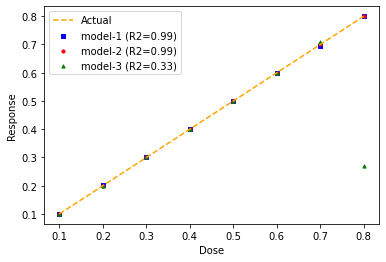

In [60]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], '--', color='orange', label='Actual')
ax1.scatter([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], all_y.iloc[:,0], s=10, c='b', marker="s", label='model-1 (R2=0.99)')
ax1.scatter([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], all_y.iloc[:,1], s=10, c='r', marker="o", label='model-2 (R2=0.99)')
ax1.scatter([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], all_y.iloc[:,2], s=10, c='g', marker="^", label='model-3 (R2=0.33)')
plt.legend(loc='upper left')
ax1.set_xlabel('Dose')
ax1.set_ylabel('Response')
plt.show()

In [ ]:
# THE END